In [45]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

import matplotlib.pyplot as plt

In [46]:
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

# A chamber of experts

Here we will experiment with a new method to have many experts of which we will only select from the best perforing k of them based on a condition M.

We will need to make the following adaptations to our code:
- Calculating the indices of the best performing cells based off of a condition.
- Selecting from elligble cells, and reweighting all at once.
- add funcitonality for k.

Will begin by just implementing the k part.

Challenge: How do you start, just take the first k this doesnt make a difference at the start

In [120]:
class first_MACI(AdaptiveCP):
    def set_loss(self, optimal_set, given_set):
        # If the optimal set is somehow 0, then we will return the given set.
        if optimal_set == 0:
            return 0
        else:
            val = (optimal_set - given_set) / optimal_set
         
        if val < 0:
            return (self.coverage_target) * (-1* val)
        else:
            return (1 - self.coverage_target) * val
    
    def set_loss_vectorize(self):
         return np.vectorize(self.set_loss)
    
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
        xpred, y = timeseries_data
        alpha_t_list = [self.coverage_target]

        All_scores = self.score_function(xpred, y)

        err_t_list = []
        conformal_sets_list = []
        
        for i in range(start_point, len(All_scores)):
            Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
            conformal_sets_list.append(Coverage_t)

            # We calculate the optimal B_t.

            yield Coverage_t

            error_t = AdaptiveCP.err_t(y[i], Coverage_t)
            err_t_list.append(error_t)

            alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        return False
    
    def MACI(self, timeseries_data: tuple, interval_candidates: np.array = None, k: int = 5, nu_sigma: tuple = (10**-2, 0.05), gamma: float = 0.05, title: str = None):
        nu, sigma = nu_sigma
        Set_loss = self.set_loss_vectorize()

        # Base level
        _, y = timeseries_data
        err_t_list = []
        conformal_sets_list = []
        all_interval_weights = []
        chosen_interval_index = []
        radii_list = []
        
        if interval_candidates is None:
            interval_candidates = np.array(range(50, 1000, 100))

        # Set_loss relevant
        optimal_radius_list = []
        chosen_radius_list = []
        all_head_radii = []

        # MACI relevant
        loss_at_step_list = []
        eligible_heads_list = []
        eligible_absolute_weight_list = []
        relative_eligible_final_weight_list = []


        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.ones(len(interval_candidates))
        culmative_loss = np.zeros(len(interval_candidates))
        active_k = [*range(k)] # On the first step we will simply take the first k heads.
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
            loss_list = [] # Will contain the loss for each head.
                
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here
            
            # Here we choose the set of heads which we will make our choice from.
            eligible_heads = np.take(head_sets, active_k)
            eligible_weights = np.take(interval_weights, active_k)
            normalised_eligible_weights = eligible_weights/sum(eligible_weights)

            # Appending the eligible weights to the list.
            eligible_absolute_weight_list.append(eligible_weights)
            relative_eligible_final_weight_list.append(normalised_eligible_weights)

            # Choosing which head to use.
            try:
                chosen_index = random.choices(active_k, weights=normalised_eligible_weights, k=1)[0] # Choosing the index of the head we wish to use.
                chosen_set = head_sets[chosen_index]
            except ValueError:
                print(all_interval_weights[-5:])
                raise ValueError('Interval probabilities are not normalised correctly.')
            

             # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) 
            
            head_set_radius = np.array(list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)))
            
            # Calculating the loss and updating culmative loss.
            loss_at_step = Set_loss(optimal_set_radius, head_set_radius)
            loss_at_step_list.append(loss_at_step)

            culmative_loss += Set_loss(optimal_set_radius, head_set_radius)

            # Updating the weights.
            new_weights = interval_weights * np.exp(-1 * nu * culmative_loss) # log space
            final_weights = new_weights*(1-sigma) + (new_weights.mean() *sigma) # mean
            
            interval_weights = final_weights/sum(final_weights)

            # Updating the active k.
            active_k = np.argsort(final_weights)[:k] # Getting the argument of the k smallest weights
            eligible_heads_list.append(active_k)

            # Incrementing the i-count
            i_count+=1

            # Appending the results to the lists.
            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(chosen_index)
            err_t_list.append(err_true)
            radii_list.append(head_set_radius)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) 
            optimal_radius_list.append(optimal_set_radius)
            all_head_radii.append(head_set_radius)
            all_interval_weights.append(interval_weights)

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0])/2 for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'safe AwACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'all_head_radii': all_head_radii,
                'all_weights': all_interval_weights,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50,
                'radii_list': radii_list,
                'loss_at_step_list': loss_at_step_list,
                'eligible_heads_list': eligible_heads_list,
                'eligible_absolute_weight_list': eligible_absolute_weight_list,
                'relative_eligible_final_weight_list': relative_eligible_final_weight_list
                
            }


In [63]:
a = [(1,2), (3,4)]
print(a[0])

(1, 2)


In [64]:
length = 5000
shift_points = [0.5, 0.8]
shift_data = ACP_data.multiple_shift([(0,1), (3,5), (0,1)], shift_points=shift_points, seq_length=length)

In [101]:
M = first_MACI(0.1)
result = M.MACI(shift_data[0], k=3)

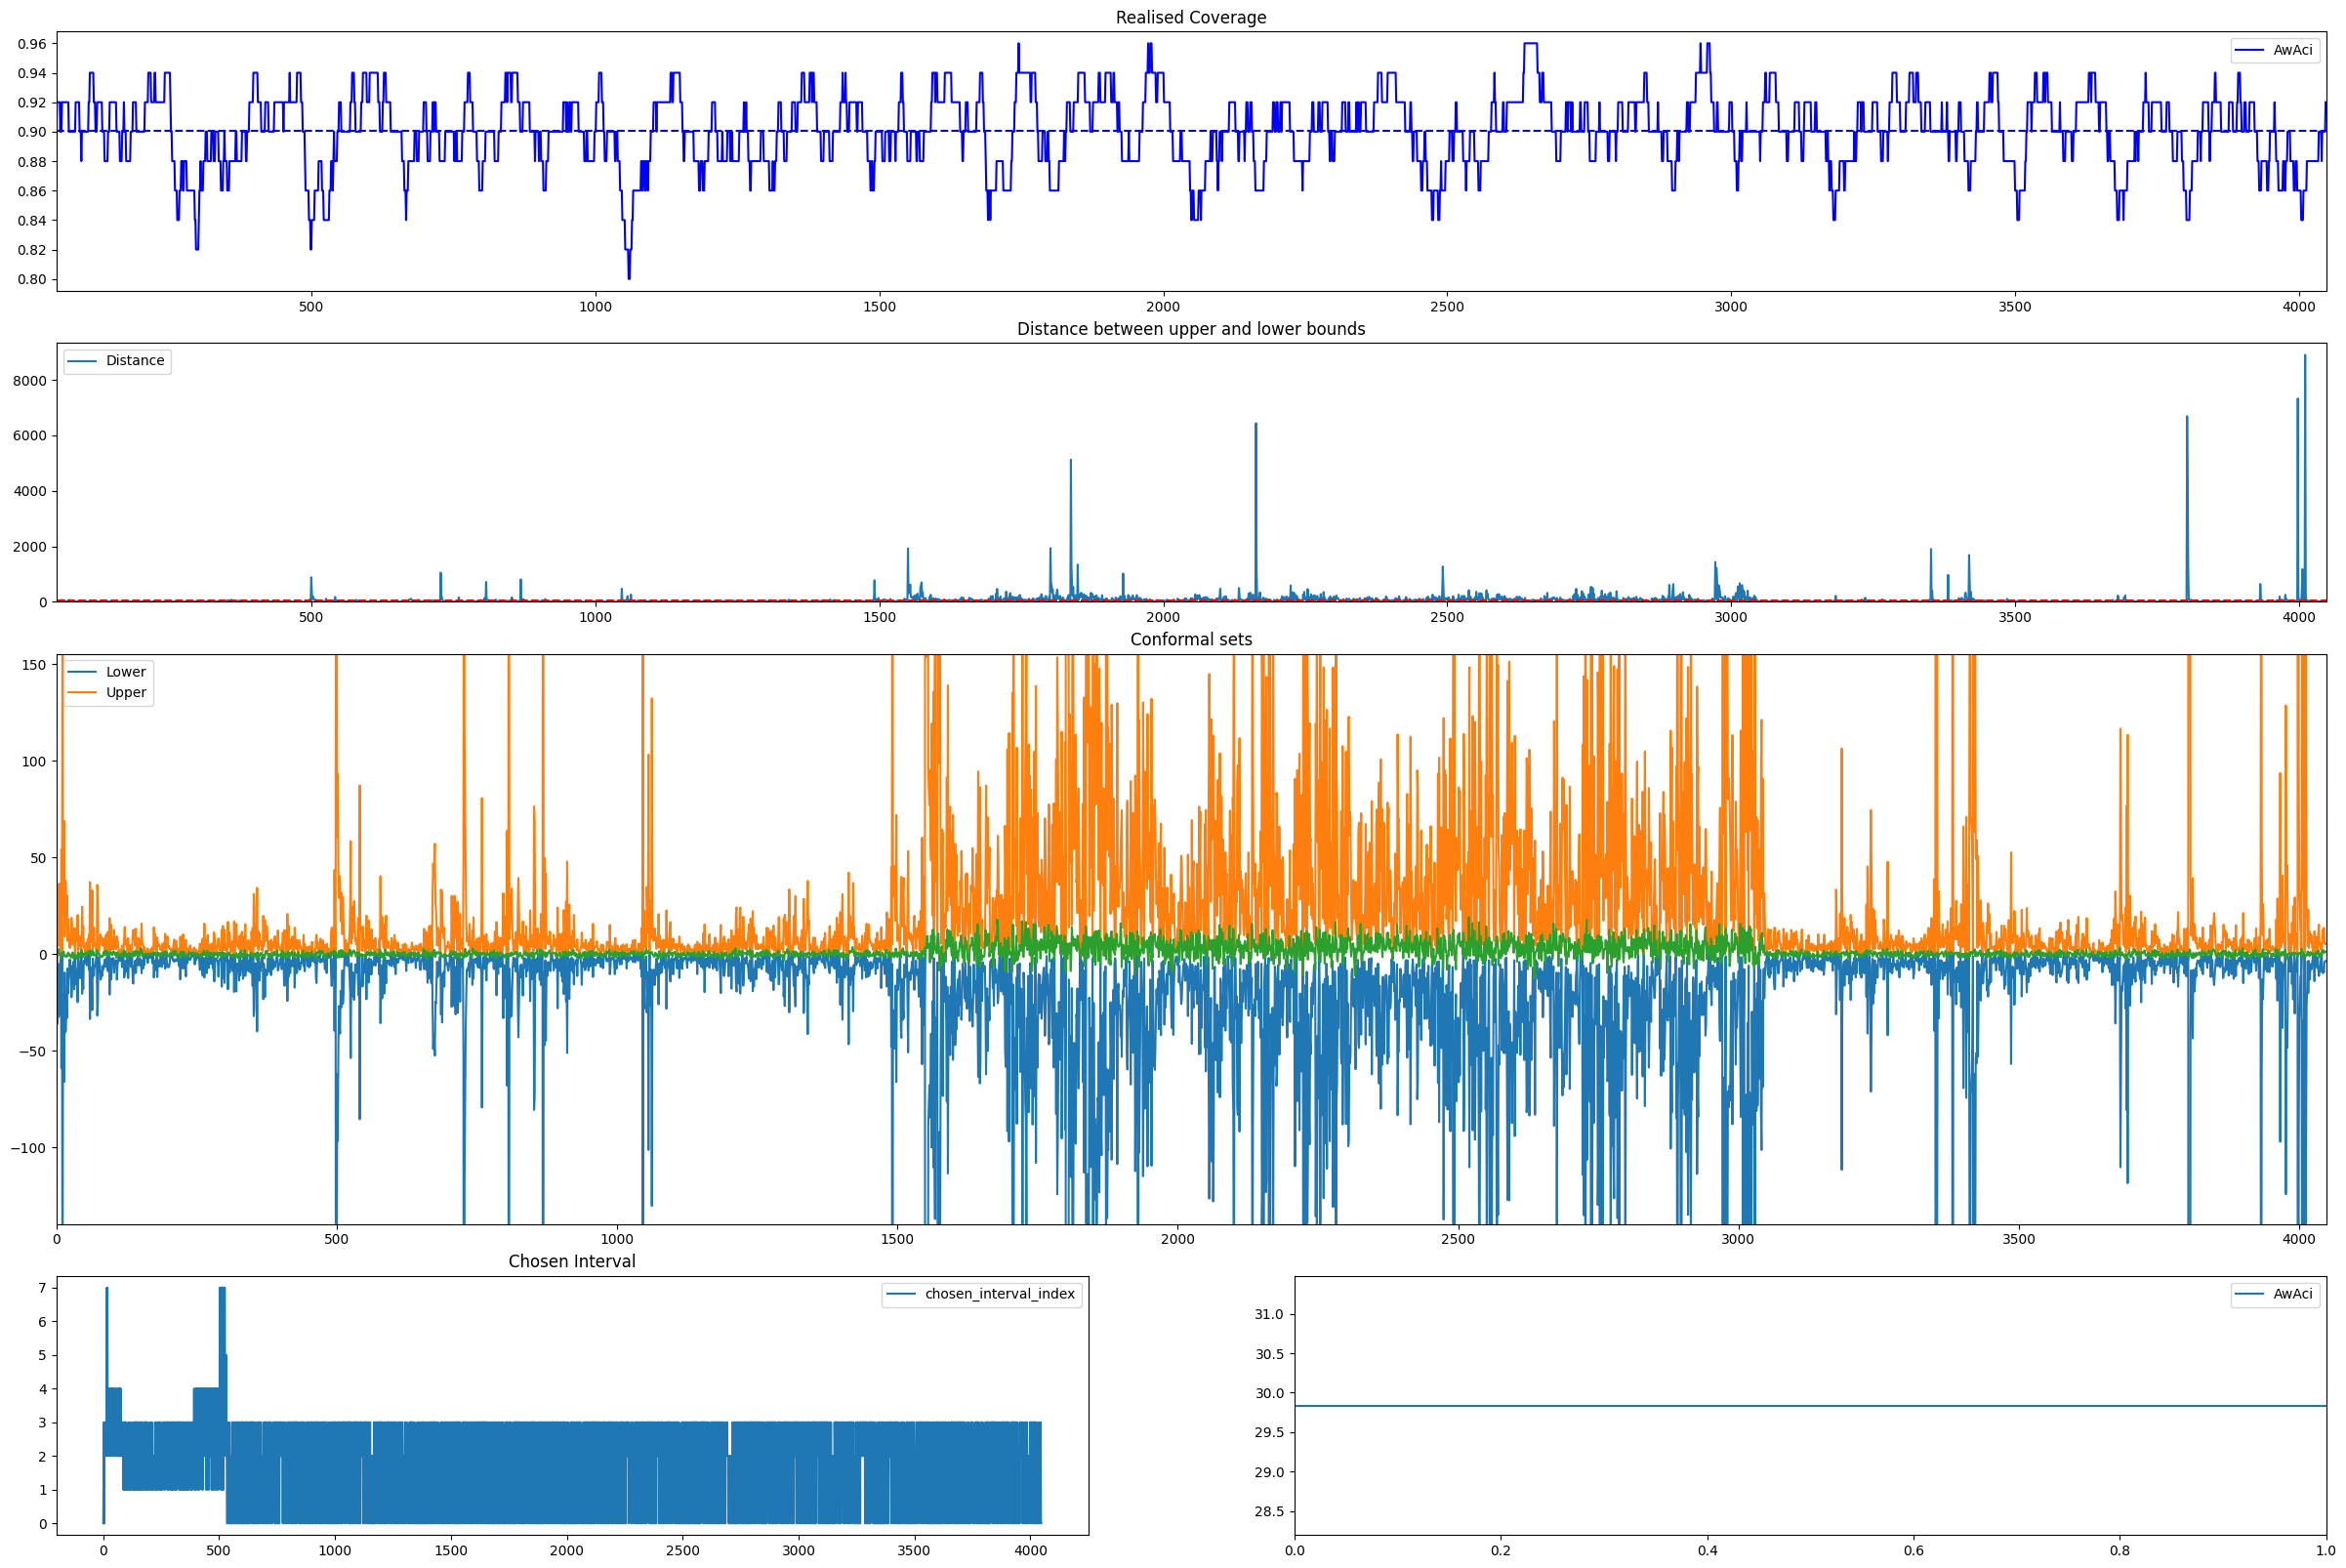

In [102]:
ACP_plots.AwDT_plot(result, shift_data[0])

In [105]:
def many_analyse_shifts(data, method, candidates, shift_list, nu_sigma=(10**-2, 0.05), k=5):
  
    result = method(data, interval_candidates=candidates, nu_sigma=nu_sigma, k=k)
    interval_candidates = result['interval_candidates']

    plt.figure(figsize=(30, 15))
    plt.subplot(2, 2, 1)
    plt.plot(data[0])
    for shift in shift_list:
        plt.axvline(x=shift, color='red')
    plt.title('Data with Shift Points')

    shift_list = [x - max(interval_candidates) for x in shift_list]
    plt.subplot(2, 2, 2)
    rel_weights = np.column_stack(result['all_weights'])
    for i, x in enumerate(rel_weights):
        plt.plot(x, label=interval_candidates[i])
    for shift in shift_list:
        plt.axvline(x=shift, color='red')
    plt.legend()
    plt.title('Weight Distribution')

    all_weights_splits = np.split(result['all_weights'], shift_list)
    all_radii_splits = np.split(result['radii_list'], shift_list)

    len_labels = [str(x) for x in interval_candidates]

    list_weight_dstack = [np.dstack(x) for x in all_weights_splits]
    list_mean_weight = [x.mean(axis=2).mean(axis=0) for x in list_weight_dstack]

    list_radii_dstack = [np.dstack(x) for x in all_radii_splits]
    list_mean_radii = [x.mean(axis=2).mean(axis=0) for x in list_radii_dstack]

    plt.subplot(2, 2, 3)
    plt.bar([str(x) for x in interval_candidates] + ['method'] , np.append(np.column_stack(result['radii_list']).mean(axis=1), result['average_prediction_interval']))
    plt.title('Radii Distribution')

    plt.tight_layout()
    plt.show()


    for i, (weight, radii) in enumerate(zip(list_mean_weight, list_mean_radii)):
        print('Section:', i, '-'*100)
        print(len(all_weights_splits[i]))
        
        # rel_weights =  np.column_stack(all_weights_splits[i])
        # for i, x in enumerate(rel_weights):
        #     plt.plot(x, label=interval_candidates[i])
        # plt.legend()
        
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))

        axs[0].pie(weight, labels=len_labels, autopct='%1.1f%%', startangle=140)
        axs[0].set_title('Weight Distribution')

        axs[1].bar(len_labels, radii)
        axs[1].set_title('Radii Distribution')

        plt.show()


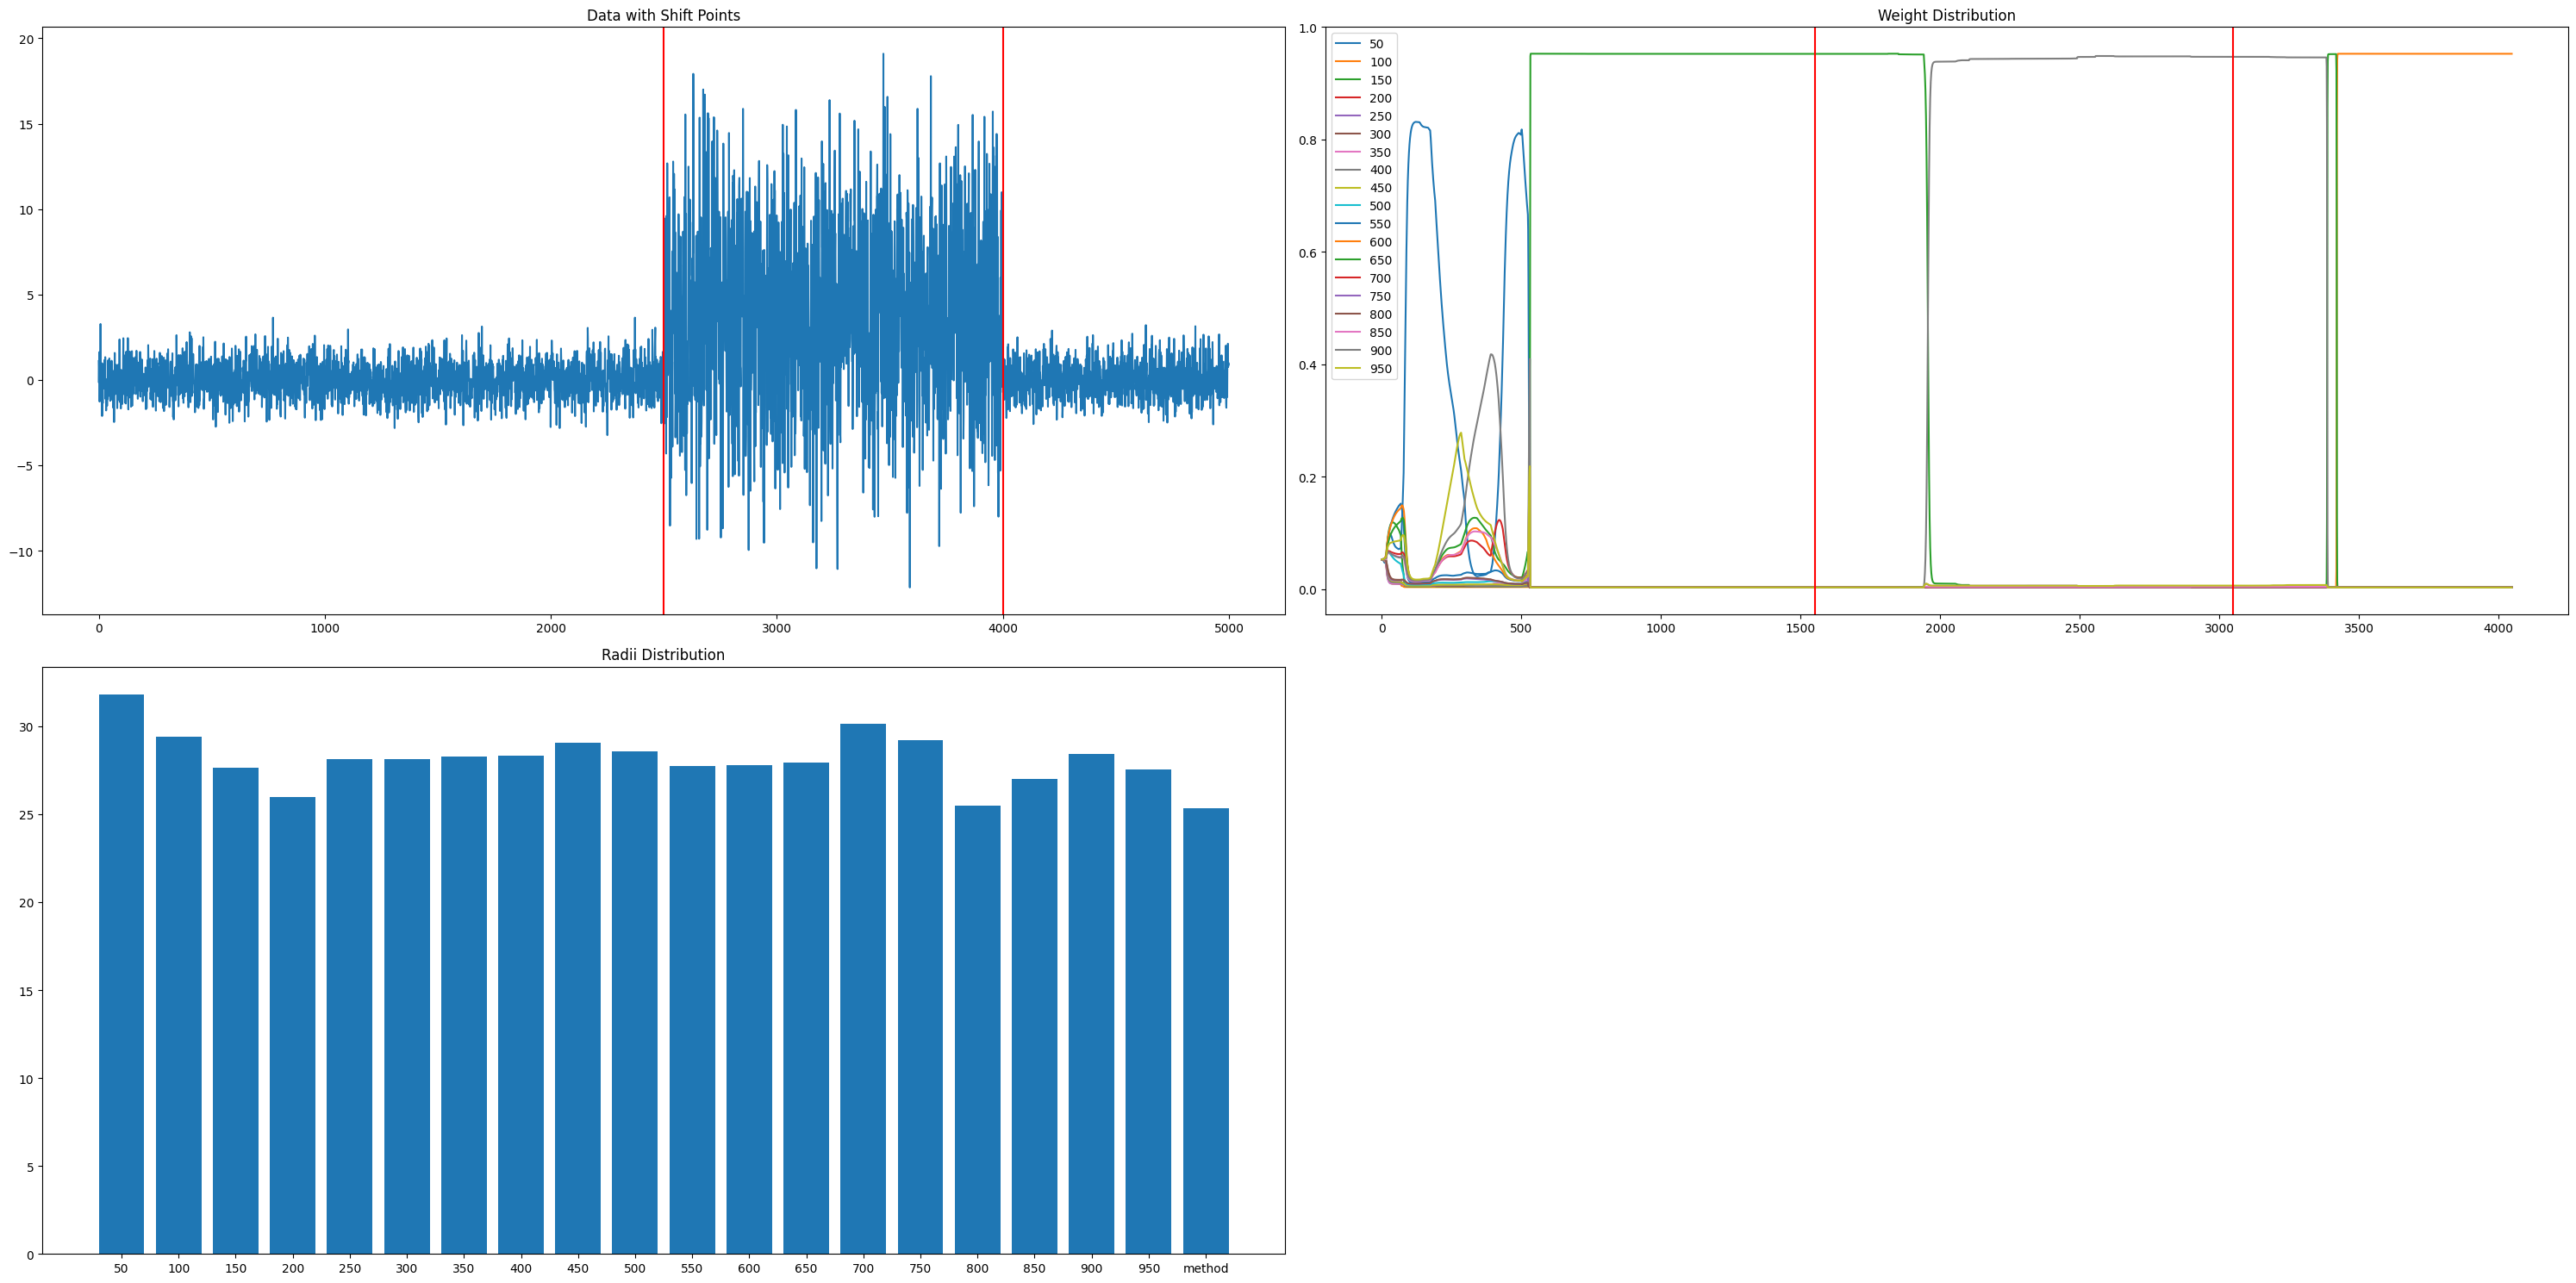

Section: 0 ----------------------------------------------------------------------------------------------------
1550


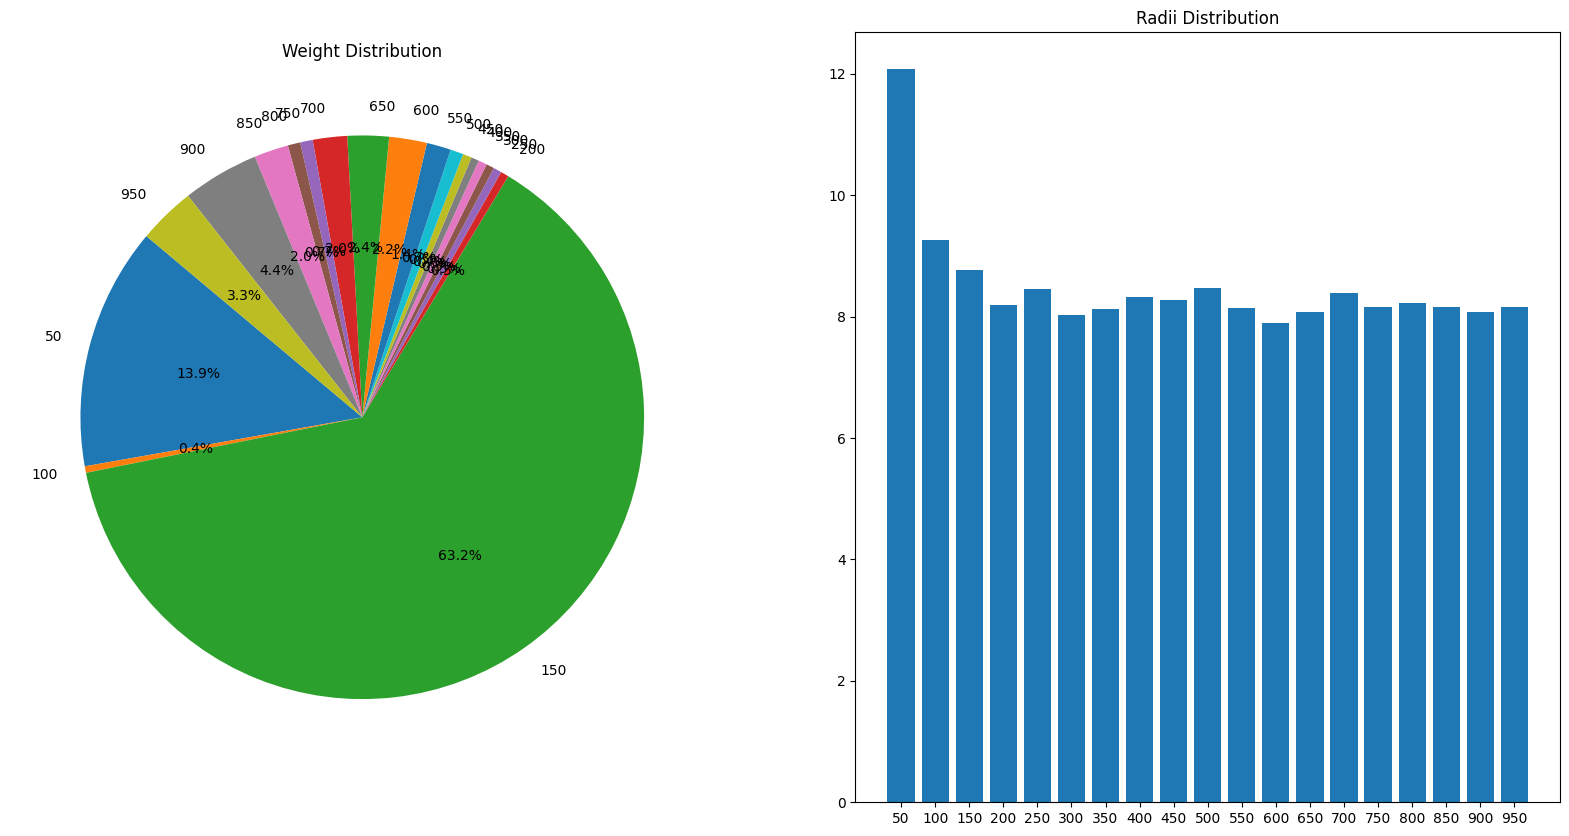

Section: 1 ----------------------------------------------------------------------------------------------------
1500


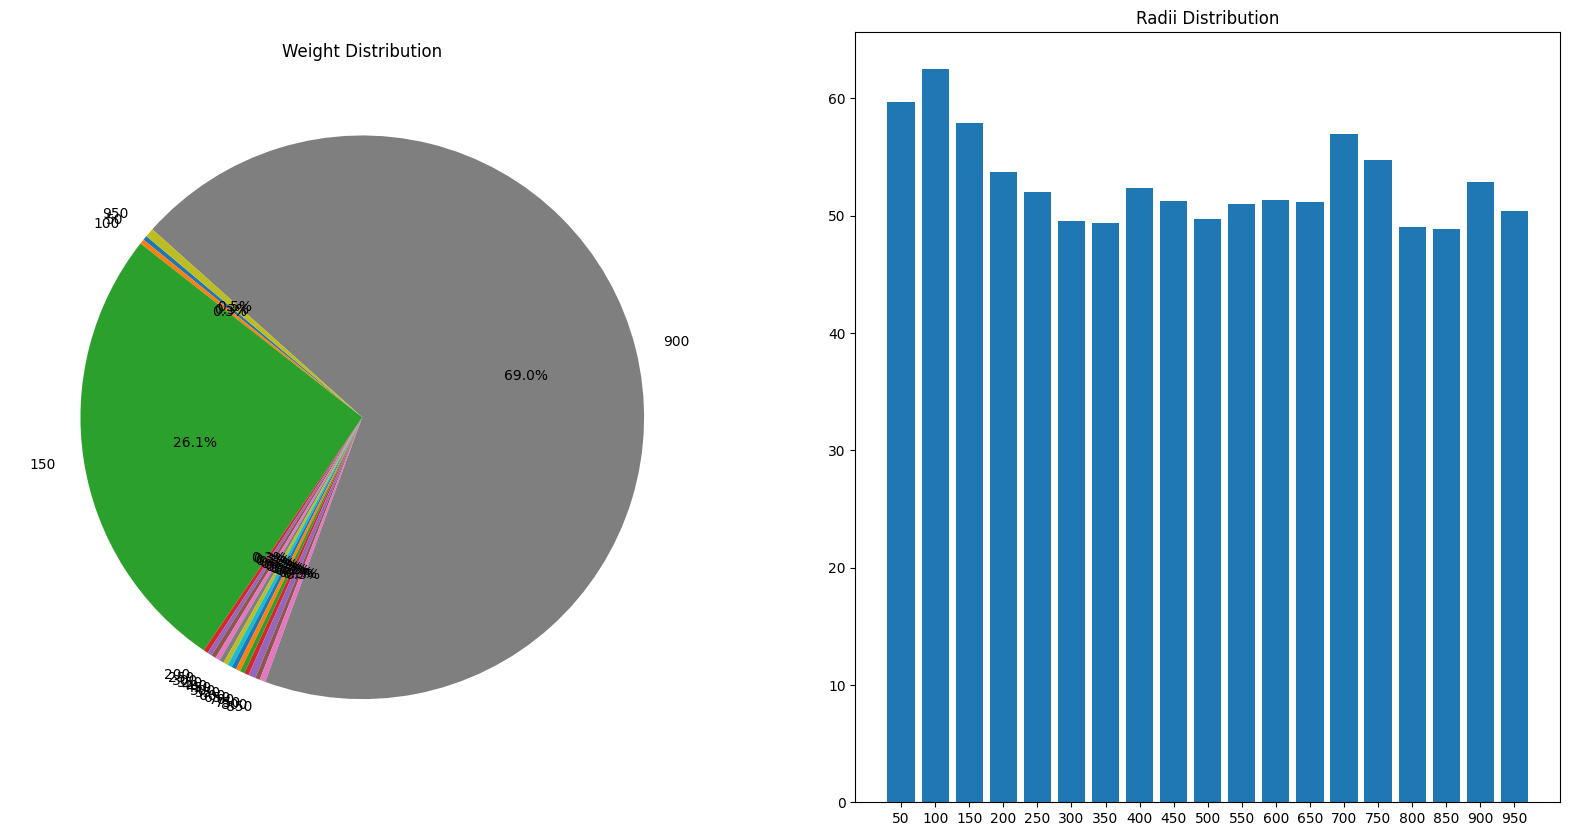

Section: 2 ----------------------------------------------------------------------------------------------------
998


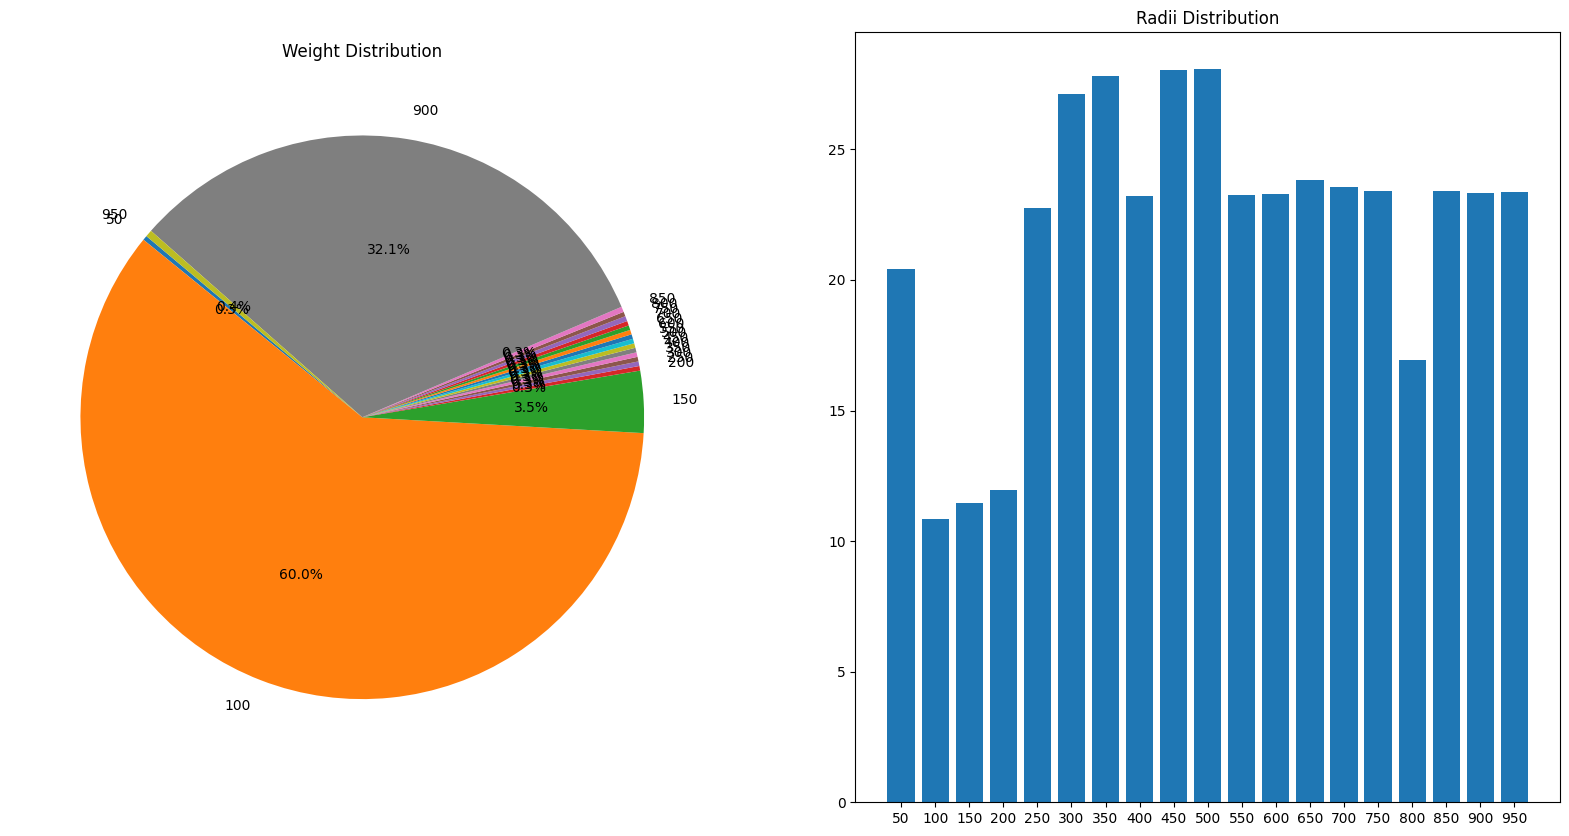

In [108]:
many_analyse_shifts(shift_data[0], first_MACI().MACI, [*range(50, 1000, 50)], [int(length*x) for x in shift_points], (3*(10**-3), 0.05), 4)

In [78]:
random_data = ACP_data.random_shift(seq_range=(5000,5001))

In [97]:
length = 5000
shift_points2 = [0.3, 0.45, 0.675, 0.7, 0.8]
shift_data2 = ACP_data.multiple_shift([(0,1), (3,5), (-3,3), (-2,0.5), (1,1), (0.1, 10)], shift_points=shift_points2, seq_length=length)

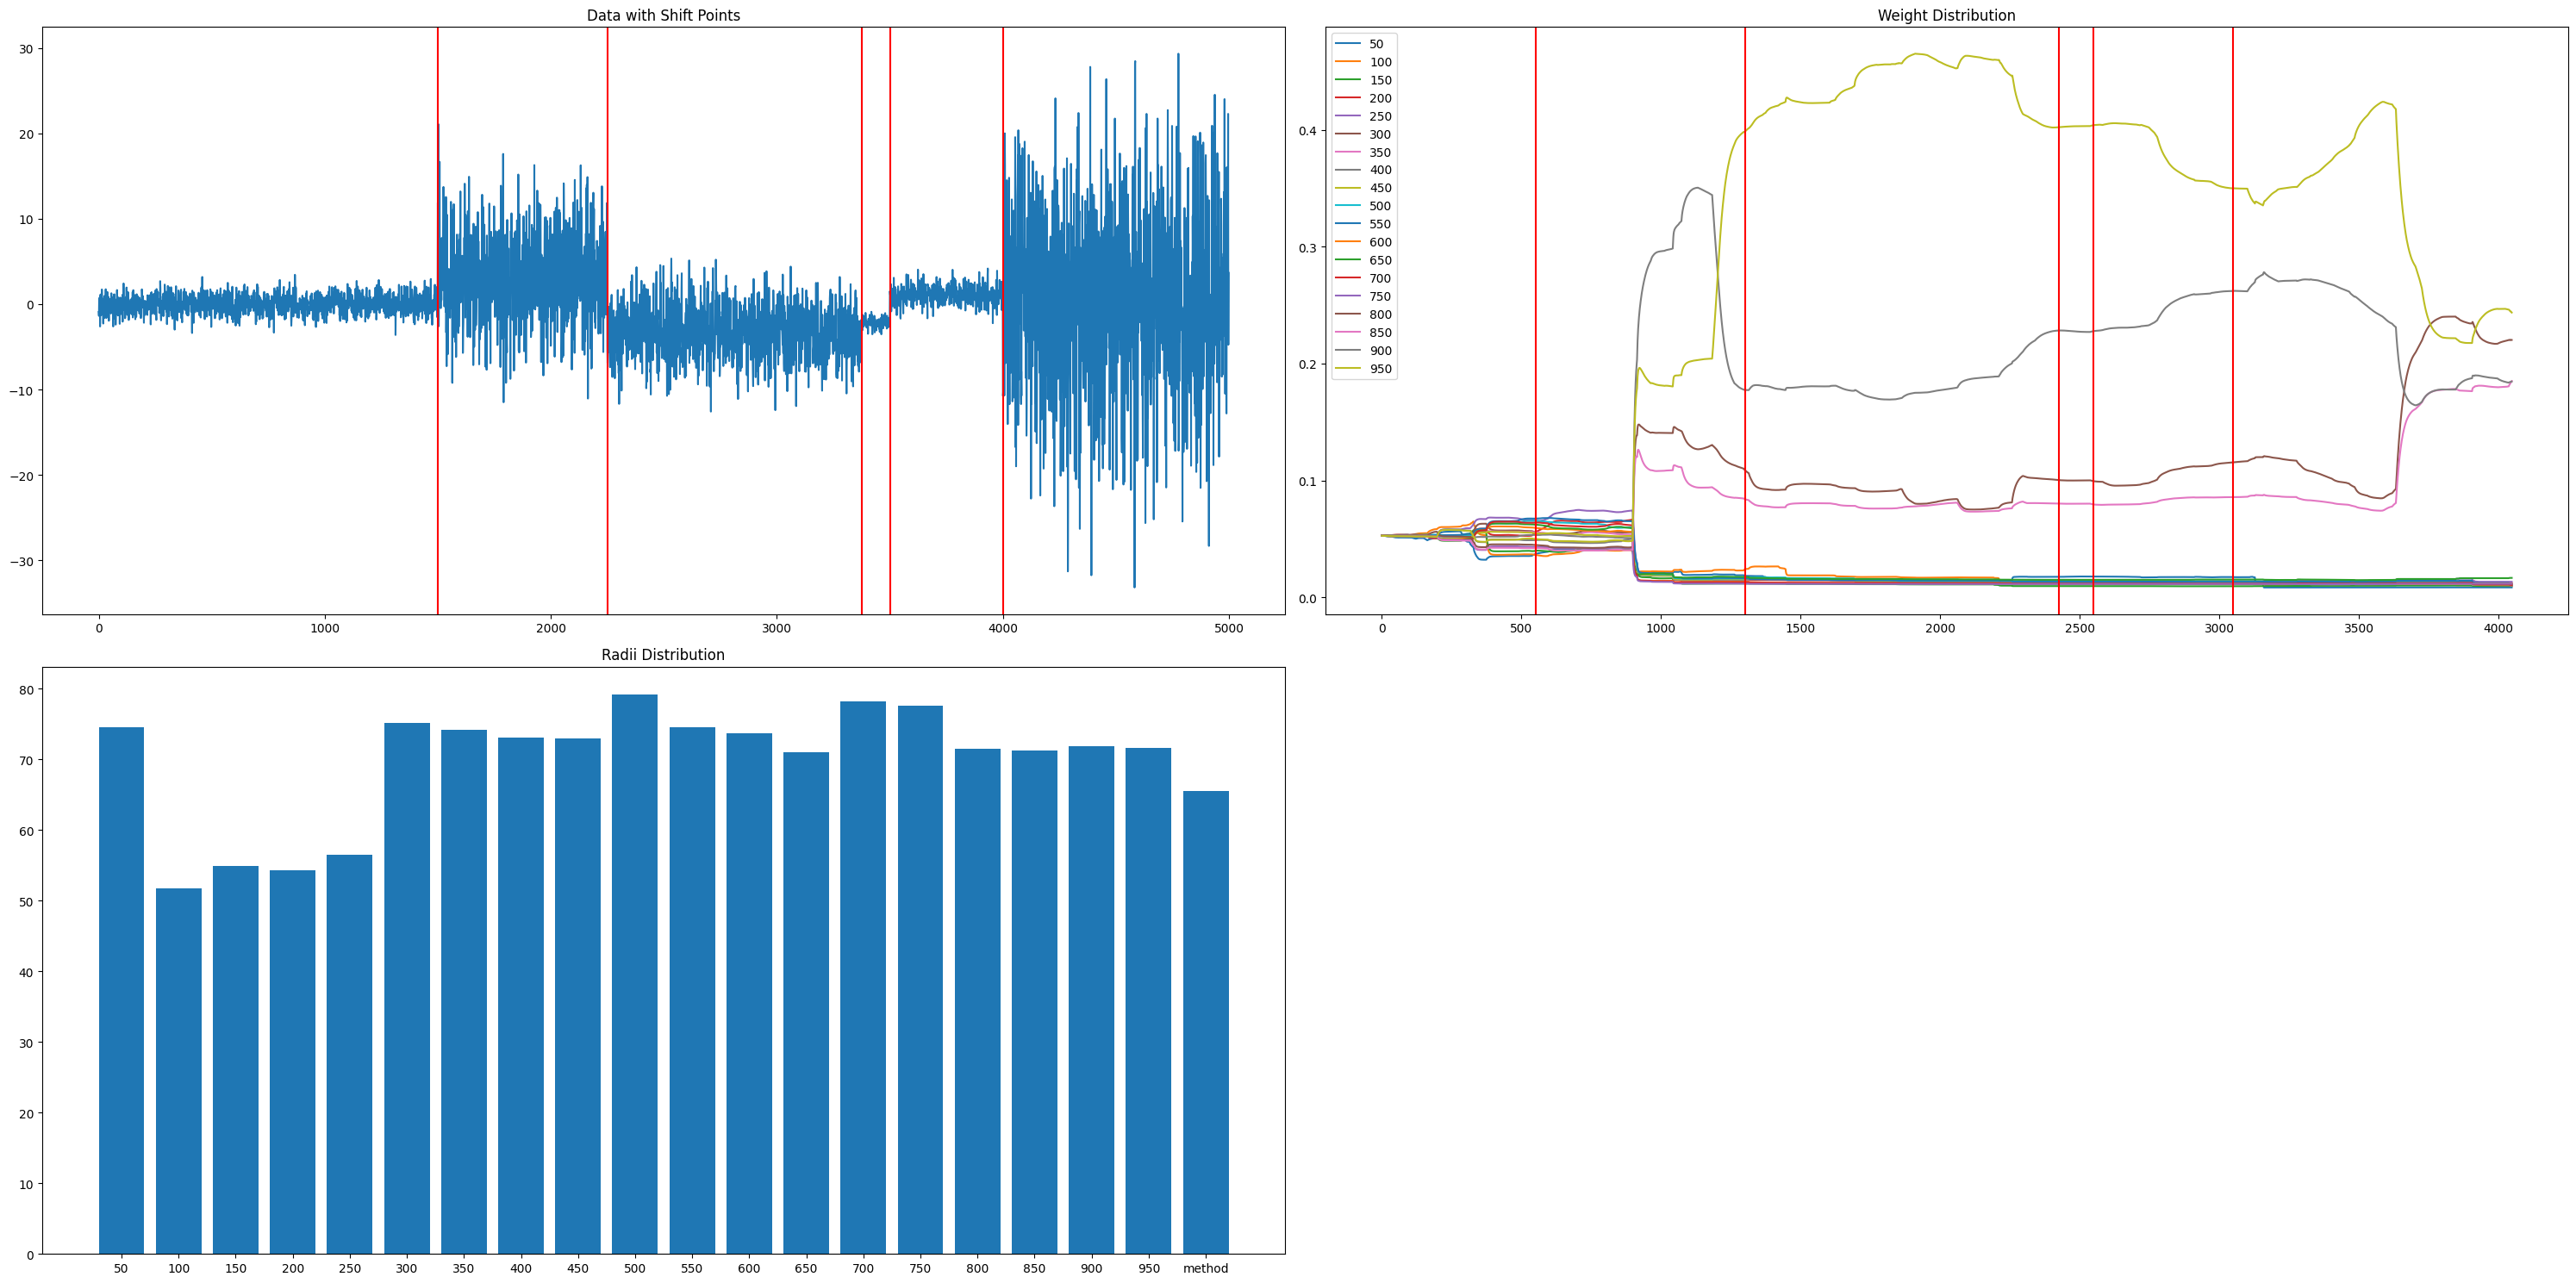

Section: 0 ----------------------------------------------------------------------------------------------------
550


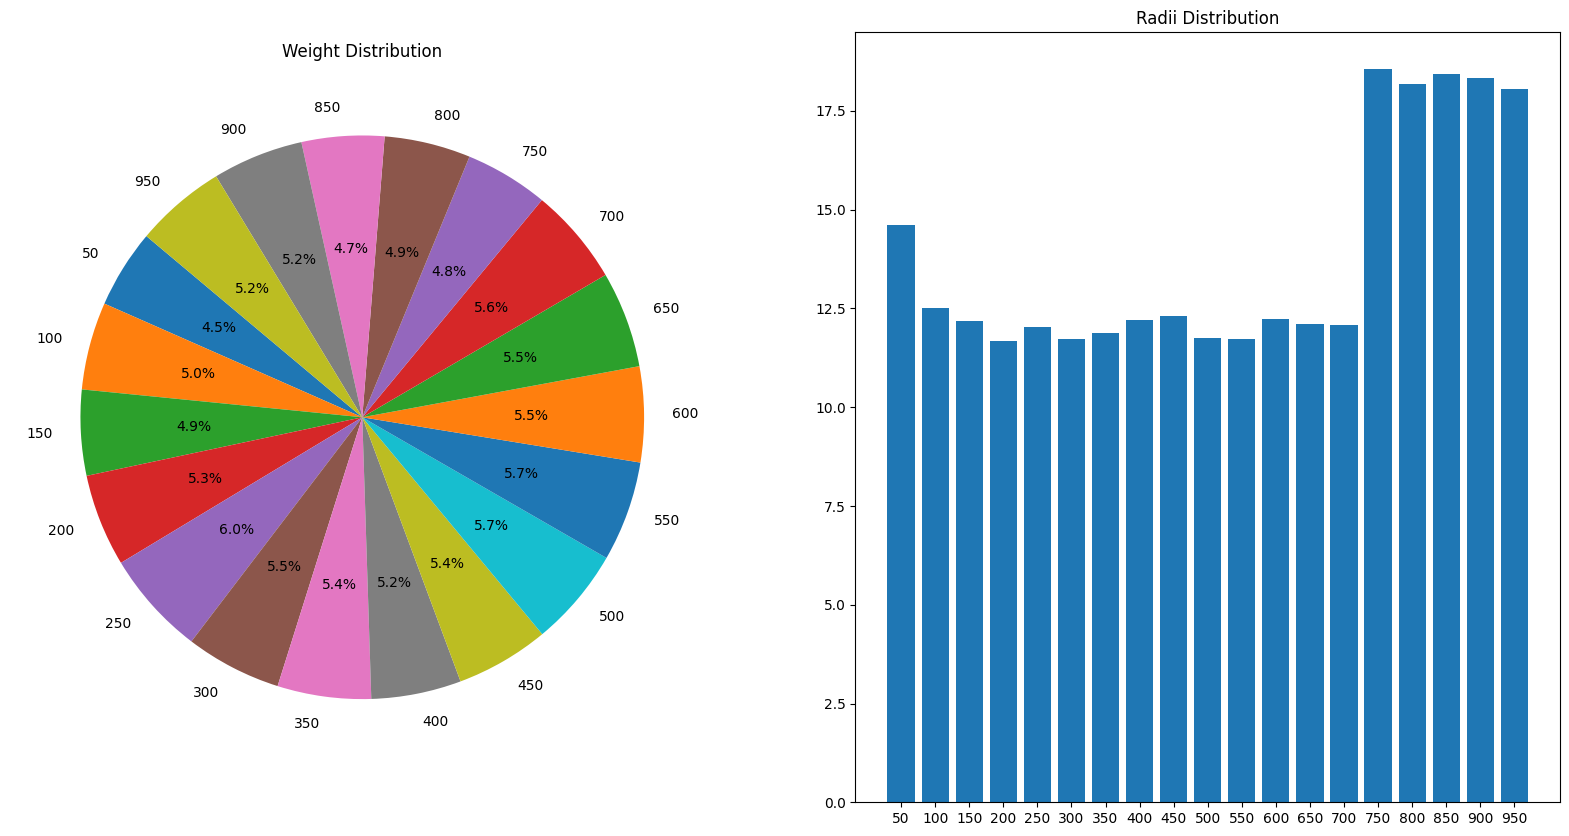

Section: 1 ----------------------------------------------------------------------------------------------------
750


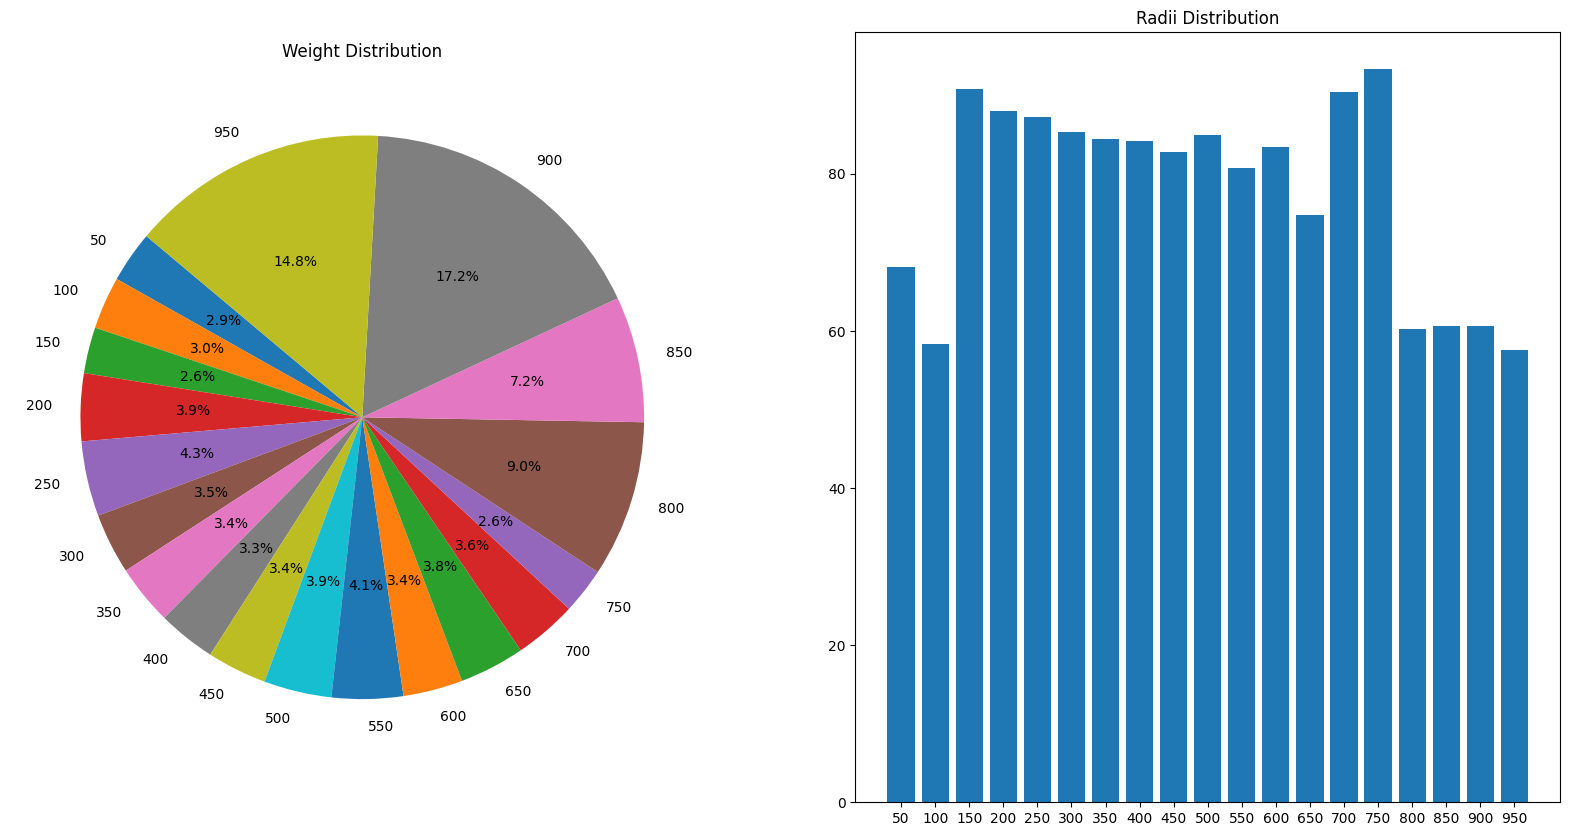

Section: 2 ----------------------------------------------------------------------------------------------------
1125


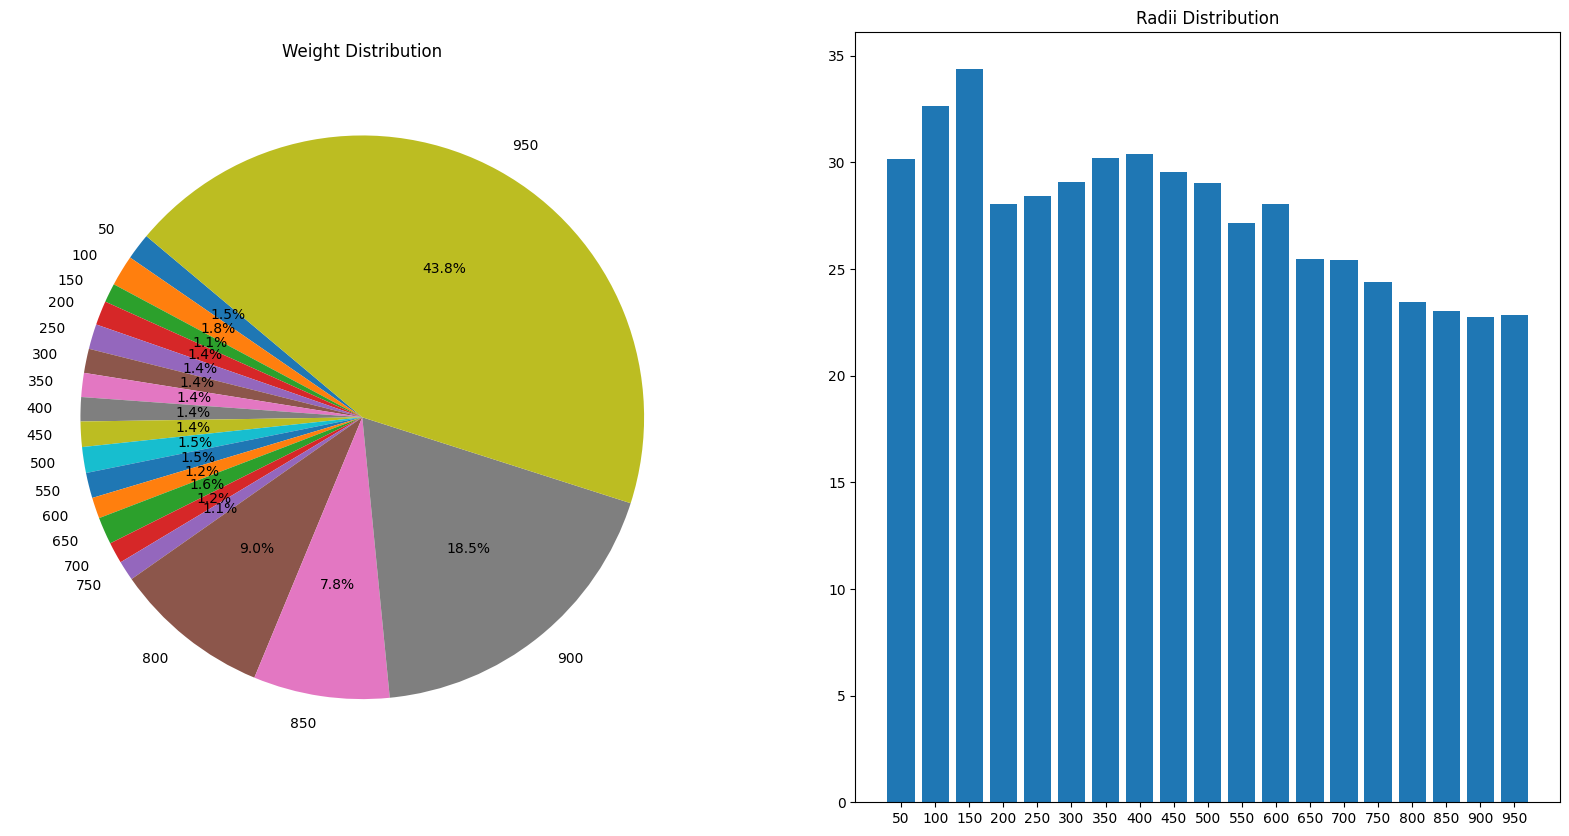

Section: 3 ----------------------------------------------------------------------------------------------------
125


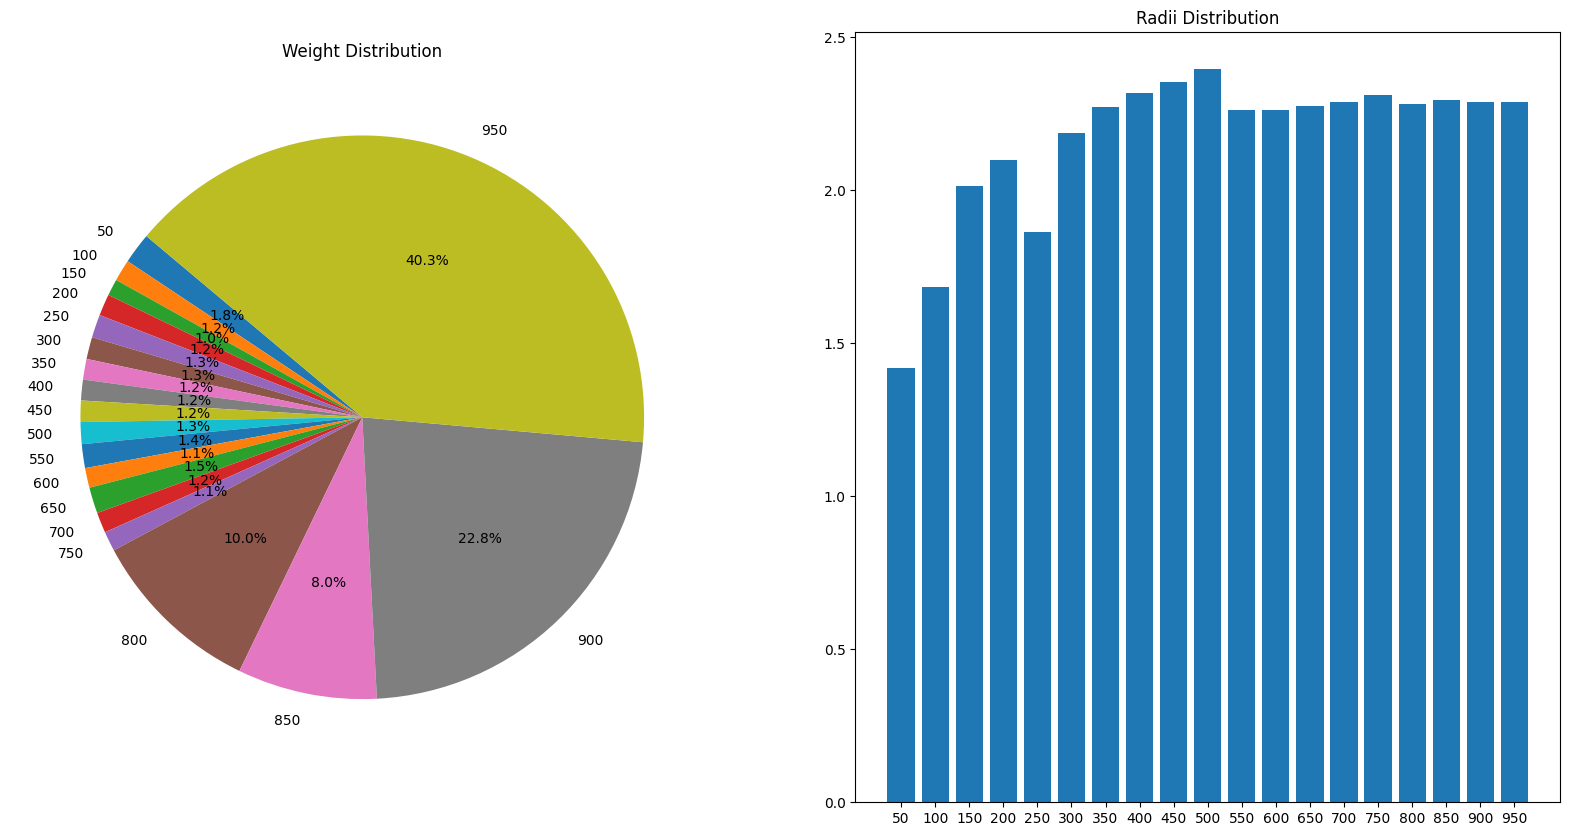

Section: 4 ----------------------------------------------------------------------------------------------------
500


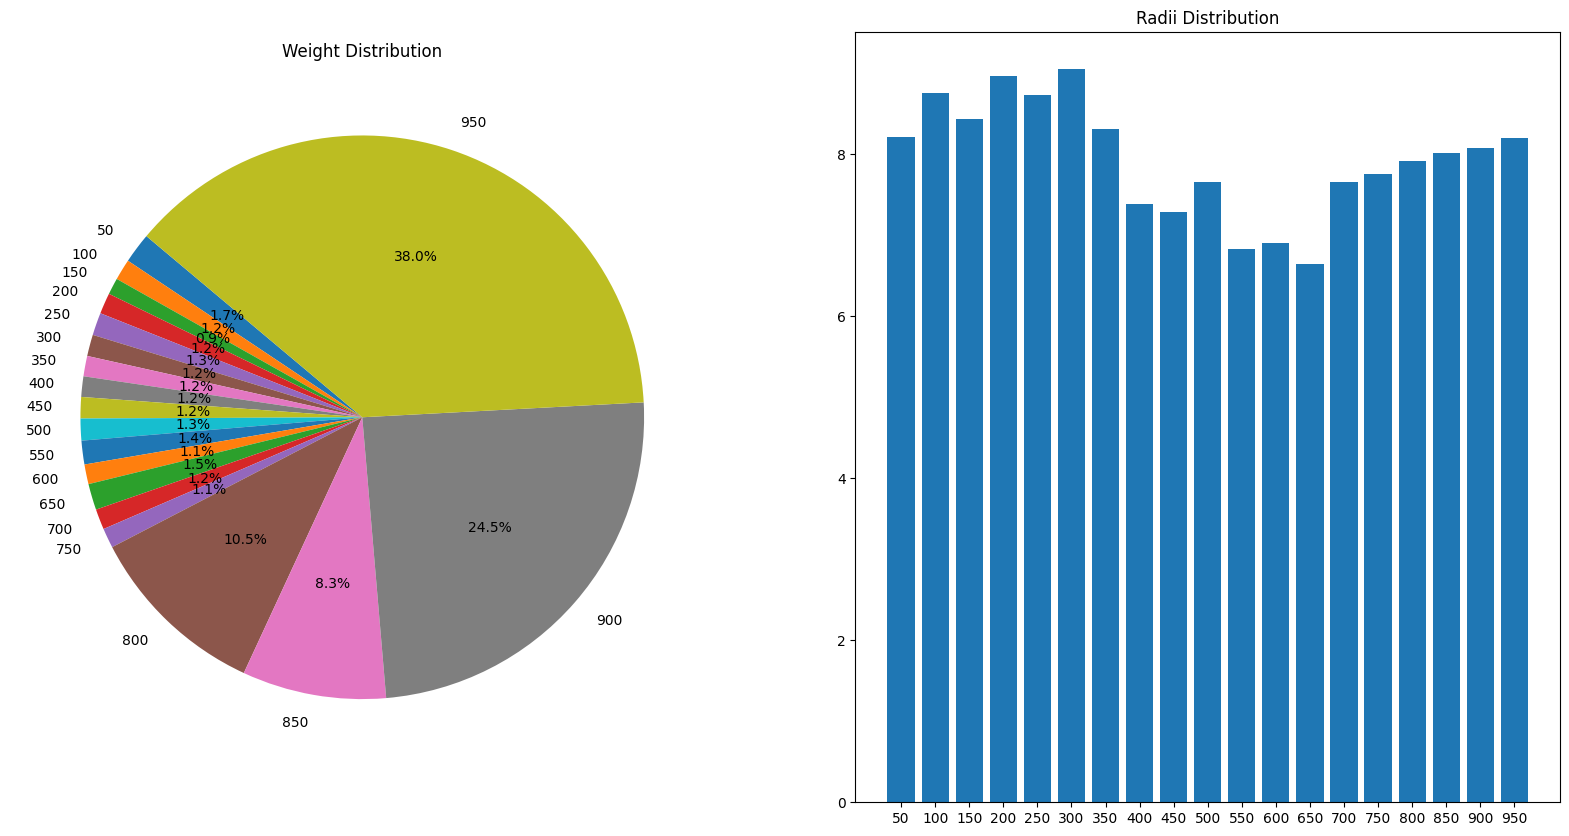

Section: 5 ----------------------------------------------------------------------------------------------------
998


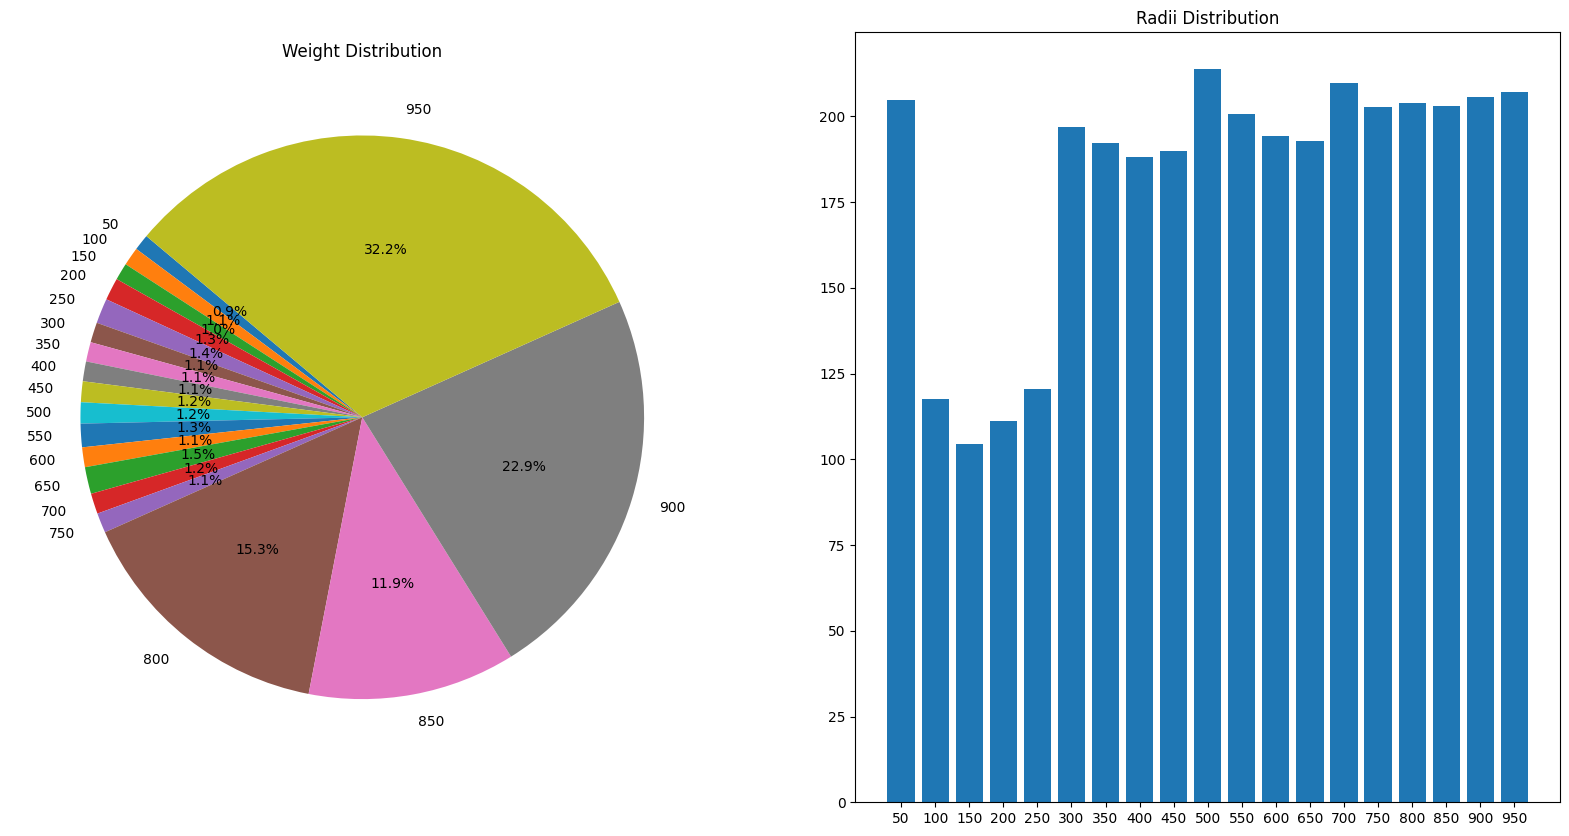

In [110]:
many_analyse_shifts(shift_data2[0], first_MACI().MACI, [*range(50, 1000, 50)], [int(length*x) for x in shift_points2], (3*(10**-4), 0.15), 3)

In [158]:
def analyse_MACI(data, method, candidates, shift_list, nu_sigma=(10**-2, 0.05), k=5):
  
    result = method(data, interval_candidates=candidates, nu_sigma=nu_sigma, k=k)
    interval_candidates = result['interval_candidates']
    print(result['realised_interval_coverage'])

    plt.figure(figsize=(30, 15))
    plt.subplot(2, 2, 1)
    plt.plot(data[0])
    for shift in shift_list:
        plt.axvline(x=shift, color='red')
    plt.title('Data with Shift Points')

    shift_list = [x - max(interval_candidates) for x in shift_list]
    plt.subplot(2, 2, 2)
    rel_weights = np.column_stack(result['all_weights'])
    for i, x in enumerate(rel_weights):
        plt.plot(x, label=interval_candidates[i])
    for shift in shift_list:
        plt.axvline(x=shift, color='red')
    plt.legend()
    plt.title('Weight Distribution')

    # Above is good.

    all_eligible_heads_splits = np.split(result['eligible_heads_list'], shift_list)
    all_eligible_weights_splits = np.split(result['relative_eligible_final_weight_list'], shift_list)

    all_weights_splits = np.split(result['all_weights'], shift_list)
    all_radii_splits = np.split(result['radii_list'], shift_list)

    len_labels = [str(x) for x in interval_candidates]

    flattened_eligible_heads_splits = [x.flatten() for x in all_eligible_heads_splits]
    eligible_head_count = [np.unique(x, return_counts=True) for x in flattened_eligible_heads_splits]

    list_weight_dstack = [np.dstack(x) for x in all_weights_splits]
    list_mean_weight = [x.mean(axis=2).mean(axis=0) for x in list_weight_dstack]

    list_radii_dstack = [np.dstack(x) for x in all_radii_splits]
    list_mean_radii = [x.mean(axis=2).mean(axis=0) for x in list_radii_dstack]

    plt.subplot(2, 2, 3)
    plt.bar([str(x) for x in interval_candidates] + ['method'] , np.append(np.column_stack(result['radii_list']).mean(axis=1), result['average_prediction_interval']))
    plt.title('Radii Distribution')

    plt.tight_layout()
    plt.show()


    for i, (weight, radii) in enumerate(zip(list_mean_weight, list_mean_radii)):
        print('Section:', i, '-'*100)
        print(len(all_weights_splits[i]))
        
        # rel_weights =  np.column_stack(all_weights_splits[i])
        # for i, x in enumerate(rel_weights):
        #     plt.plot(x, label=interval_candidates[i])
        # plt.legend()
        
        fig, axs = plt.subplots(2, 2, figsize=(20, 10))

        axs[0][0].pie(weight, labels=len_labels, autopct='%1.1f%%', startangle=140)
        axs[0][0].set_title('Weight Distribution')

        axs[0][1].bar(len_labels, radii)
        axs[0][1].set_title('Radii Distribution')

        heads, weights = eligible_head_count[i]
        hw_dict = dict(zip(heads, weights/sum(weights)))

        eligible_weighted = [(h, weight[h] * hw_dict[h]) if h in hw_dict else (h,0) for h in heads]
        print(eligible_weighted)

        axs[1][0].pie(weights, labels=[interval_candidates[w] for w in heads], autopct='%1.1f%%', startangle=140)
        axs[1][0].set_title('Relative Occurence of head which are elligible')

        axs[1][1].bar([str(interval_candidates[x[0]]) for x in eligible_weighted], [x[1] for x in eligible_weighted]) 
        axs[1][1].set_title('Weighted Occurence of head which are elligible')

        plt.show()


0.9038359589897474


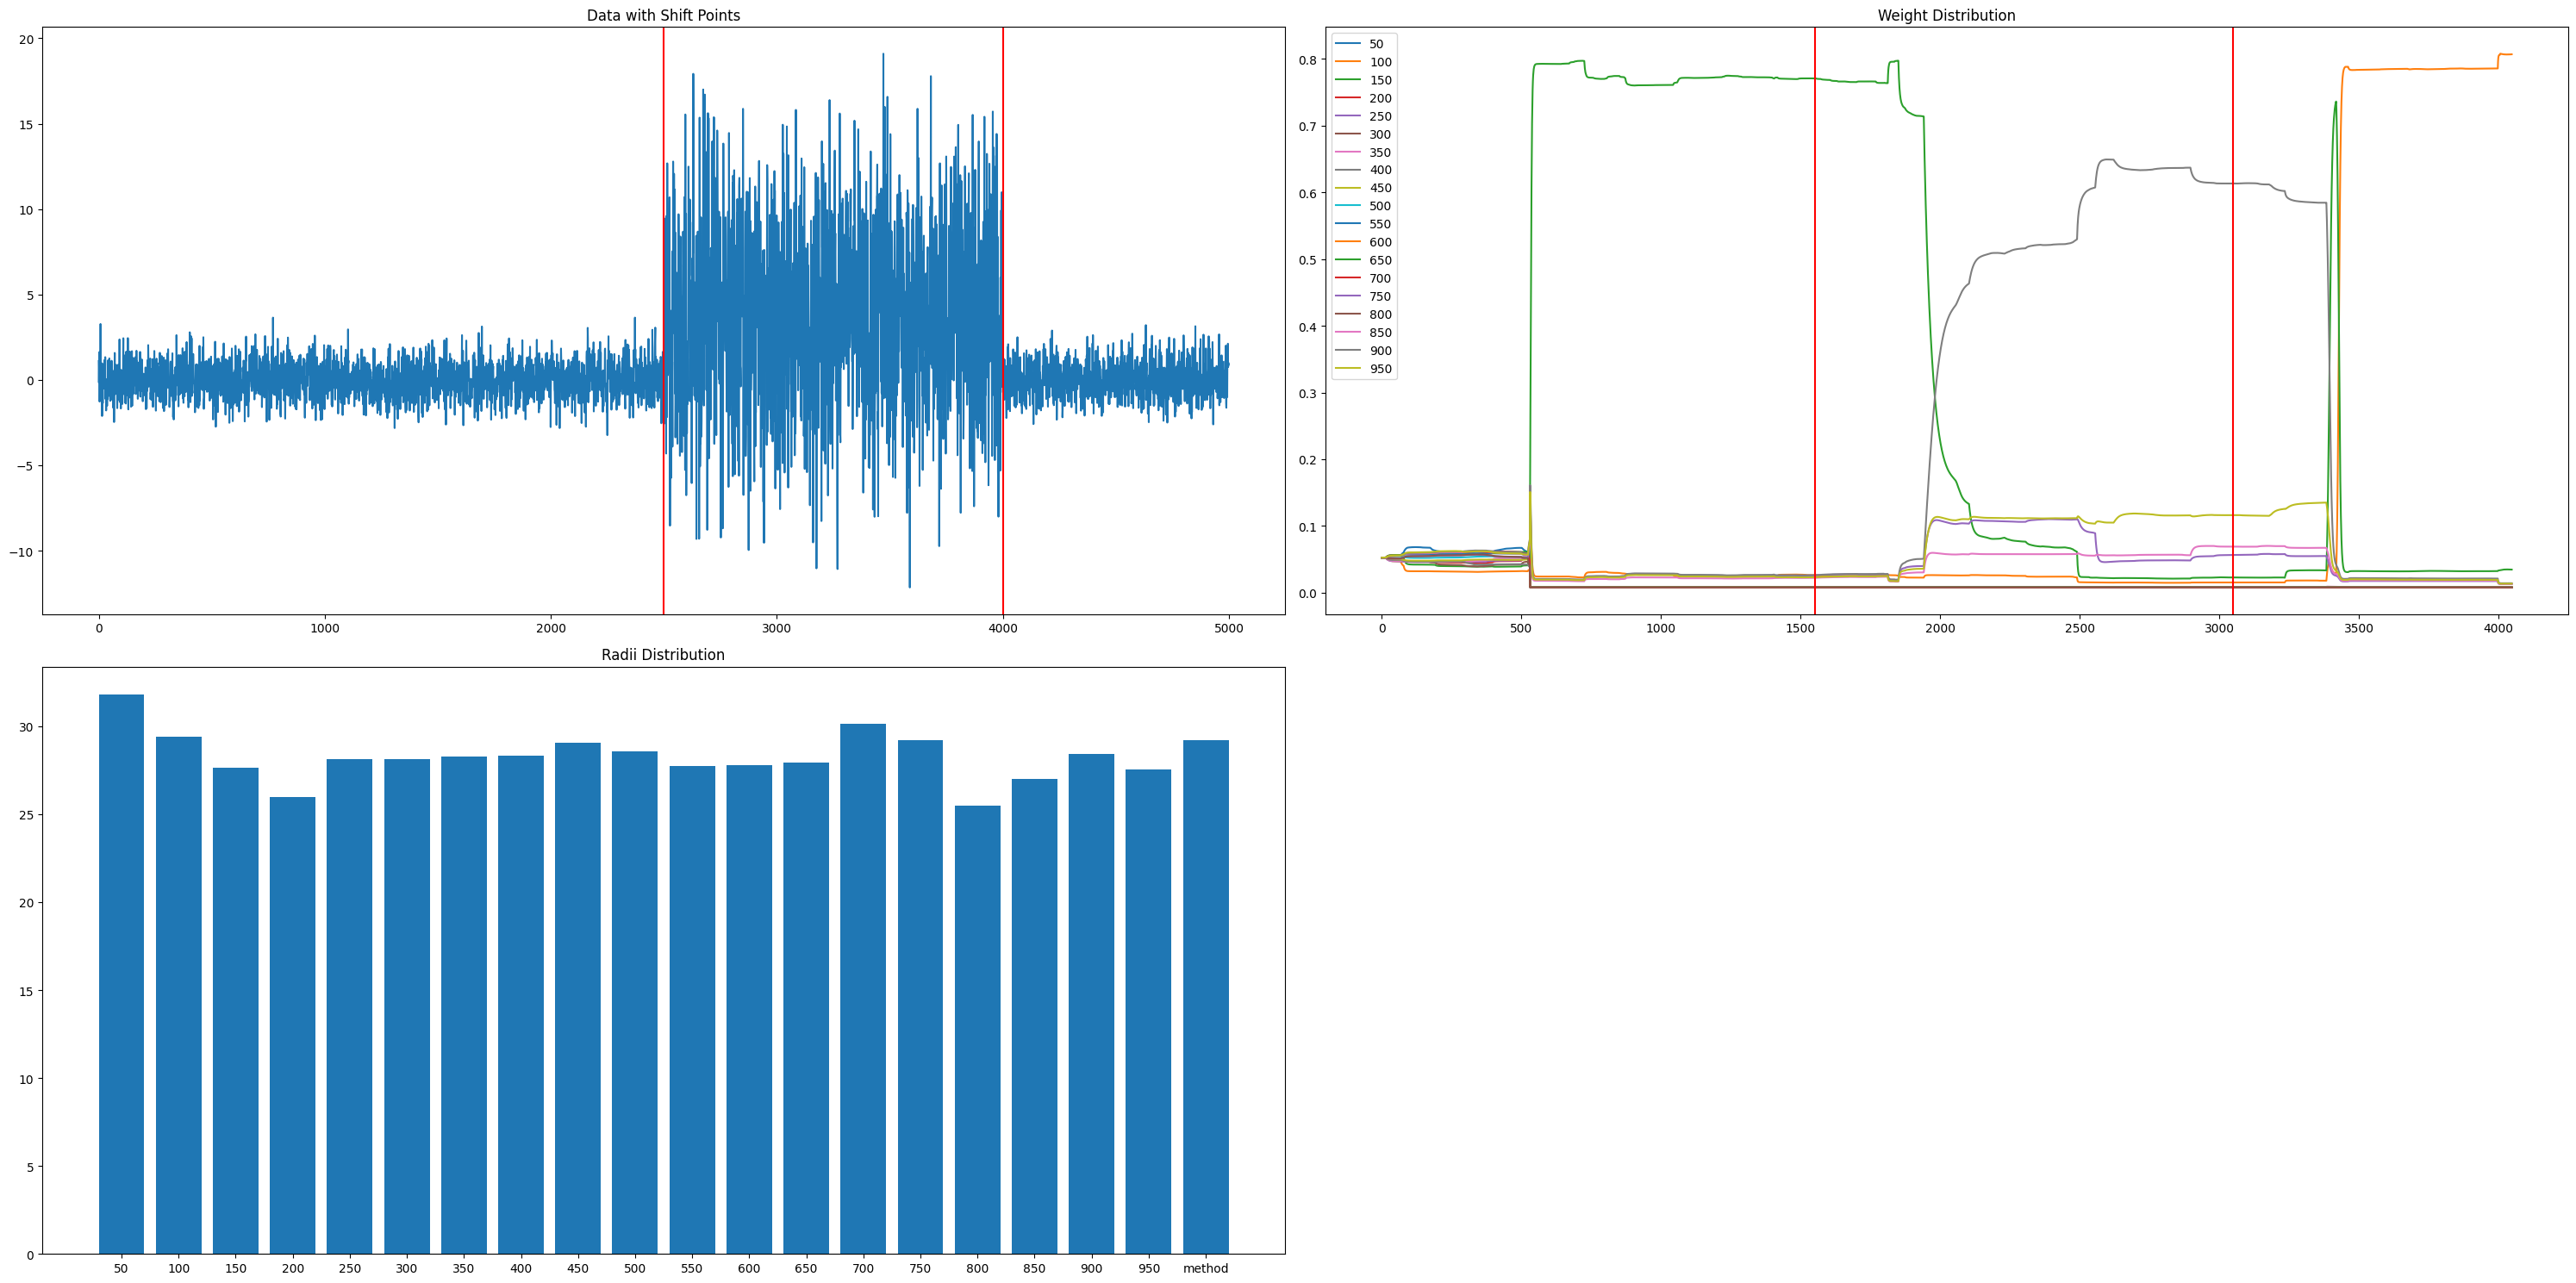

Section: 0 ----------------------------------------------------------------------------------------------------
1550
[(np.int64(0), np.float64(0.005872536735388867)), (np.int64(1), np.float64(0.0033287246927936067)), (np.int64(2), np.float64(0.04957838607579525)), (np.int64(3), np.float64(0.004671342032628515)), (np.int64(4), np.float64(0.0003804704800119051)), (np.int64(5), np.float64(0.0014105178527119829)), (np.int64(6), np.float64(0.0007640596932267683)), (np.int64(7), np.float64(0.0001398610987218426)), (np.int64(10), np.float64(0.005464482090263686)), (np.int64(11), np.float64(5.4943489703195806e-05)), (np.int64(15), np.float64(2.5744311090465792e-05))]


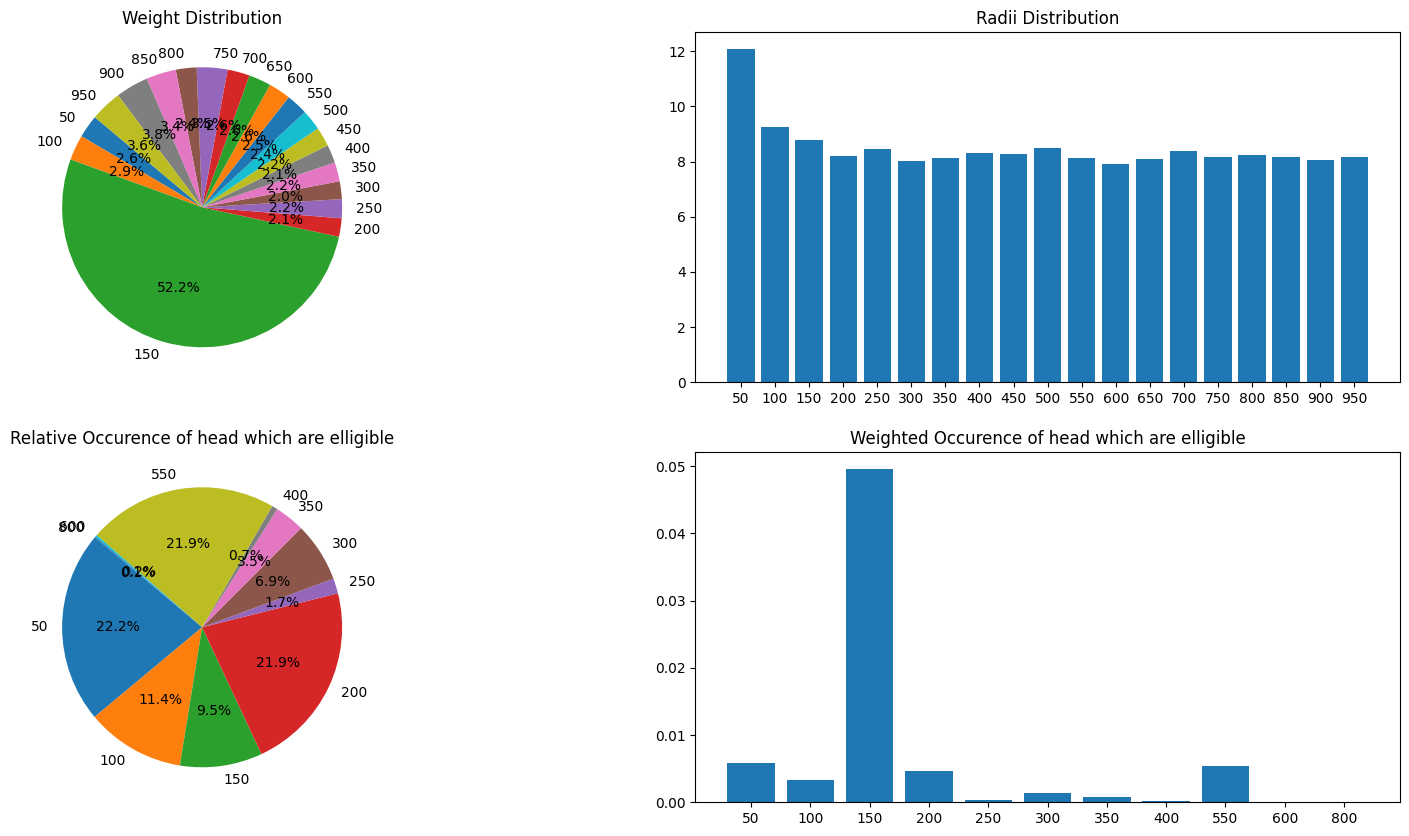

Section: 1 ----------------------------------------------------------------------------------------------------
1500
[(np.int64(0), np.float64(0.002635175223008302)), (np.int64(3), np.float64(0.00264602063504096)), (np.int64(10), np.float64(0.0004652967237105204)), (np.int64(11), np.float64(0.0021859928914906637))]


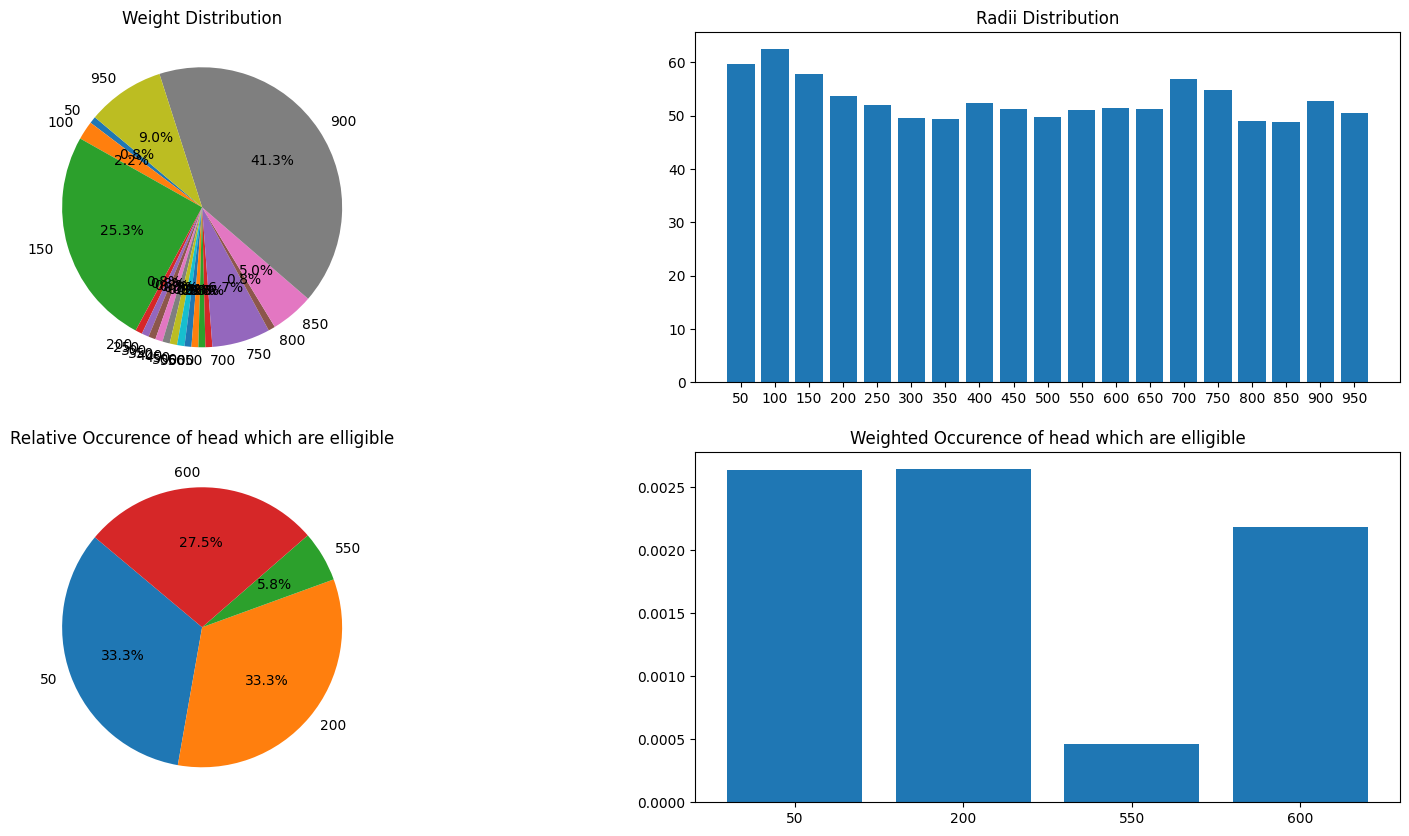

Section: 2 ----------------------------------------------------------------------------------------------------
998
[(np.int64(0), np.float64(0.002635012700822846)), (np.int64(3), np.float64(0.002513339648367877)), (np.int64(10), np.float64(0.0017630373665337572)), (np.int64(11), np.float64(0.0008877460852325344)), (np.int64(13), np.float64(0.00013286923610629947))]


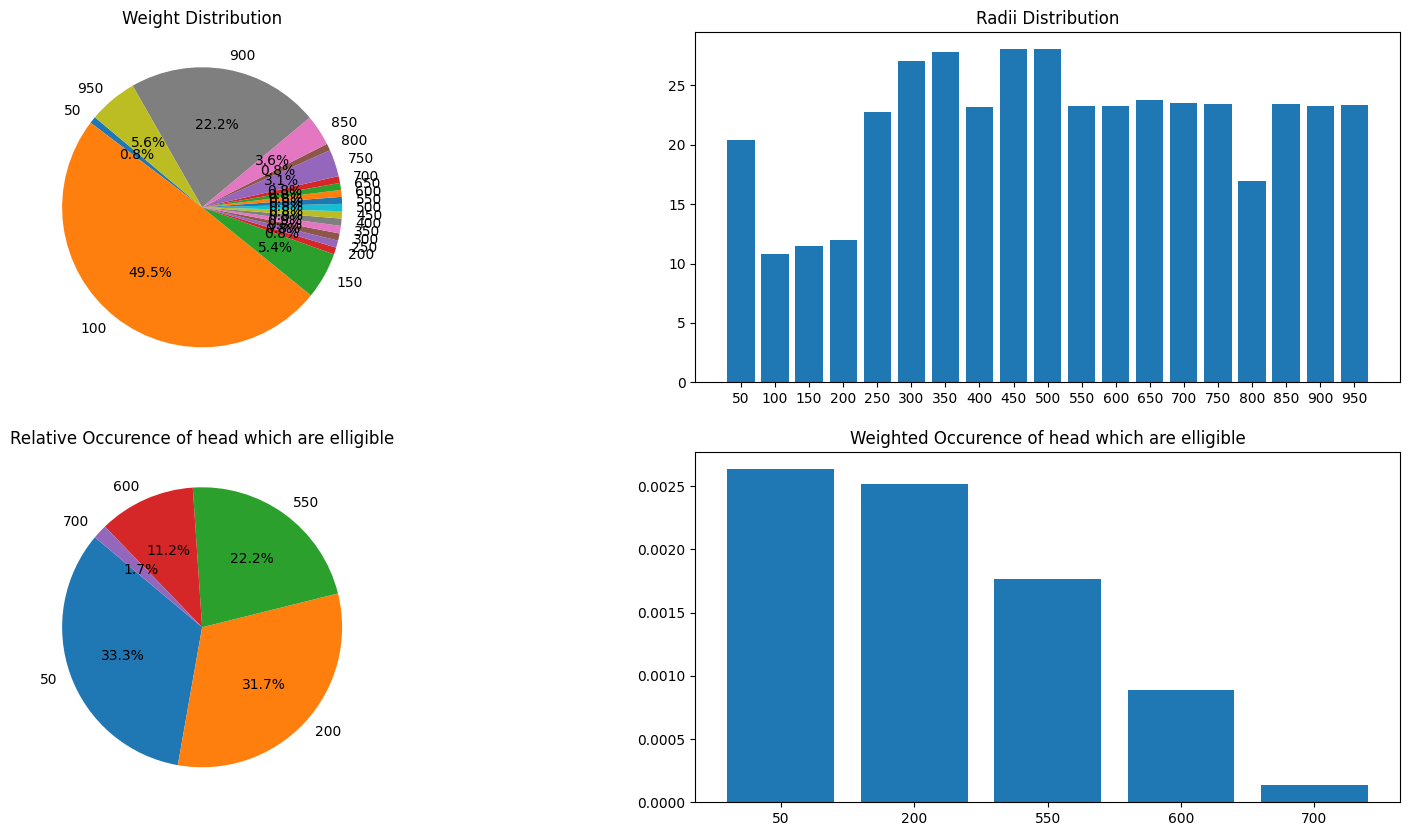

In [159]:
analyse_MACI(shift_data[0], first_MACI().MACI, [*range(50, 1000, 50)], [int(length*x) for x in shift_points], (3*(10**-4), 0.15), 3)

0.8963340835208802


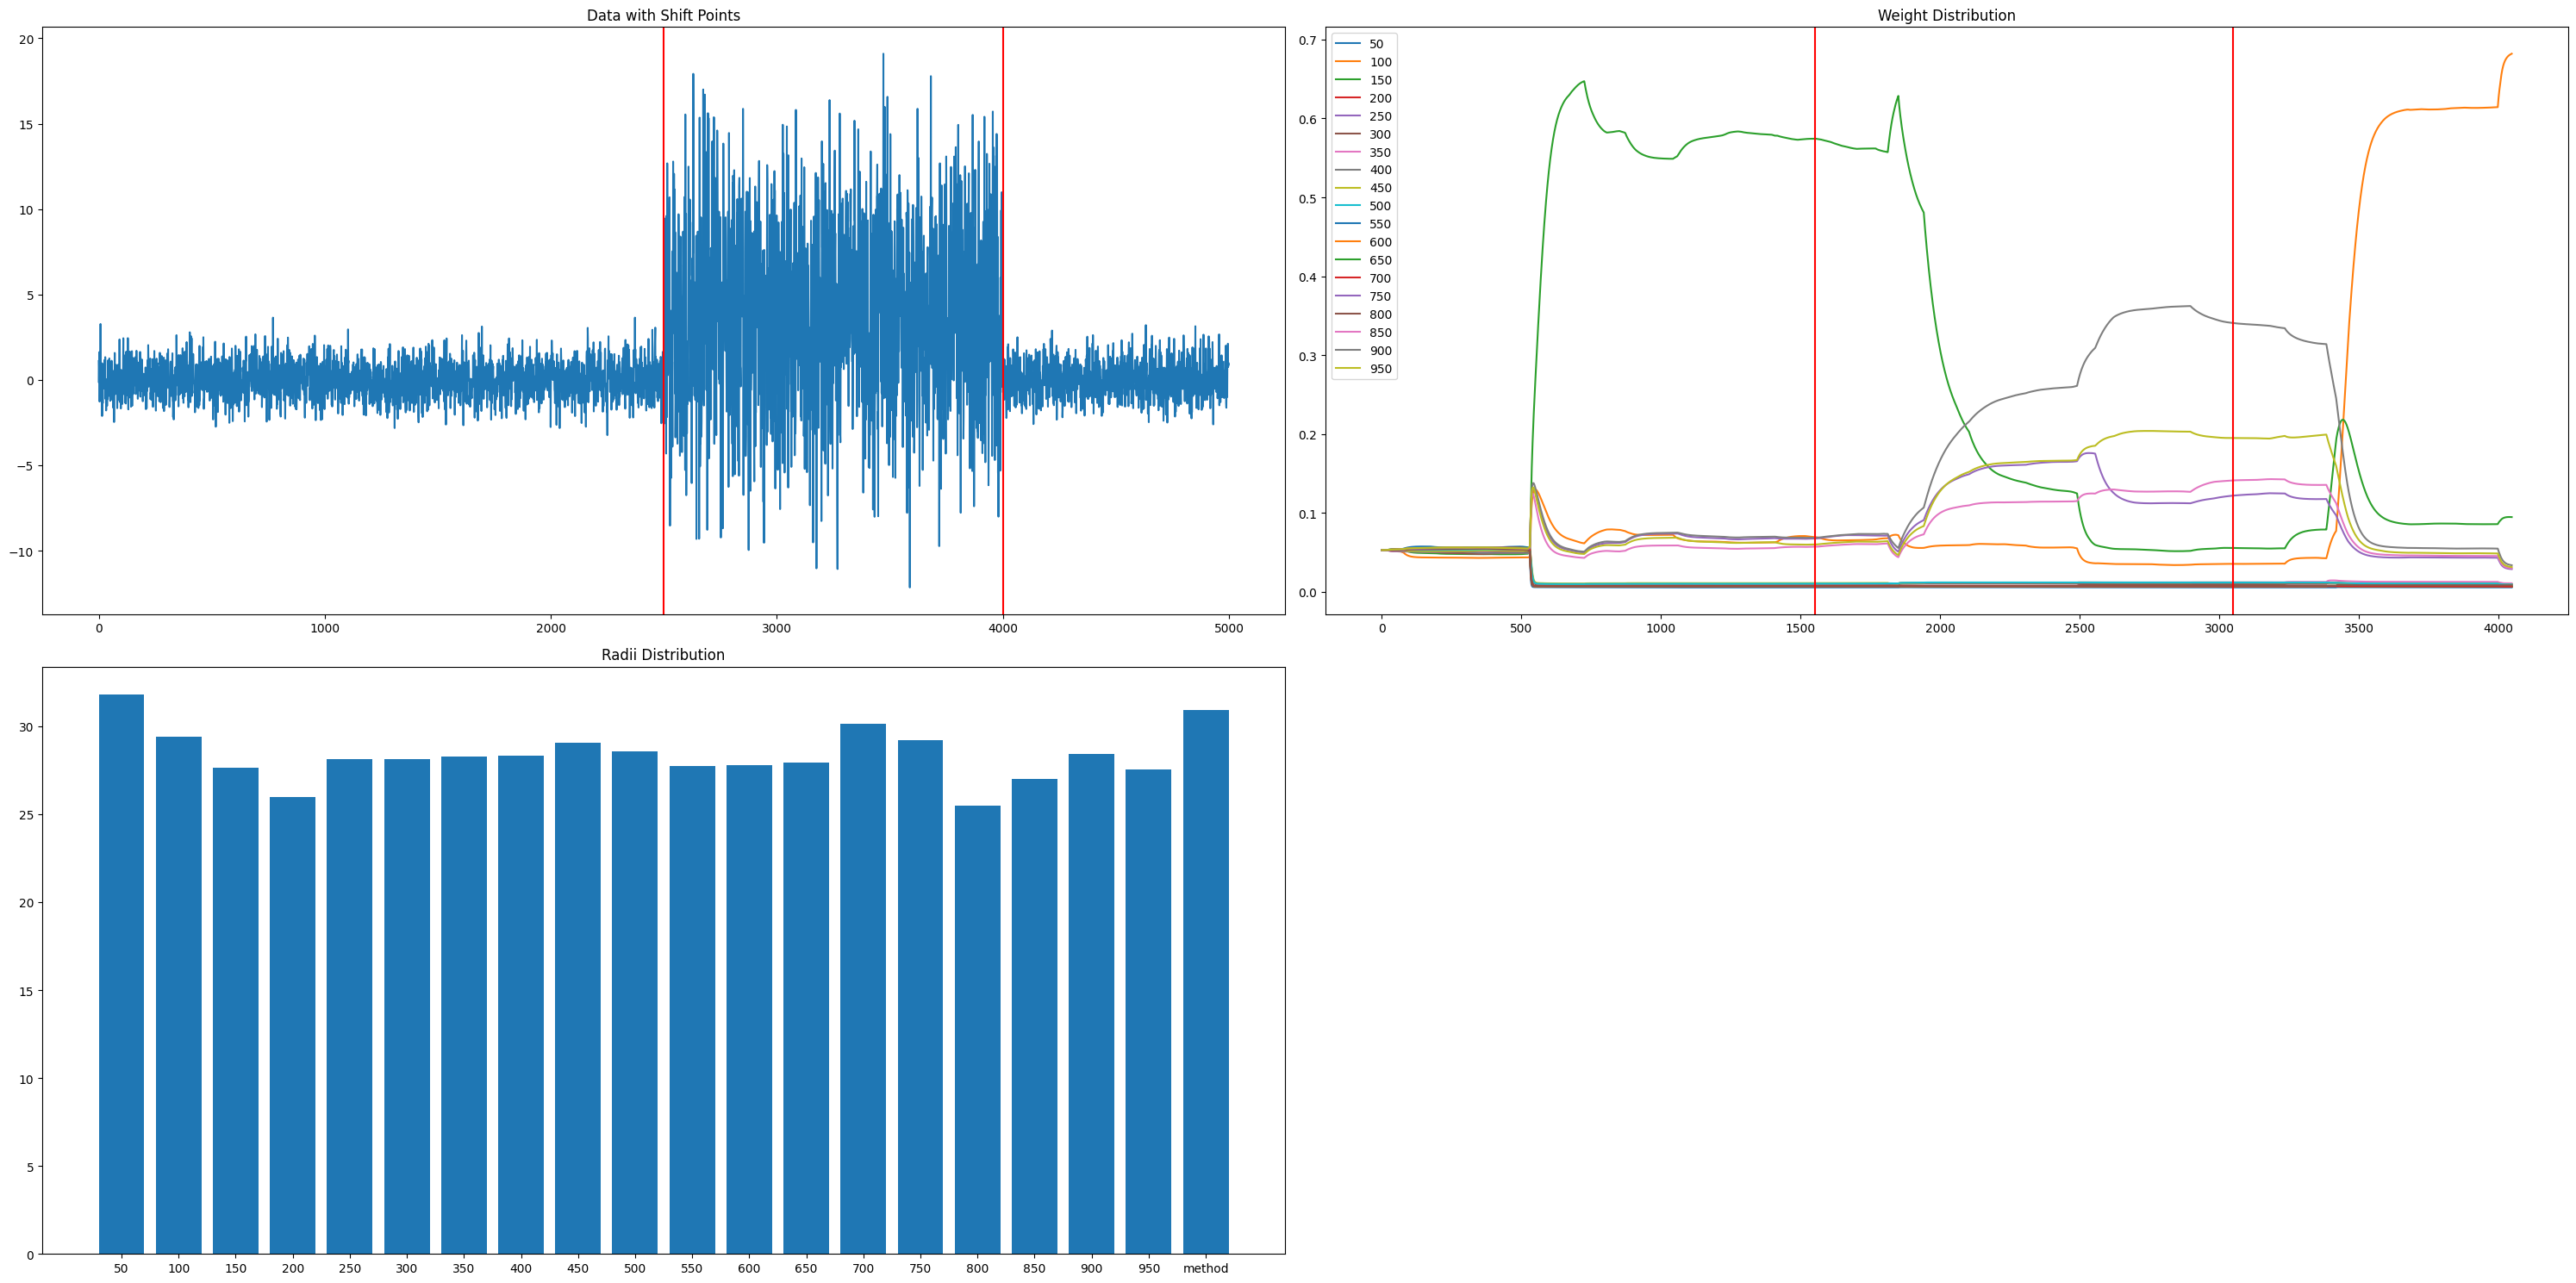

Section: 0 ----------------------------------------------------------------------------------------------------
1550
[(np.int64(0), np.float64(0.0075441863695834095)), (np.int64(1), np.float64(0.010303475430619031)), (np.int64(2), np.float64(0.05383016883045705)), (np.int64(3), np.float64(0.006046787183770129)), (np.int64(4), np.float64(0.0005573281496412544)), (np.int64(6), np.float64(0.00021973939220786167)), (np.int64(7), np.float64(4.604411993774174e-05)), (np.int64(10), np.float64(0.0011190456492974606)), (np.int64(15), np.float64(2.945461871228873e-05))]


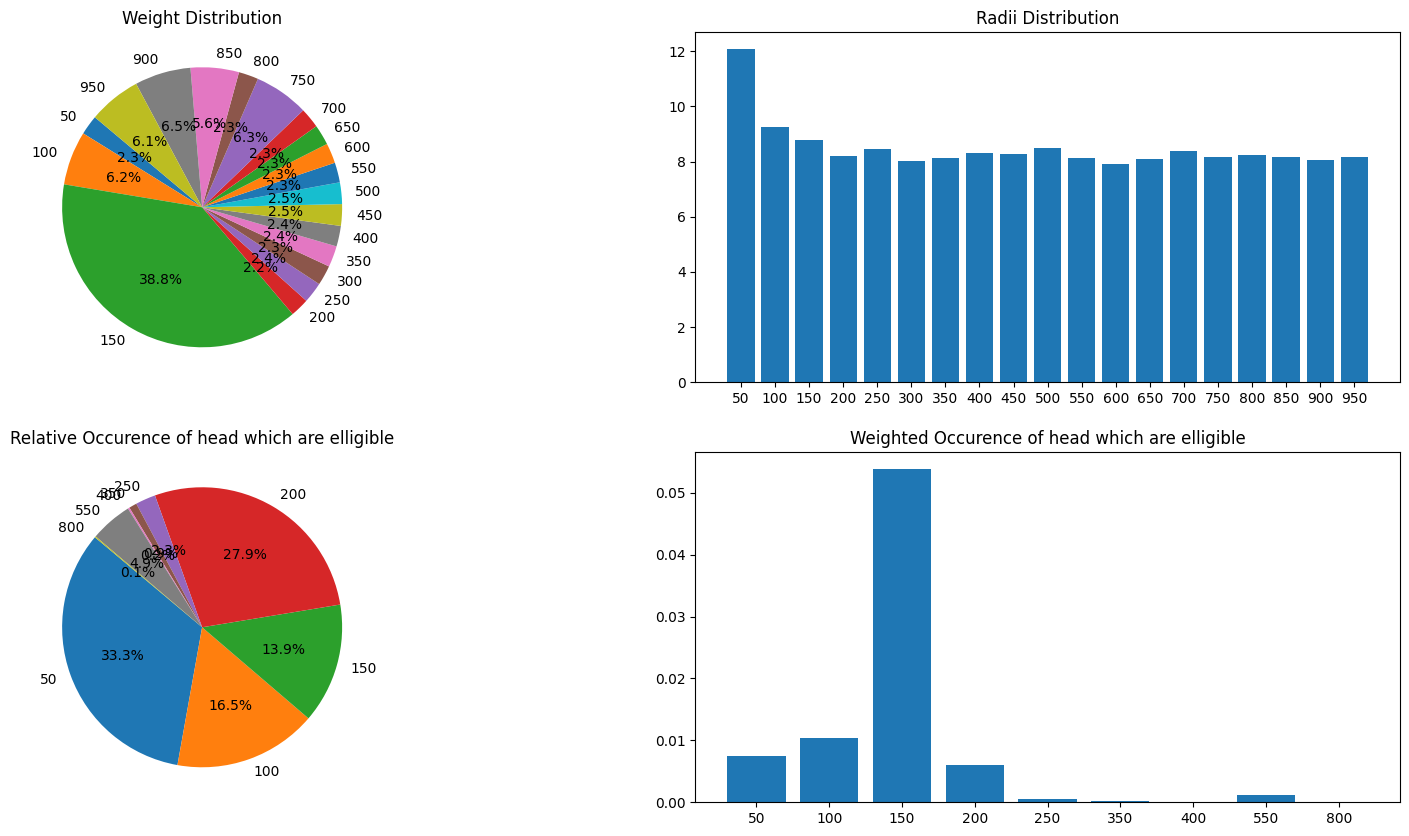

Section: 1 ----------------------------------------------------------------------------------------------------
1500
[(np.int64(0), np.float64(0.002702427409149707)), (np.int64(3), np.float64(0.0029497783828523476)), (np.int64(10), np.float64(0.00027343282838871065))]


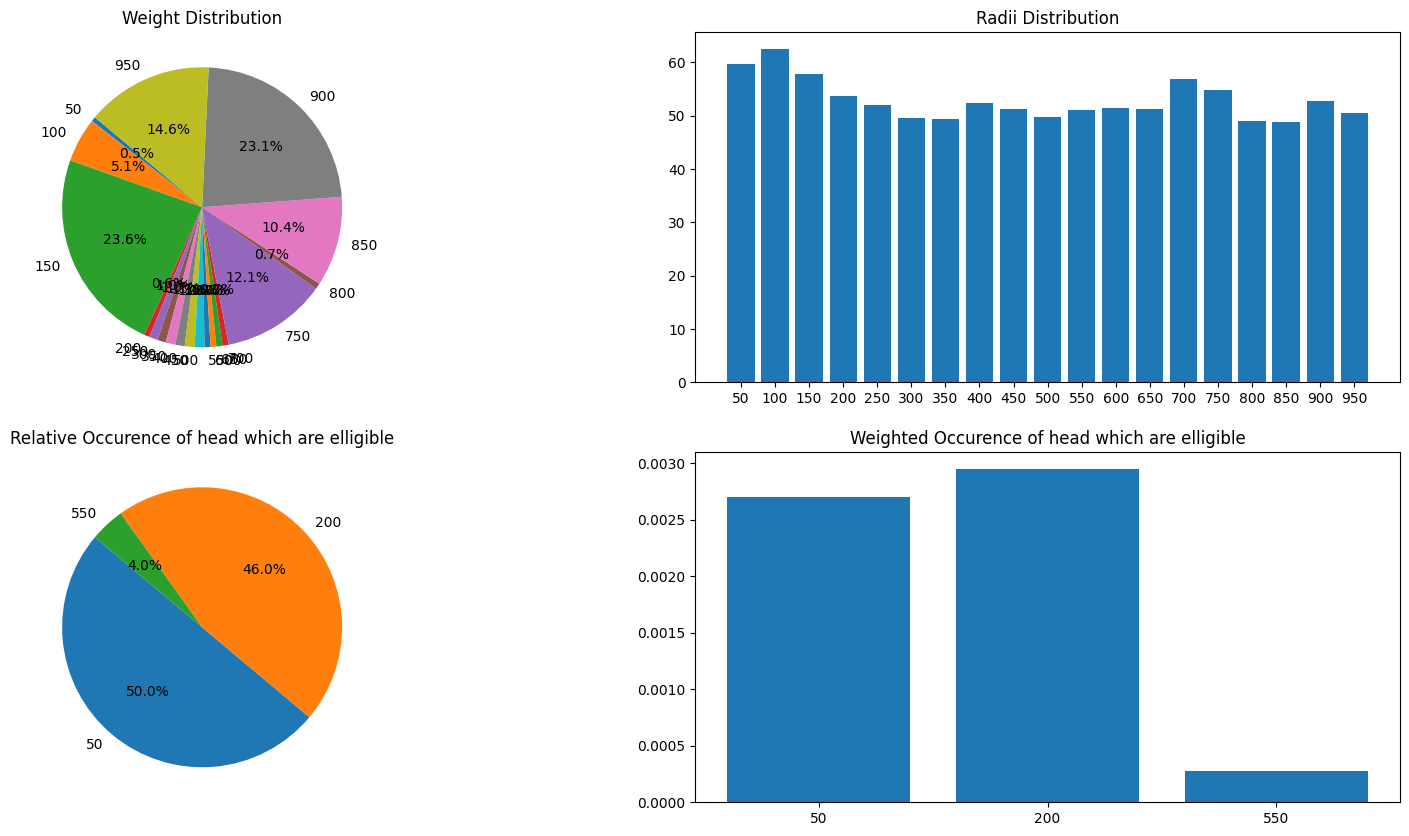

Section: 2 ----------------------------------------------------------------------------------------------------
998
[(np.int64(0), np.float64(0.002700399604604539)), (np.int64(3), np.float64(0.003058930464231263)), (np.int64(10), np.float64(0.0001669000698134299))]


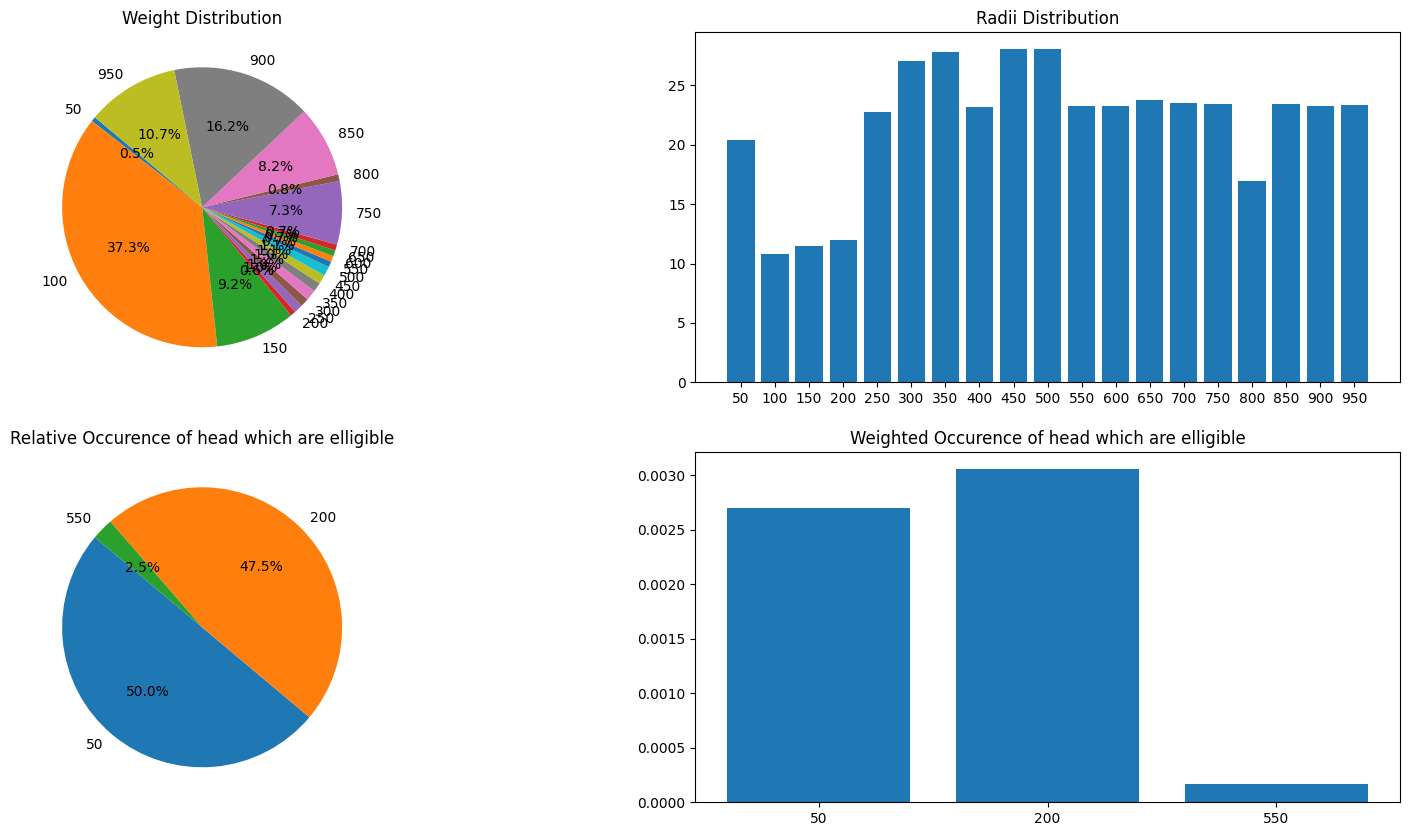

In [161]:
analyse_MACI(shift_data[0], first_MACI().MACI, [*range(50, 1000, 50)], [int(length*x) for x in shift_points], (3*(10**-5), 0.05), 2)

As we are still using the weights from the before with no past - present bias we are seeing low adaptibilty still. I hypothesis if we make it so that MACI chooses which heads to include in its sample based off of the recent performance then this should address the issues.


In [193]:
class second_MACI(AdaptiveCP):
    def set_loss(self, optimal_set, given_set):
        # If the optimal set is somehow 0, then we will return the given set.
        if optimal_set == 0:
            return 0
        else:
            val = (optimal_set - given_set) / optimal_set
         
        if val < 0:
            return (self.coverage_target) * (-1* val)
        else:
            return (1 - self.coverage_target) * val
    
    def set_loss_vectorize(self):
         return np.vectorize(self.set_loss)
    
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
        xpred, y = timeseries_data
        alpha_t_list = [self.coverage_target]

        All_scores = self.score_function(xpred, y)

        err_t_list = []
        conformal_sets_list = []
        
        for i in range(start_point, len(All_scores)):
            Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
            conformal_sets_list.append(Coverage_t)

            # We calculate the optimal B_t.

            yield Coverage_t

            error_t = AdaptiveCP.err_t(y[i], Coverage_t)
            err_t_list.append(error_t)

            alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        return False
    
    def MACI(self, timeseries_data: tuple, interval_candidates: np.array = None, k: int = 5, nu_sigma: tuple = (10**-2, 0.05), gamma: float = 0.05, title: str = None):
        nu, sigma = nu_sigma
        Set_loss = self.set_loss_vectorize()

        # Base level
        _, y = timeseries_data
        err_t_list = []
        conformal_sets_list = []
        all_interval_weights = []
        chosen_interval_index = []
        radii_list = []
        
        if interval_candidates is None:
            interval_candidates = np.array(range(50, 1000, 100))

        # Set_loss relevant
        optimal_radius_list = []
        chosen_radius_list = []
        all_head_radii = []

        # MACI relevant

        loss_at_step_list = np.array(np.ones(len(interval_candidates)))
        eligible_heads_list = []
        eligible_absolute_weight_list = []
        relative_eligible_final_weight_list = []

        culmative_loss = np.zeros(len(interval_candidates)) # hoping to remove

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.ones(len(interval_candidates))
        active_k = [*range(k)] # On the first step we will simply take the first k heads.
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
                
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here
            
            # Here we choose the set of heads which we will make our choice from.
            eligible_heads = np.take(head_sets, active_k)
            eligible_weights = np.take(interval_weights, active_k)
            normalised_eligible_weights = eligible_weights/sum(eligible_weights)

            # Appending the eligible weights to the list.
            eligible_absolute_weight_list.append(eligible_weights)
            relative_eligible_final_weight_list.append(normalised_eligible_weights)

            # Choosing which head to use.
            try:
                chosen_index = random.choices(active_k, weights=normalised_eligible_weights, k=1)[0] # Choosing the index of the head we wish to use.
                chosen_set = head_sets[chosen_index]
            except ValueError:
                print(all_interval_weights[-5:])
                raise ValueError('Interval probabilities are not normalised correctly.')
            

             # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) 
            
            head_set_radius = np.array(list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)))
            
            # Calculating the loss and updating culmative loss.
            loss_at_step = Set_loss(optimal_set_radius, head_set_radius)
            loss_at_step_list = np.vstack([loss_at_step_list, loss_at_step]) # Adding the loss to the list.

            culmative_loss += Set_loss(optimal_set_radius, head_set_radius)

            # Updating the active k.
            recent_loss_performers = loss_at_step_list[-200:].sum(axis=0) # Summing the last 50 losses.
            active_k = np.argsort(recent_loss_performers)[:k] # Getting the argument of the k smallest weights
            eligible_heads_list.append(active_k)
            
            # Updating the weights.
            rc_scale = 10
            # just off of recent loss
            new_weights = interval_weights * np.exp(-1 * nu * (1*recent_loss_performers + culmative_loss)) # We want to consider the recent performance more.
            final_weights = new_weights*(1-sigma) + (new_weights.mean() *sigma)
            
            interval_weights = final_weights/sum(final_weights)


            # Incrementing the i-count
            i_count+=1

            # Appending the results to the lists.
            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(chosen_index)
            err_t_list.append(err_true)
            radii_list.append(head_set_radius)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) 
            optimal_radius_list.append(optimal_set_radius)
            all_head_radii.append(head_set_radius)
            all_interval_weights.append(interval_weights)

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0])/2 for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'safe AwACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'all_head_radii': all_head_radii,
                'all_weights': all_interval_weights,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50,
                'radii_list': radii_list,
                'loss_at_step_list': loss_at_step_list,
                'eligible_heads_list': eligible_heads_list,
                'eligible_absolute_weight_list': eligible_absolute_weight_list,
                'relative_eligible_final_weight_list': relative_eligible_final_weight_list
                
            }


In [194]:
M2 = second_MACI(0.1)
result = M2.MACI(shift_data[0], k=3)

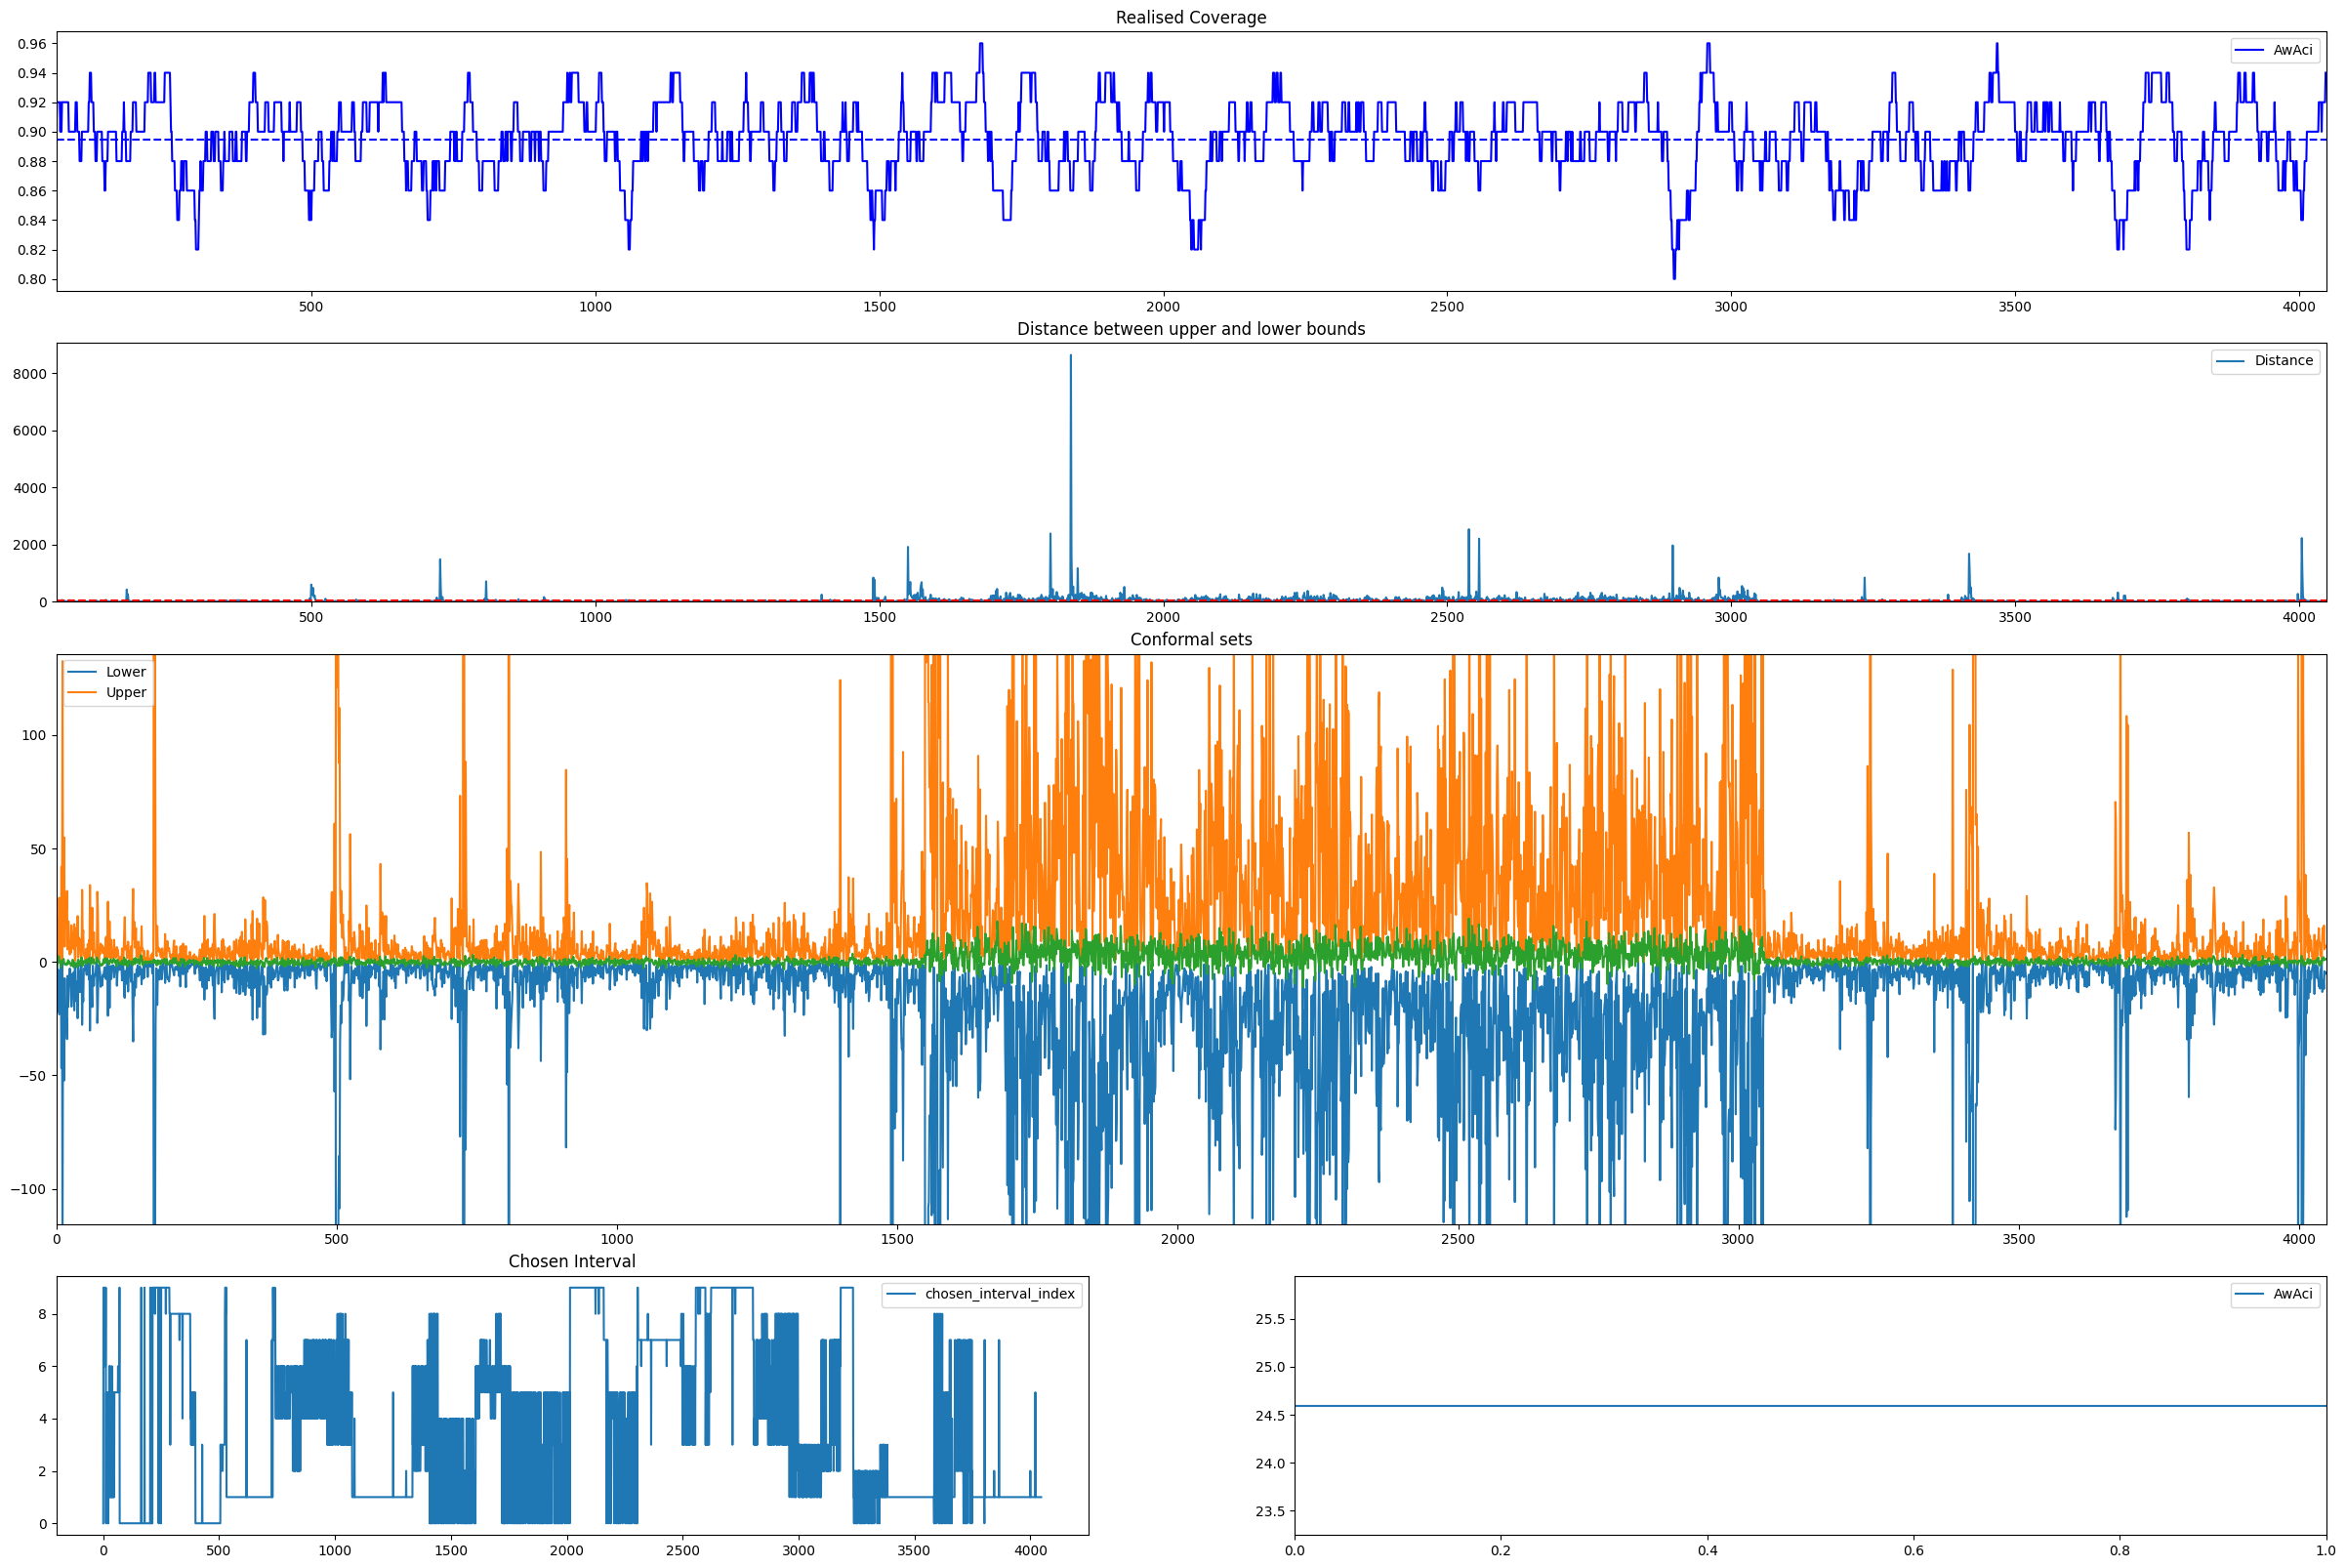

In [195]:
ACP_plots.AwDT_plot(result, shift_data[0])

0.8969492373093273


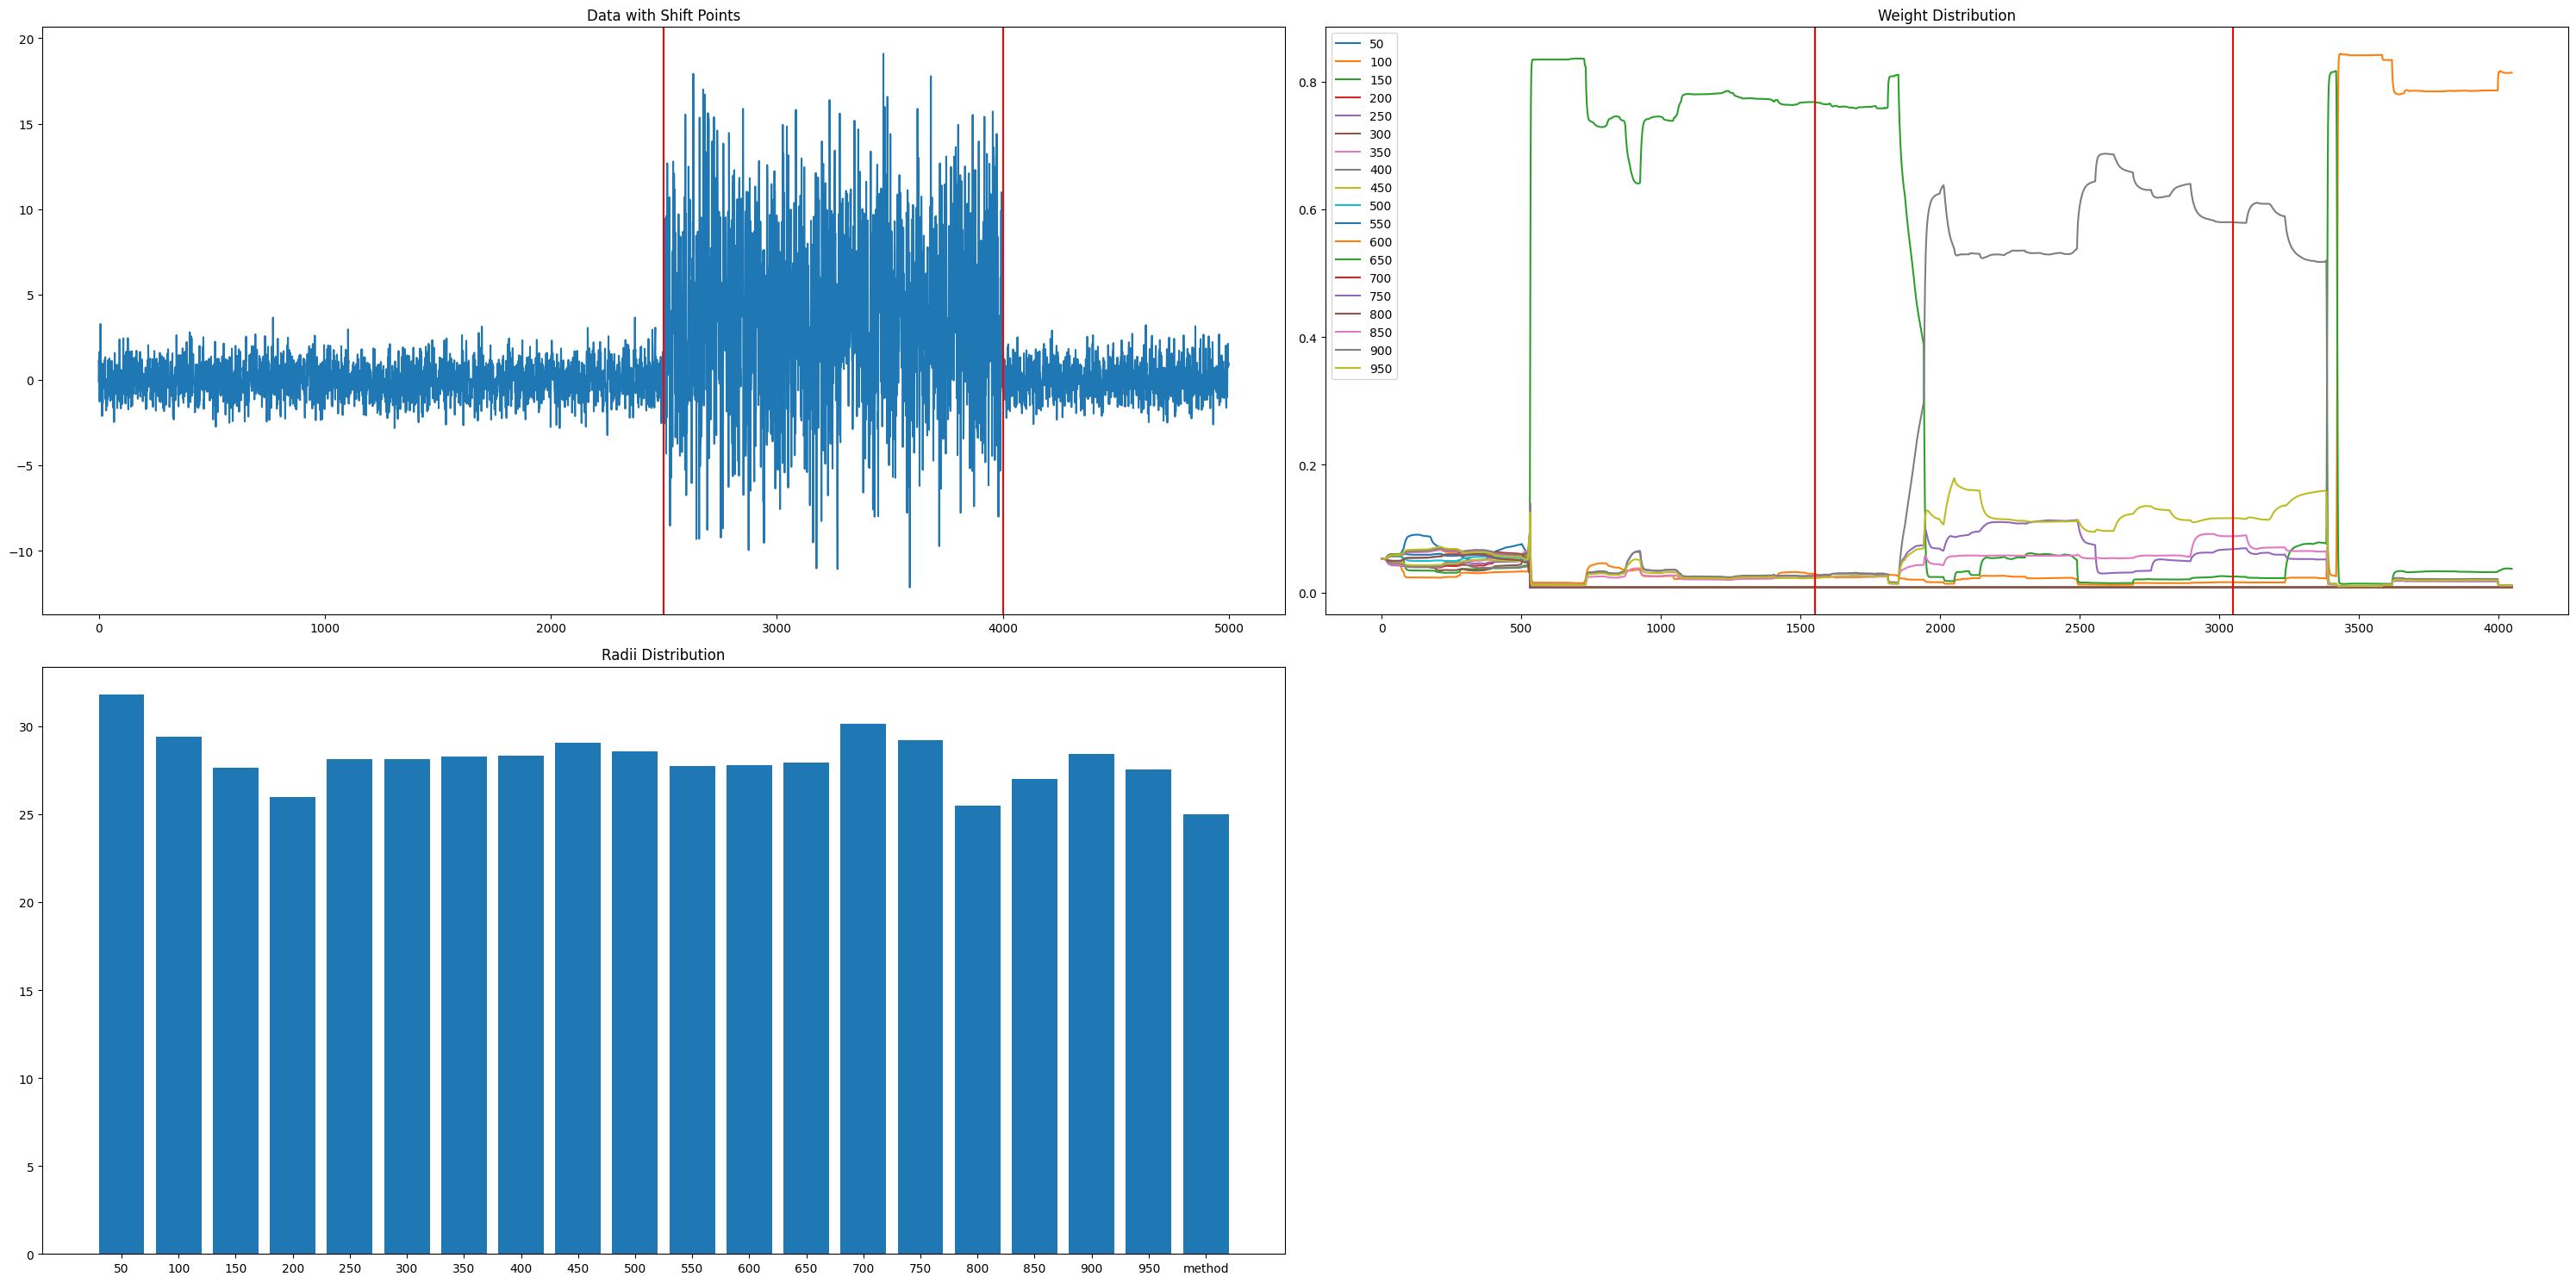

Section: 0 ----------------------------------------------------------------------------------------------------
1550
[(np.int64(0), np.float64(0.0025099206591816135)), (np.int64(1), np.float64(0.0012979002579039725)), (np.int64(2), np.float64(0.05372195351052133)), (np.int64(3), np.float64(0.0020901072512102803)), (np.int64(4), np.float64(0.0010242896821296274)), (np.int64(5), np.float64(0.001475716728551056)), (np.int64(6), np.float64(0.0011722249157085553)), (np.int64(8), np.float64(0.0002243225335163875)), (np.int64(9), np.float64(0.0010473171216008677)), (np.int64(10), np.float64(0.0017492930072835976)), (np.int64(11), np.float64(0.0026261896945791877)), (np.int64(12), np.float64(0.0016584647911750126)), (np.int64(13), np.float64(8.528527700985457e-05)), (np.int64(14), np.float64(0.0020660571408364645)), (np.int64(15), np.float64(0.0003135441958660646)), (np.int64(16), np.float64(0.0007798738843686864)), (np.int64(17), np.float64(0.0019880299854551434)), (np.int64(18), np.float64(0

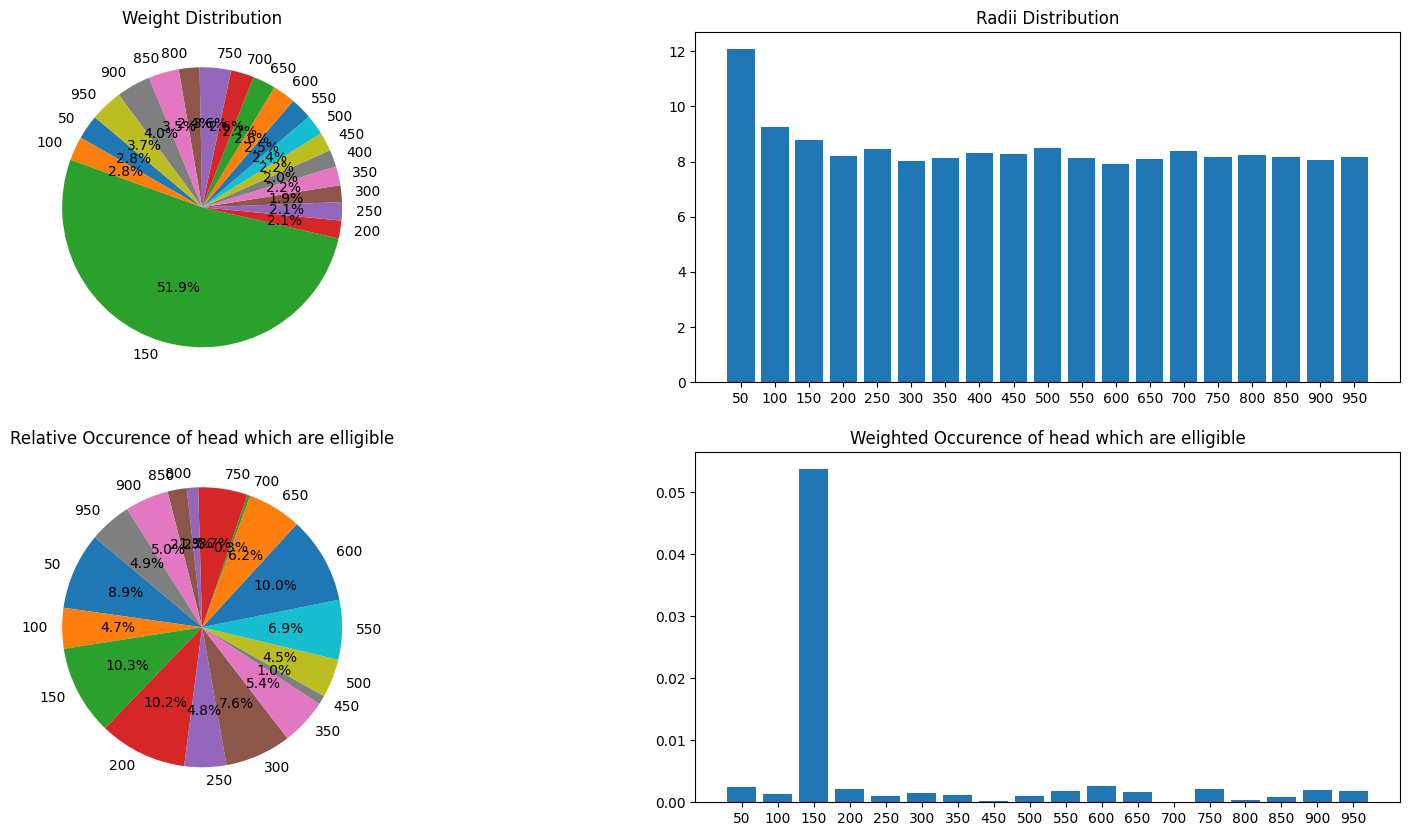

Section: 1 ----------------------------------------------------------------------------------------------------
1500
[(np.int64(0), np.float64(0.0006833986014147103)), (np.int64(1), np.float64(0.00029705005311347687)), (np.int64(2), np.float64(0.004129804812769197)), (np.int64(3), np.float64(0.00019046249062535078)), (np.int64(4), np.float64(0.00010332253709164141)), (np.int64(5), np.float64(0.00037627379060696314)), (np.int64(6), np.float64(0.0008273303180642495)), (np.int64(7), np.float64(0.00018249887190577592)), (np.int64(8), np.float64(0.0002108957899294579)), (np.int64(9), np.float64(0.0008939338223913731)), (np.int64(10), np.float64(0.0007149606994891222)), (np.int64(11), np.float64(0.0005619751019775423)), (np.int64(12), np.float64(0.000648665755158512)), (np.int64(13), np.float64(0.00041121794284033653)), (np.int64(14), np.float64(0.003922849537489902)), (np.int64(15), np.float64(0.00012210541166116258)), (np.int64(16), np.float64(0.002879948974007938)), (np.int64(17), np.floa

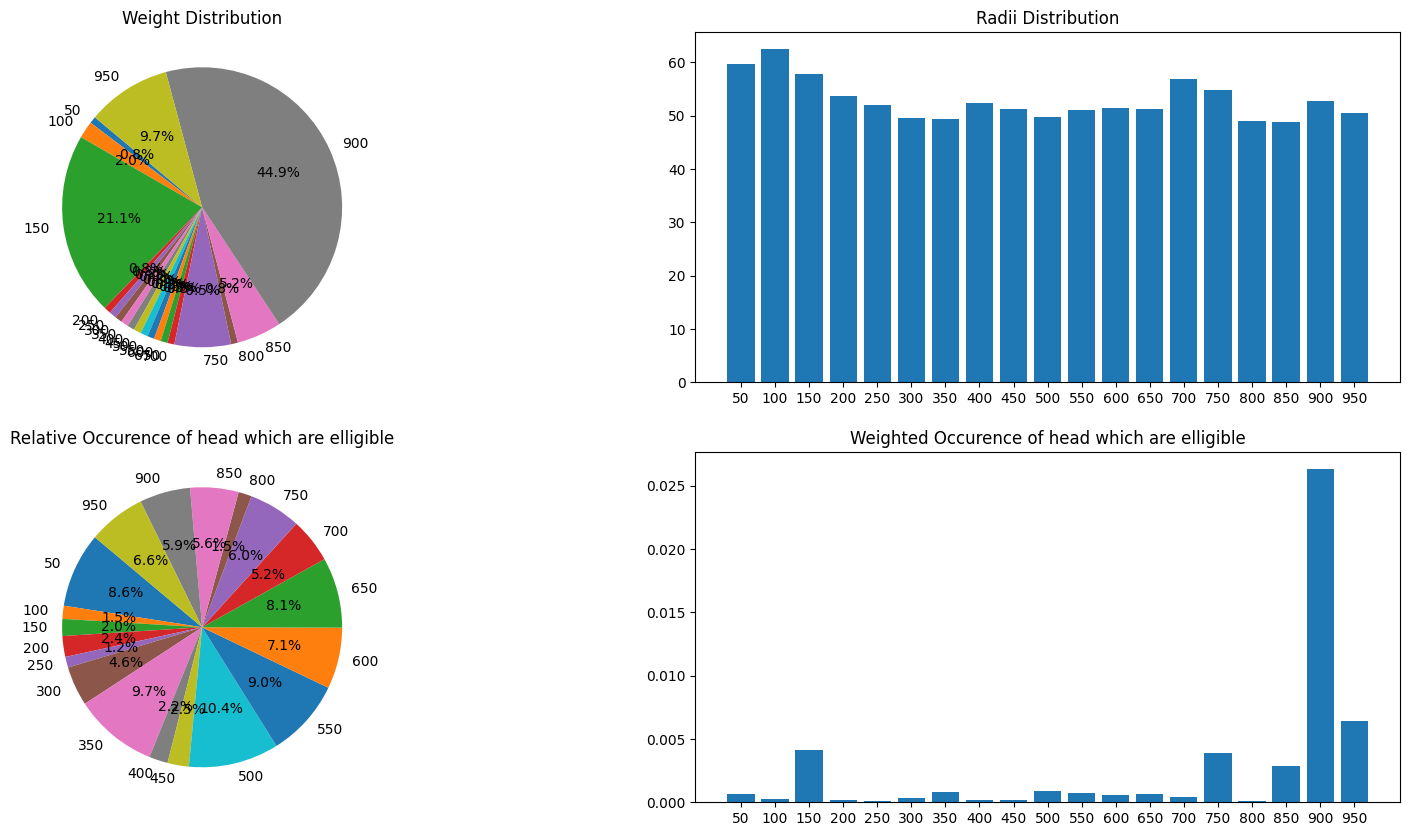

Section: 2 ----------------------------------------------------------------------------------------------------
998
[(np.int64(0), np.float64(0.000834223079250677)), (np.int64(1), np.float64(0.07198088341509976)), (np.int64(2), np.float64(0.002949333783976317)), (np.int64(3), np.float64(0.0013808618719153894)), (np.int64(4), np.float64(0.0011616397106229421)), (np.int64(5), np.float64(0.0008732090795881034)), (np.int64(6), np.float64(5.194930409866904e-05)), (np.int64(7), np.float64(0.00016097371989314753)), (np.int64(8), np.float64(0.00015043049417770812)), (np.int64(10), np.float64(4.5097213798990175e-05)), (np.int64(14), np.float64(0.0008232793671107008)), (np.int64(15), np.float64(0.0015563536196987683)), (np.int64(17), np.float64(0.00026992299368108546)), (np.int64(18), np.float64(0.000744650760874089))]


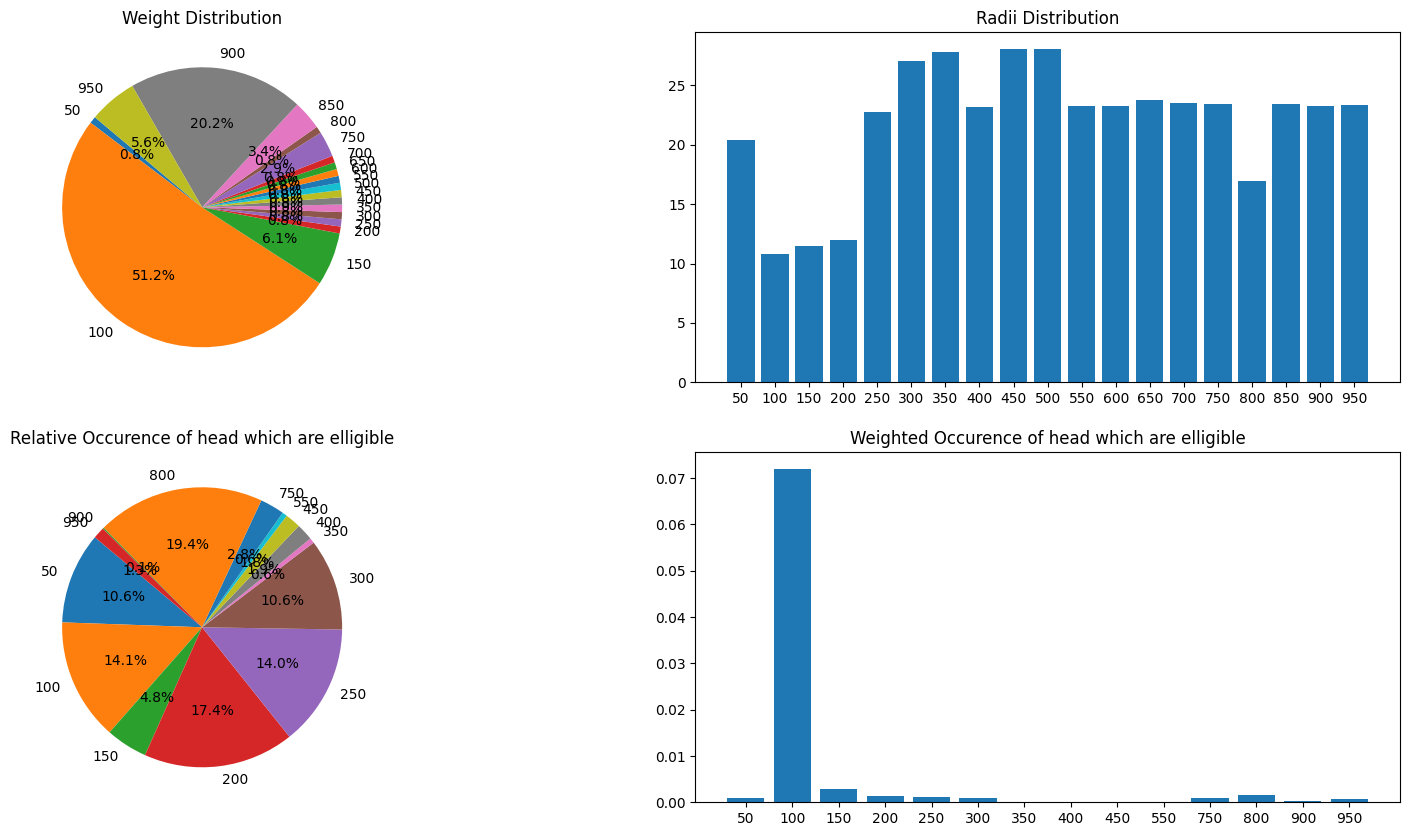

In [197]:
analyse_MACI(shift_data[0], second_MACI().MACI, [*range(50, 1000, 50)], [int(length*x) for x in shift_points], (3*(10**-4), 0.15), 3)

0.8964241060265066


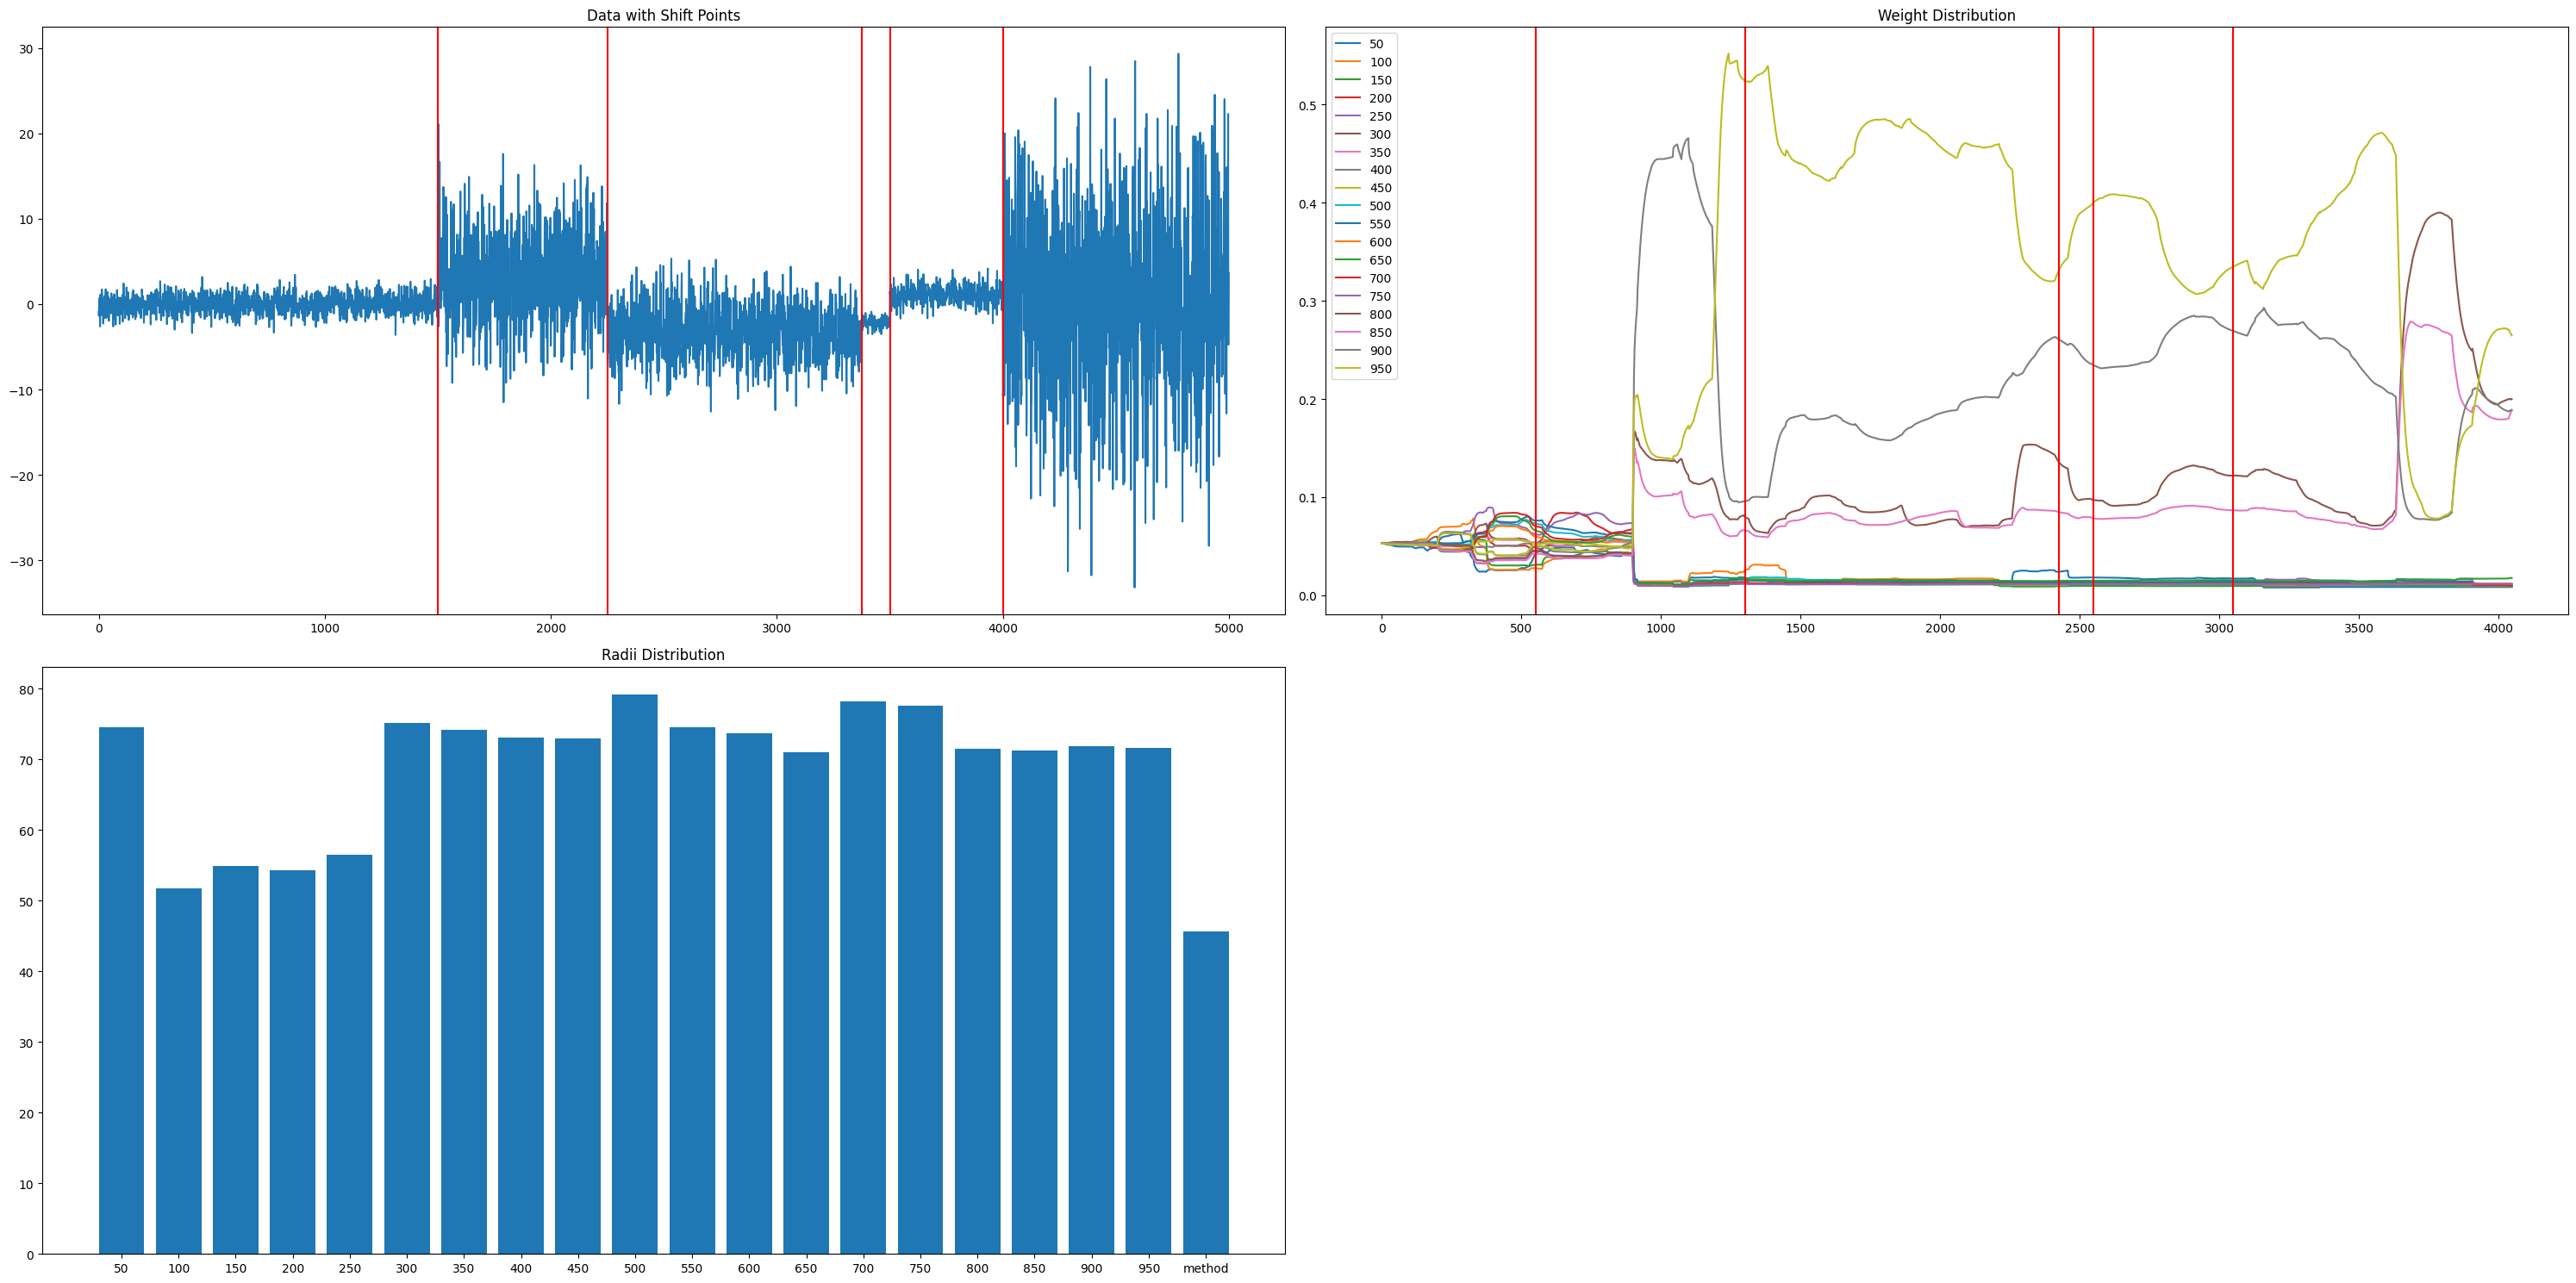

Section: 0 ----------------------------------------------------------------------------------------------------
550
[(np.int64(0), np.float64(0.0008358986967522274)), (np.int64(1), np.float64(0.02066881308631182)), (np.int64(3), np.float64(0.0027560126238290166)), (np.int64(4), np.float64(0.008829499888550776)), (np.int64(5), np.float64(0.0036453101437594476)), (np.int64(6), np.float64(0.0030161150653211237)), (np.int64(10), np.float64(0.001110455282980195)), (np.int64(13), np.float64(0.014218155143123459))]


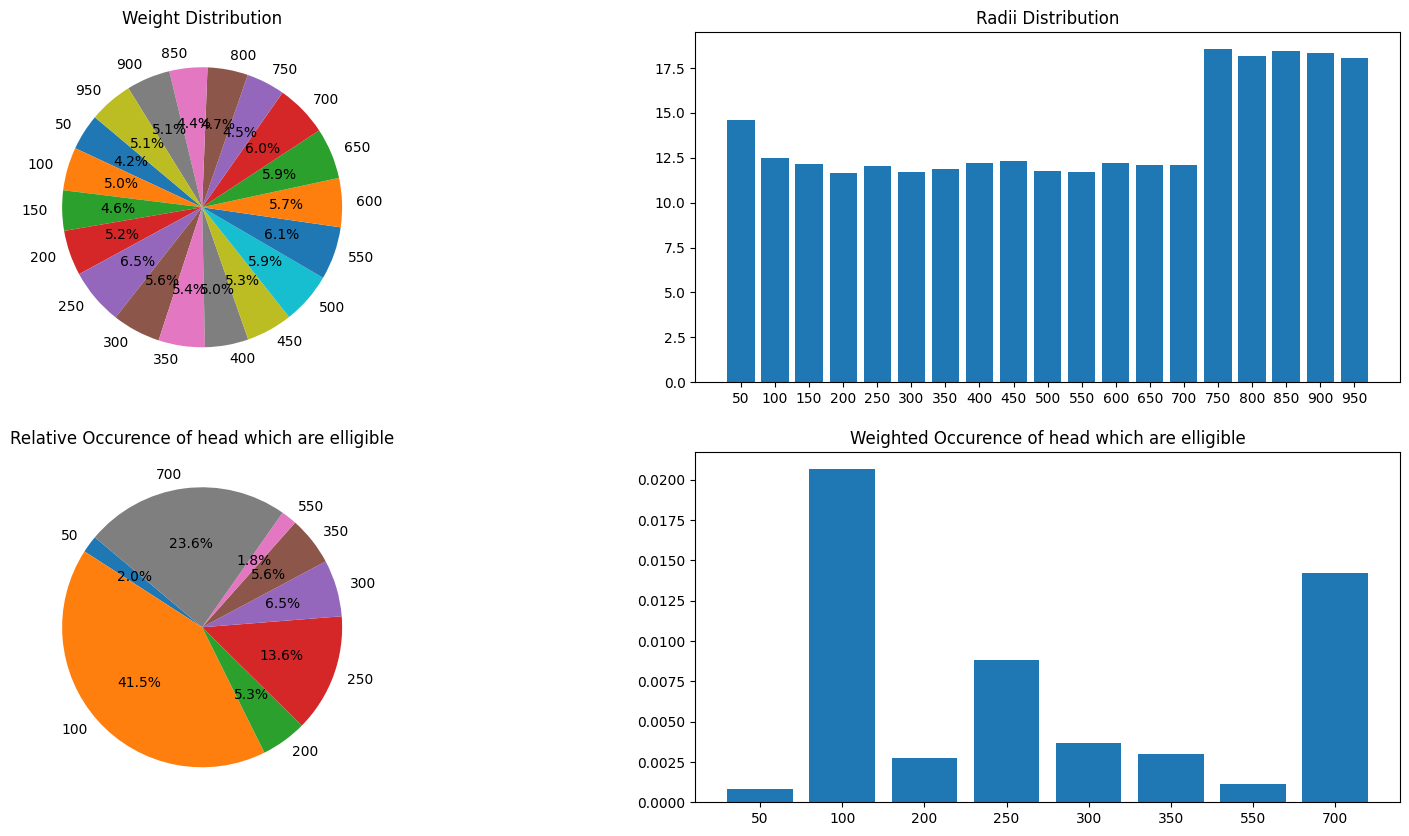

Section: 1 ----------------------------------------------------------------------------------------------------
750
[(np.int64(0), np.float64(0.0066982214448103134)), (np.int64(1), np.float64(0.010362828287508272)), (np.int64(2), np.float64(0.0007616269795261302)), (np.int64(3), np.float64(0.0009658292212092804)), (np.int64(4), np.float64(0.000167959825774244)), (np.int64(17), np.float64(0.05674018810087443)), (np.int64(18), np.float64(0.011153232646912061))]


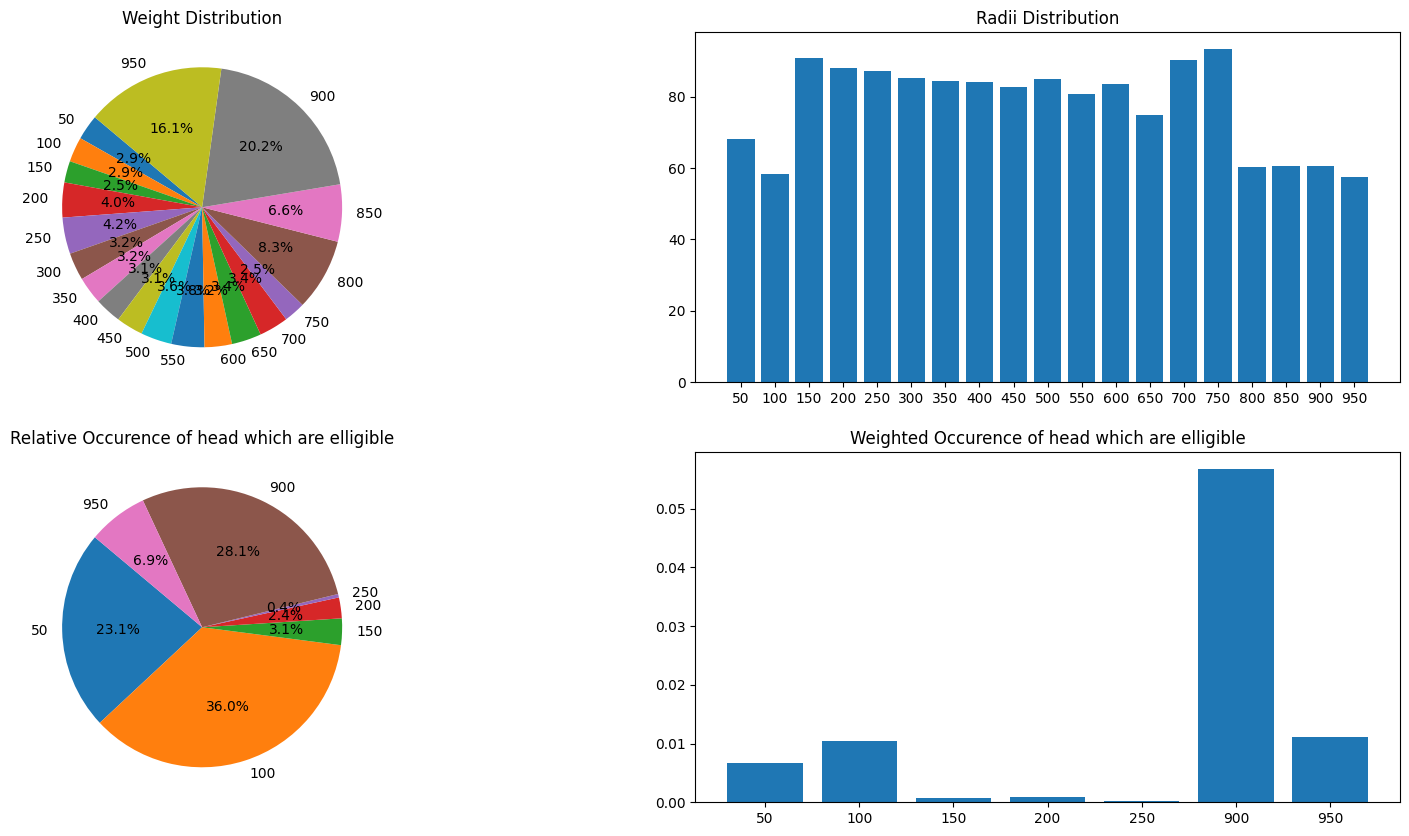

Section: 2 ----------------------------------------------------------------------------------------------------
1125
[(np.int64(0), np.float64(0.0029624552516438994)), (np.int64(1), np.float64(0.0008904249881459562)), (np.int64(2), np.float64(0.00010429411590096057)), (np.int64(3), np.float64(0.0012425609368053544)), (np.int64(4), np.float64(0.001504910696033546)), (np.int64(9), np.float64(0.00017976639848349247)), (np.int64(10), np.float64(0.00022540542802092843)), (np.int64(14), np.float64(0.0005125384166907114)), (np.int64(15), np.float64(0.005601950533858639)), (np.int64(16), np.float64(0.013005490240168512)), (np.int64(17), np.float64(0.007647087578713032)), (np.int64(18), np.float64(0.09077998173301652))]


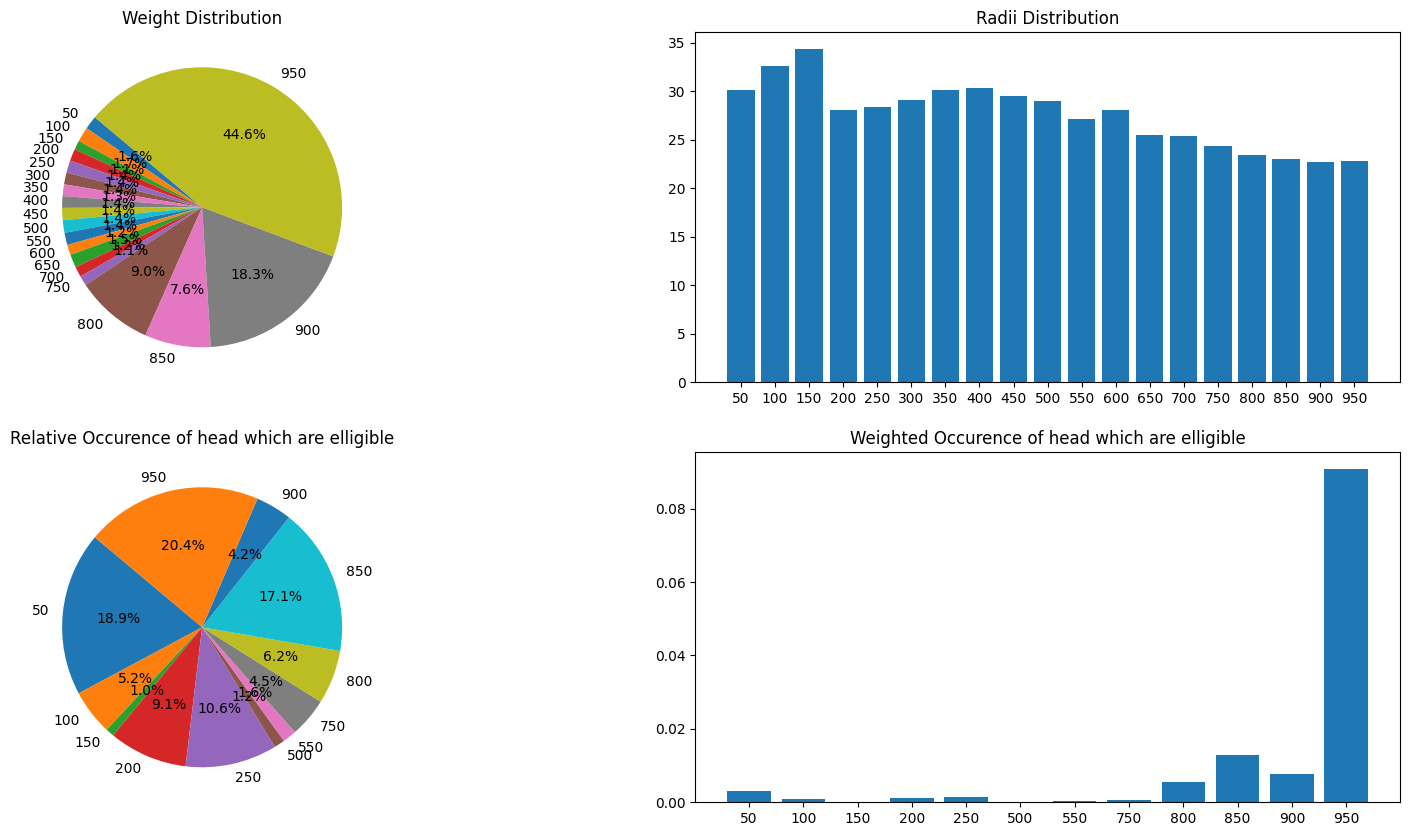

Section: 3 ----------------------------------------------------------------------------------------------------
125
[(np.int64(0), np.float64(0.019823586645620665))]


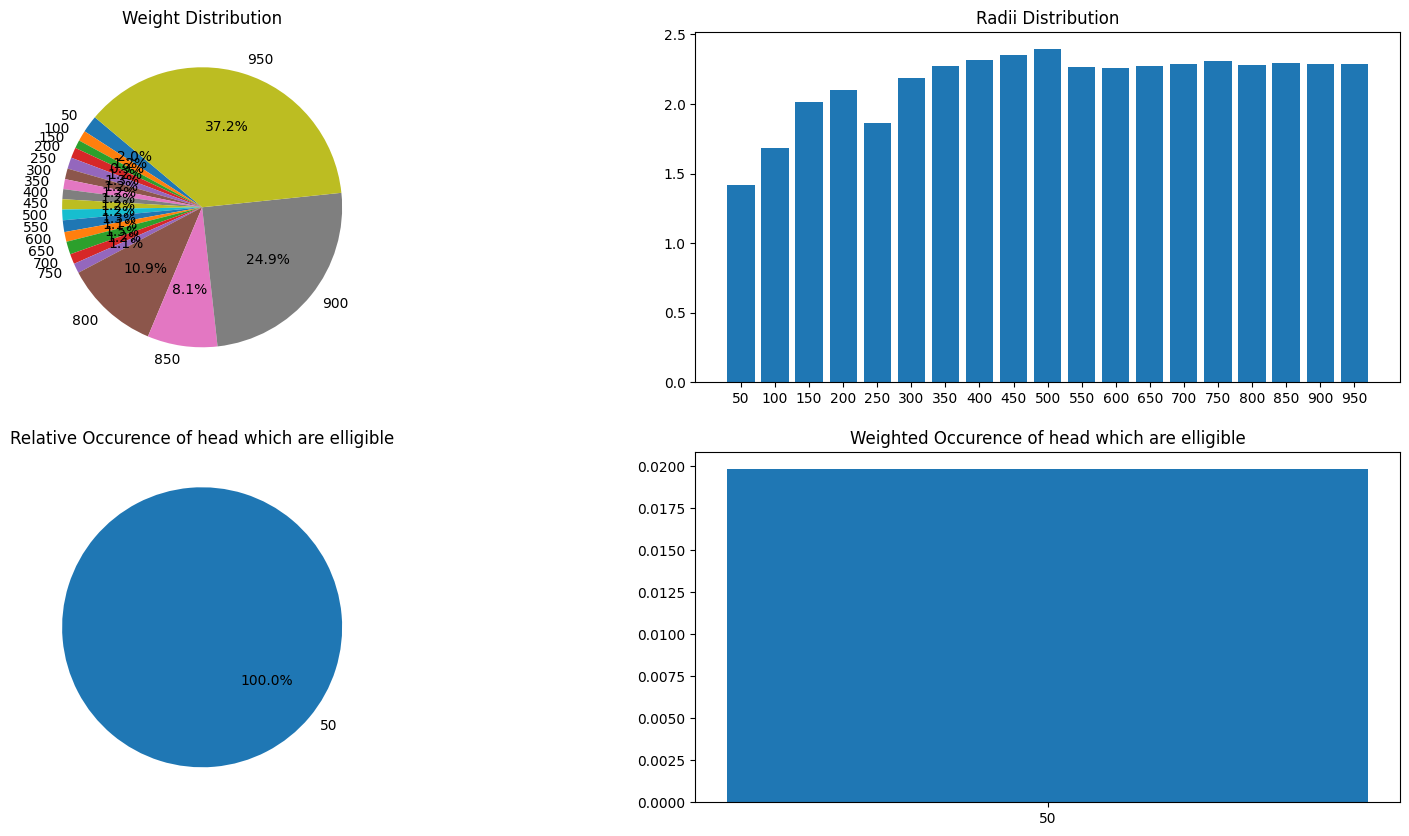

Section: 4 ----------------------------------------------------------------------------------------------------
500
[(np.int64(0), np.float64(0.0035253459810222695)), (np.int64(6), np.float64(0.001158848404485595)), (np.int64(7), np.float64(0.0009352382406042528)), (np.int64(10), np.float64(0.0020694133590426953)), (np.int64(11), np.float64(0.0003837751640109864)), (np.int64(12), np.float64(0.00018109922613407554)), (np.int64(13), np.float64(0.0014585889348562489)), (np.int64(15), np.float64(0.02957584199234146)), (np.int64(17), np.float64(0.0072032798585797185))]


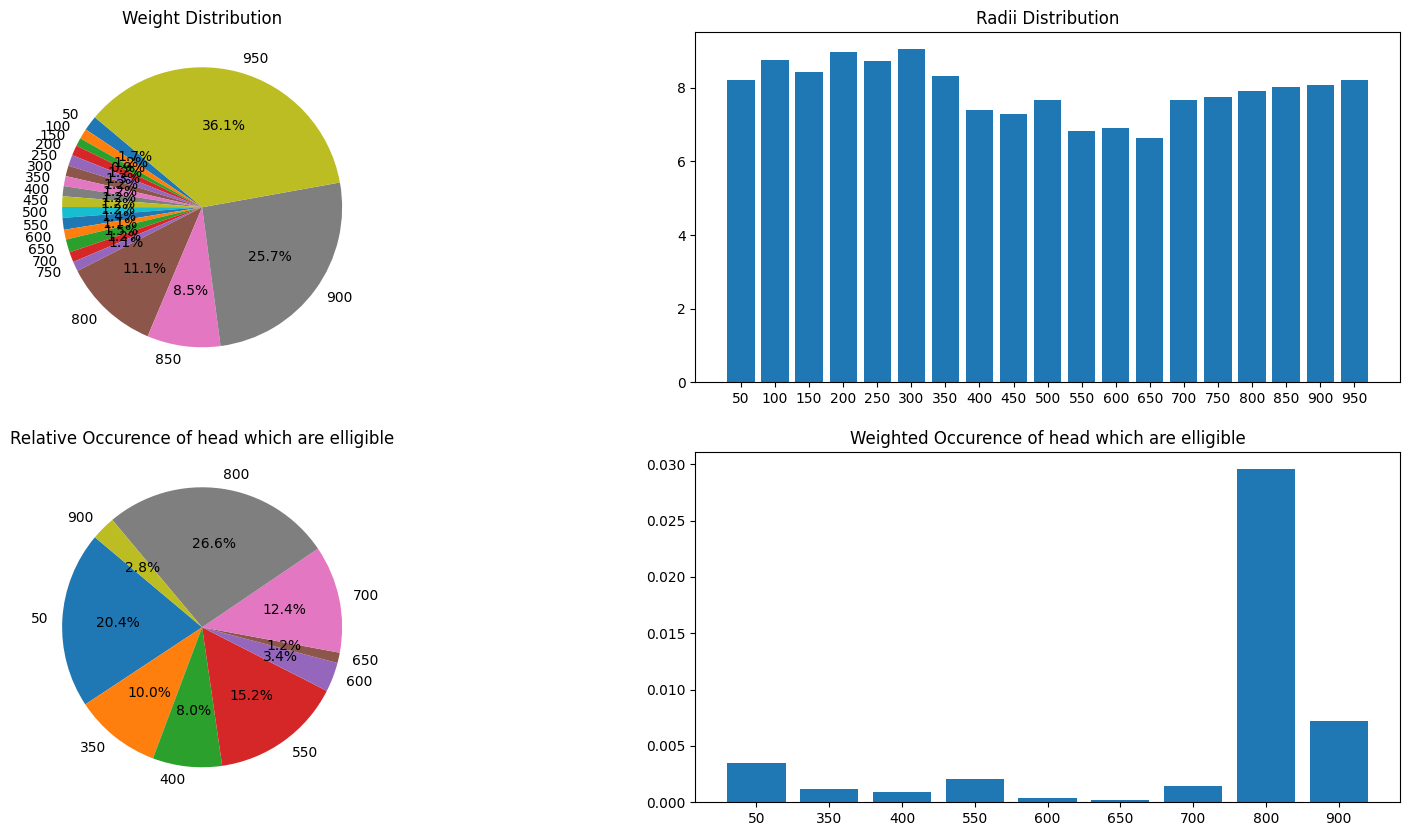

Section: 5 ----------------------------------------------------------------------------------------------------
998
[(np.int64(0), np.float64(0.0005810975835709271)), (np.int64(2), np.float64(0.002204636316691778)), (np.int64(3), np.float64(0.0014728924899018933)), (np.int64(4), np.float64(0.005300272834016568)), (np.int64(12), np.float64(0.0035476681528806347)), (np.int64(13), np.float64(0.00012859432058903508))]


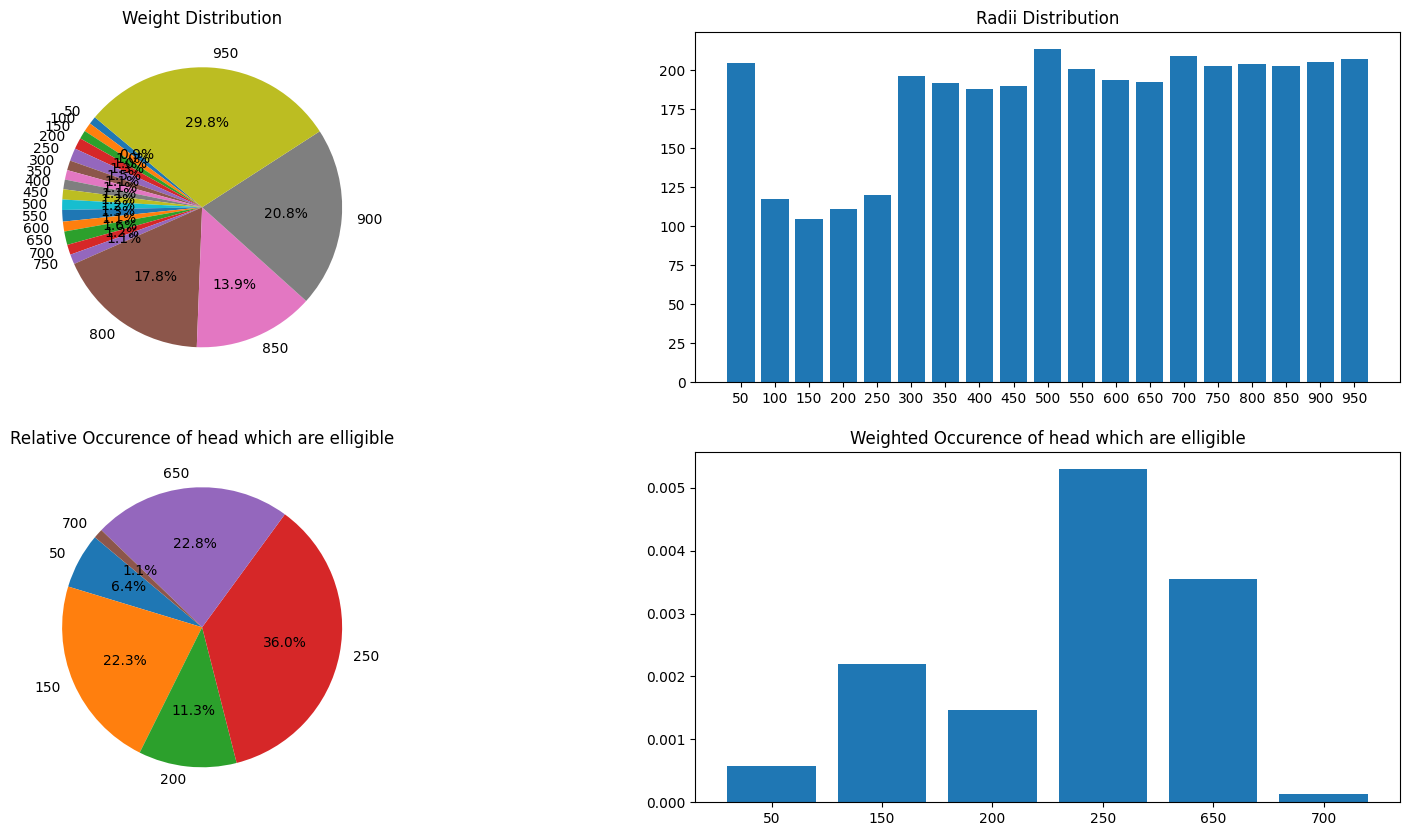

In [212]:
analyse_MACI(shift_data2[0], second_MACI().MACI, [*range(50, 1000, 50)], [int(length*x) for x in shift_points2], (3*(10**-4), 0.15), 1)

In [199]:
stock_data = ACP_data.stock_data(10)


0.8903099173553719


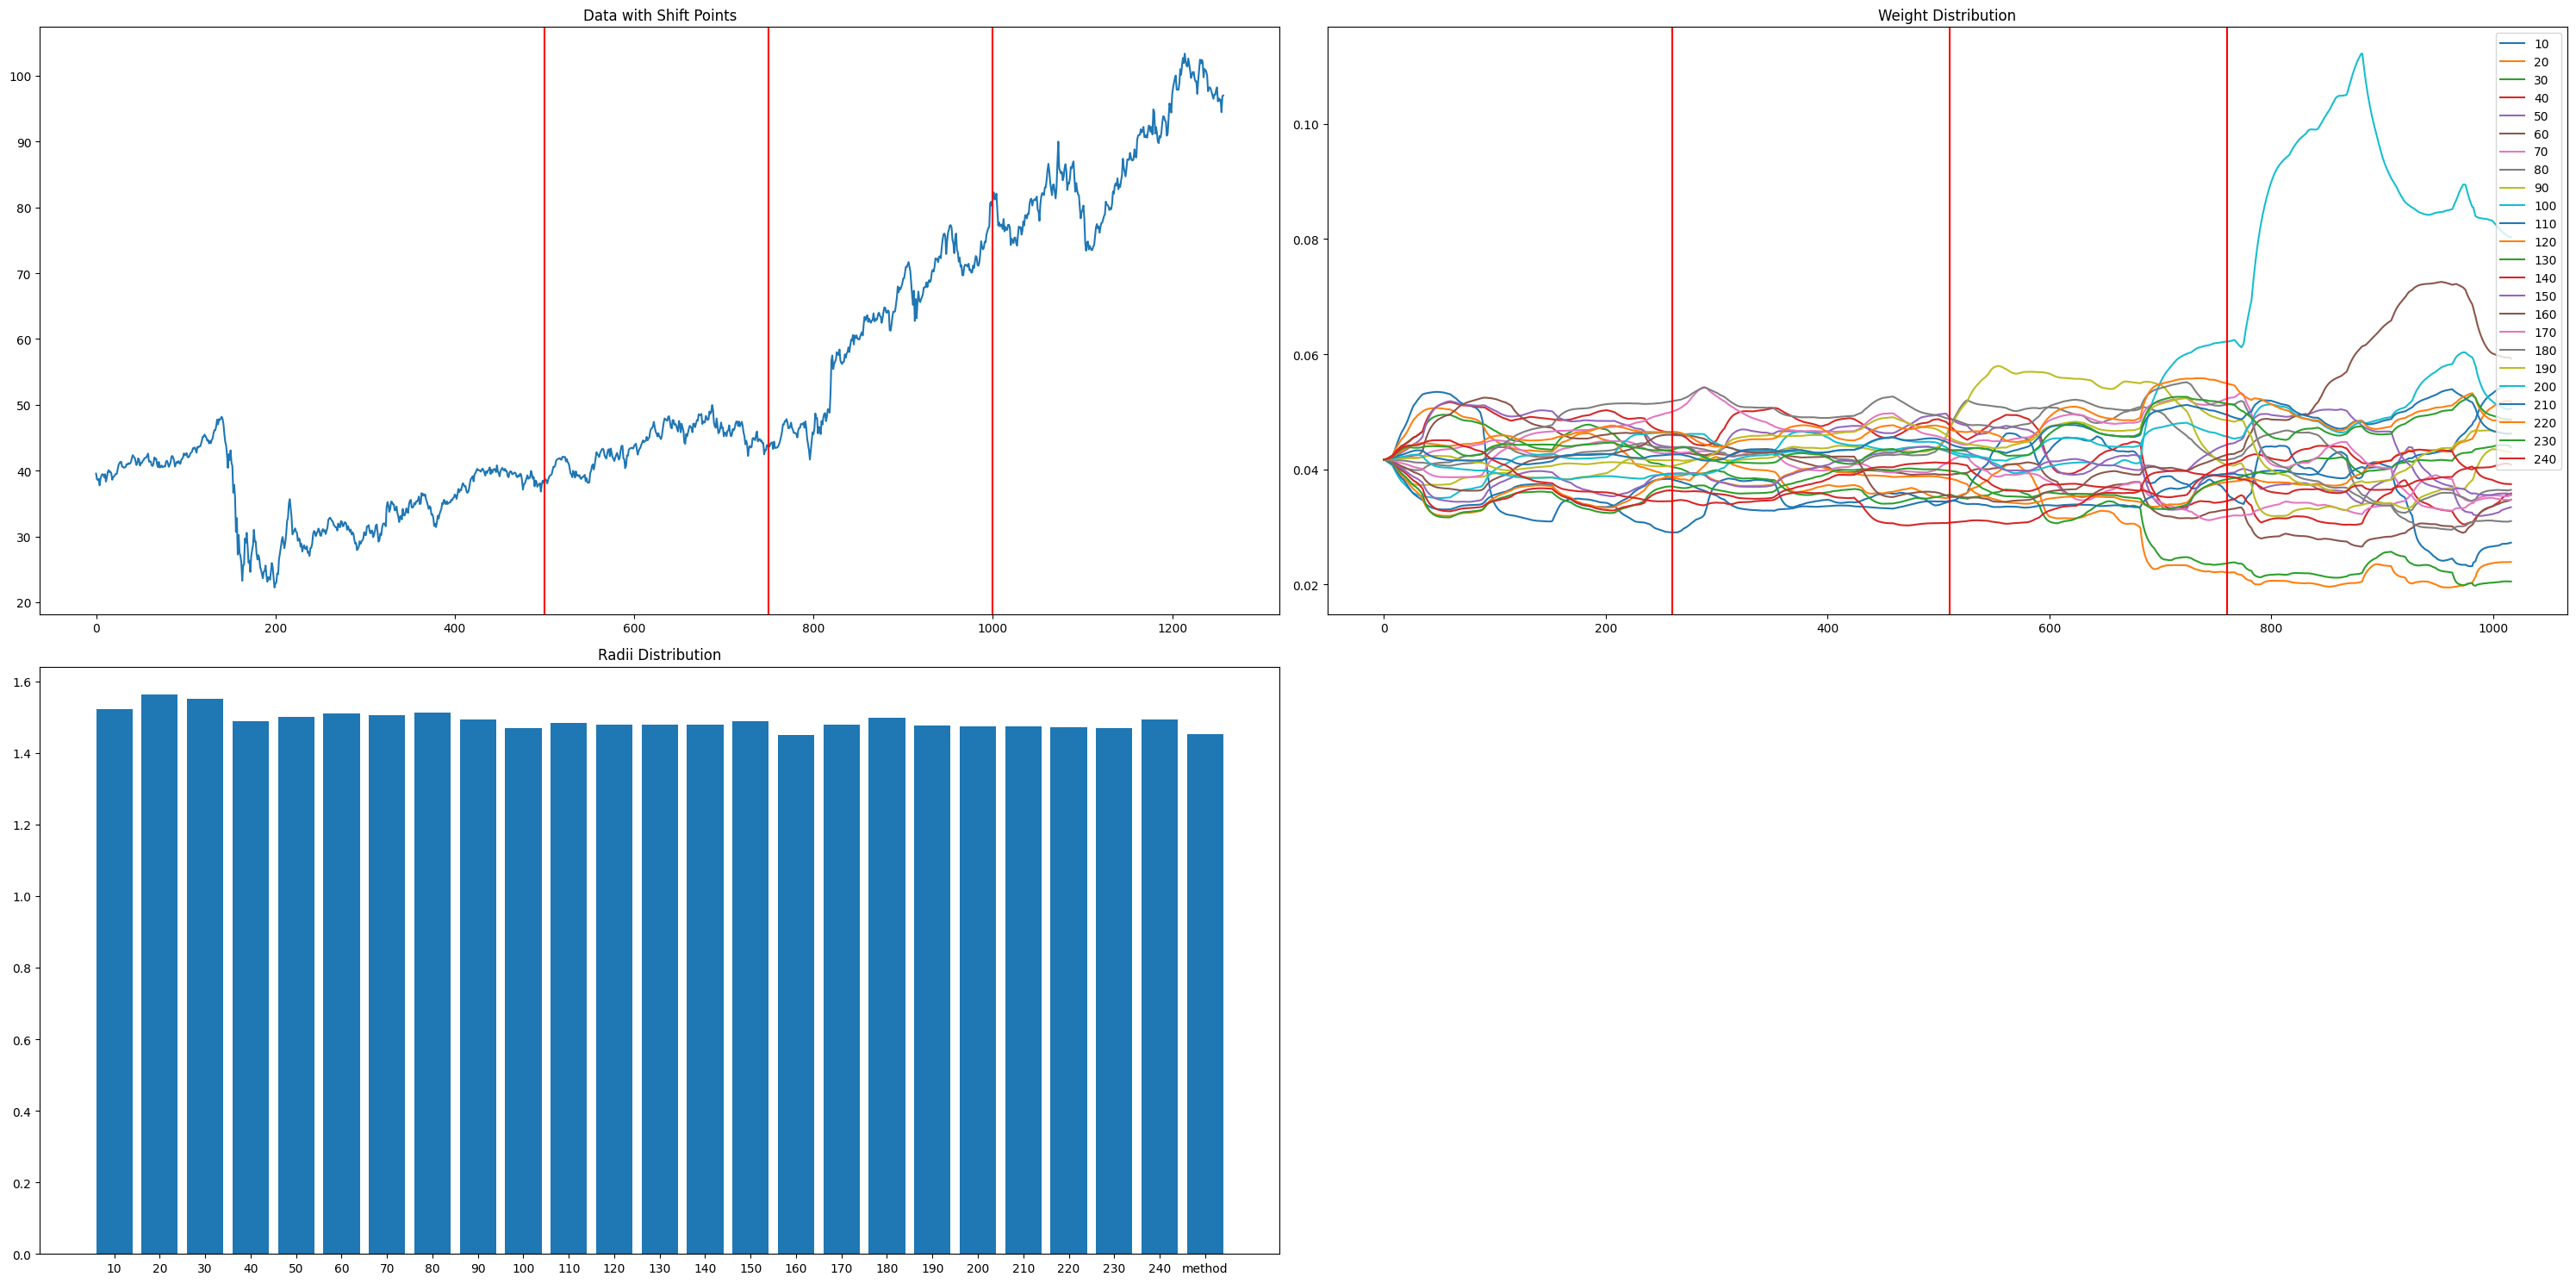

Section: 0 ----------------------------------------------------------------------------------------------------
260
[(np.int64(0), np.float64(0.004243302256901094)), (np.int64(1), np.float64(0.0029465651584247676)), (np.int64(3), np.float64(0.009441655136095729)), (np.int64(4), np.float64(0.01073573724015863)), (np.int64(5), np.float64(0.00460509159253037)), (np.int64(9), np.float64(0.0023524727460759926)), (np.int64(16), np.float64(0.001782511101310975)), (np.int64(17), np.float64(0.009518225629043519)), (np.int64(22), np.float64(8.417266274247606e-05)), (np.int64(23), np.float64(0.00015178311157005615))]


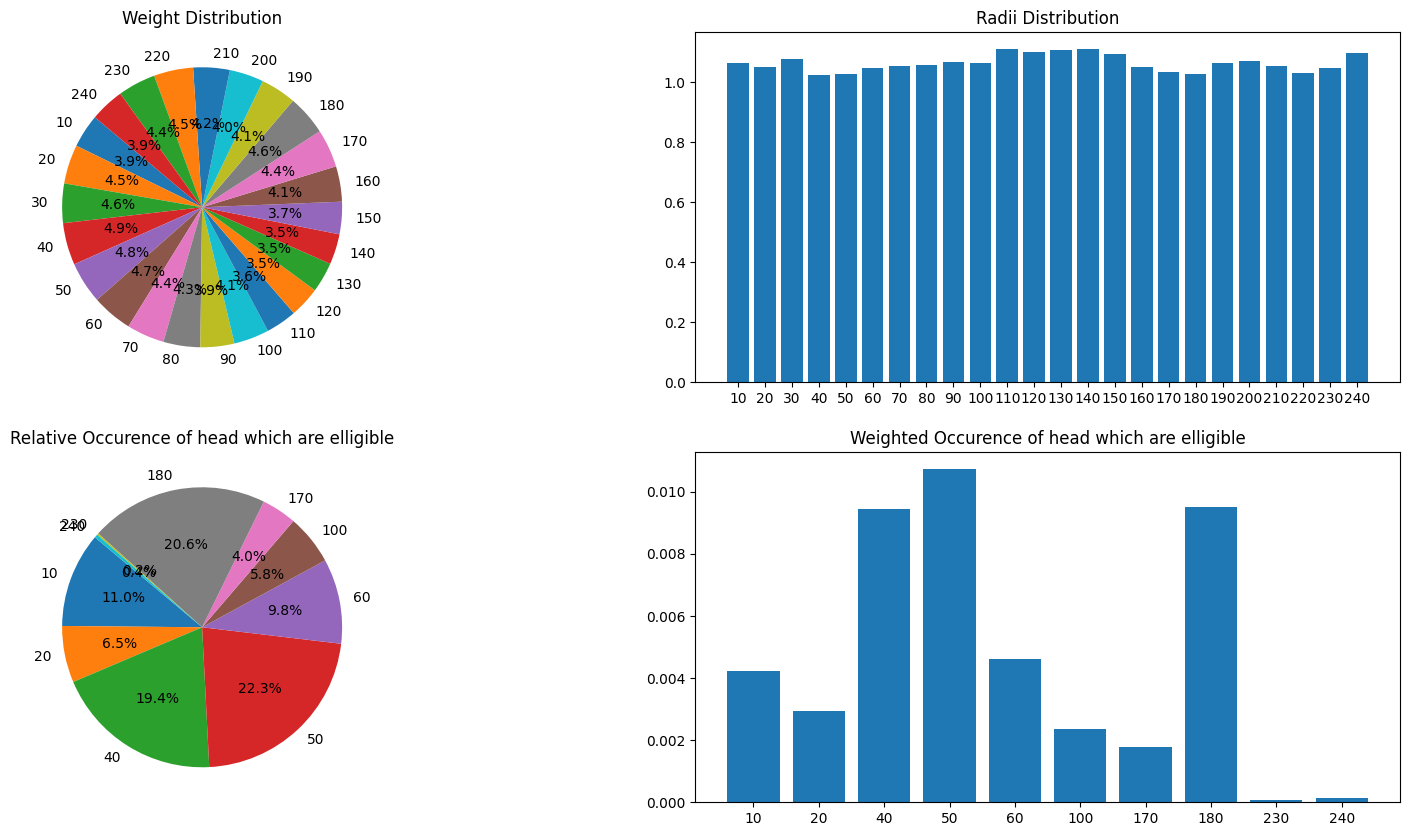

Section: 1 ----------------------------------------------------------------------------------------------------
250
[(np.int64(3), np.float64(0.0008587778587560069)), (np.int64(7), np.float64(0.0001712809752048843)), (np.int64(8), np.float64(0.00145864051651761)), (np.int64(9), np.float64(0.002581551118436397)), (np.int64(11), np.float64(0.0007748160596770655)), (np.int64(12), np.float64(0.002676678076678002)), (np.int64(13), np.float64(0.002803278119571843)), (np.int64(14), np.float64(0.0036308447479945403)), (np.int64(16), np.float64(0.006022831573854959)), (np.int64(17), np.float64(0.009445836669474846)), (np.int64(18), np.float64(0.012531727866039238)), (np.int64(19), np.float64(0.0020513718818941594))]


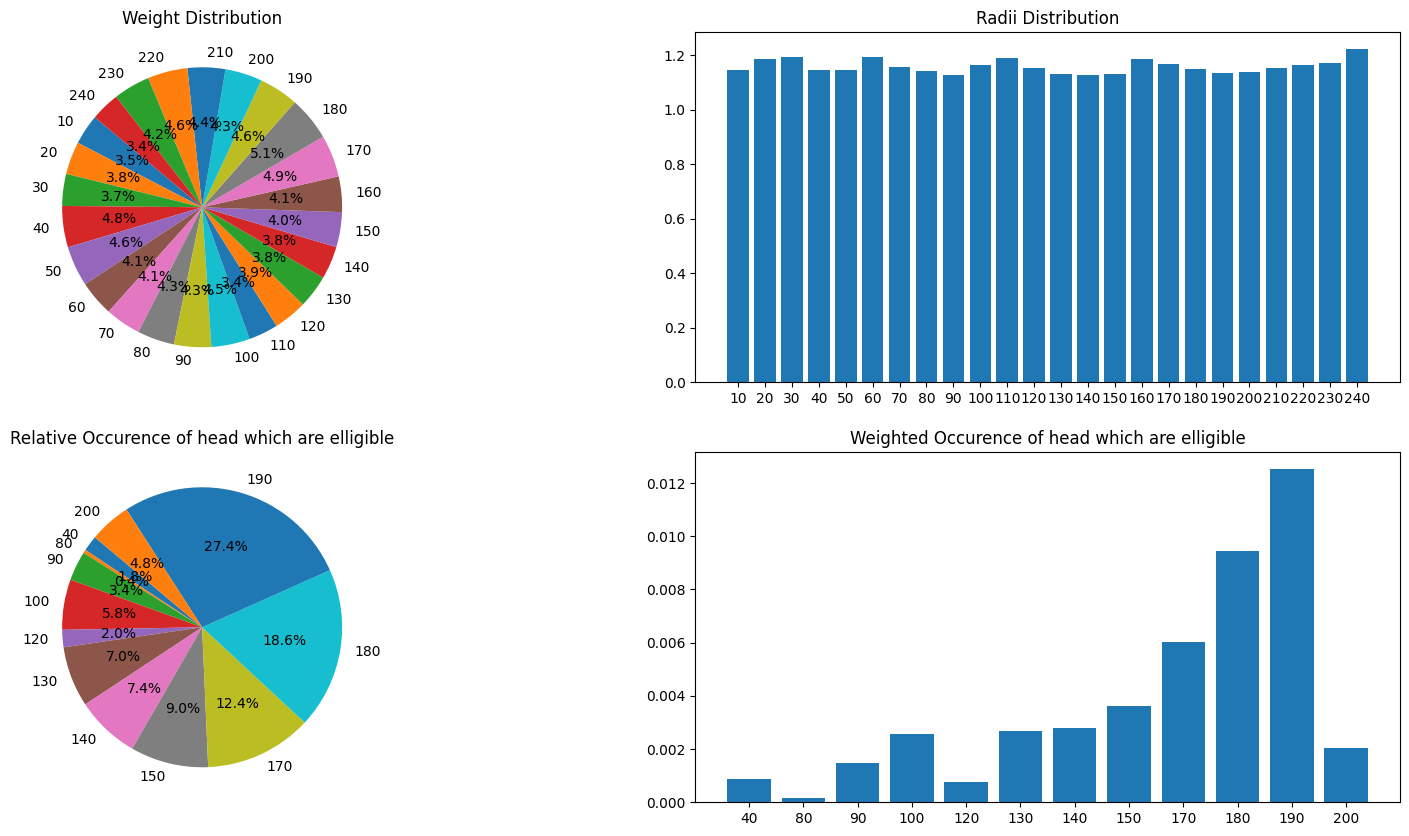

Section: 2 ----------------------------------------------------------------------------------------------------
250
[(np.int64(0), np.float64(0.010488673363610137)), (np.int64(7), np.float64(0.004499705132372496)), (np.int64(8), np.float64(0.020479269925587906)), (np.int64(9), np.float64(0.007109053677443957)), (np.int64(23), np.float64(0.004041766911848486))]


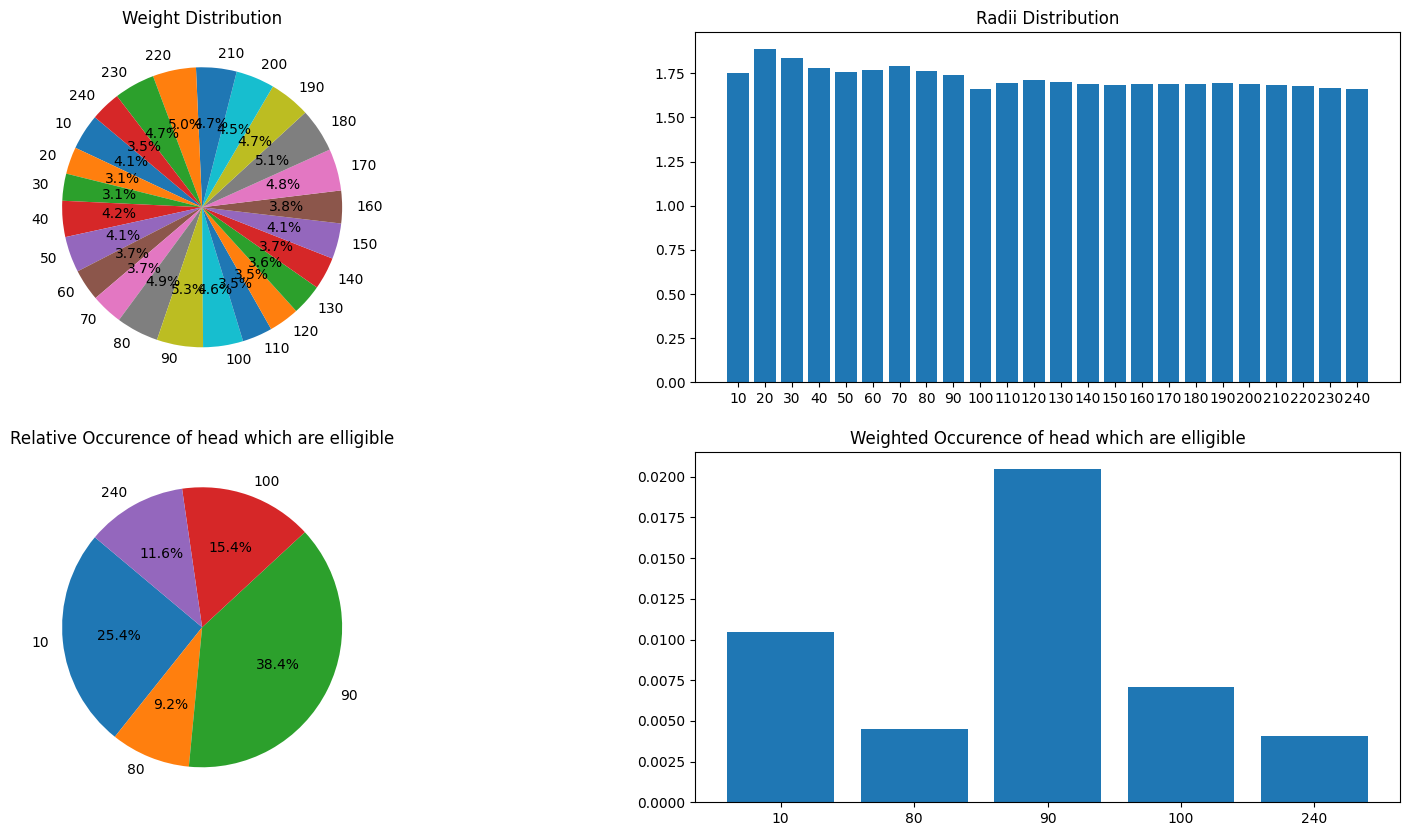

Section: 3 ----------------------------------------------------------------------------------------------------
257
[(np.int64(9), np.float64(0.037473650803140655)), (np.int64(10), np.float64(0.0036200844384645116)), (np.int64(11), np.float64(0.0025775251062675124)), (np.int64(15), np.float64(0.02429912346633844)), (np.int64(23), np.float64(0.0008008619486651121))]


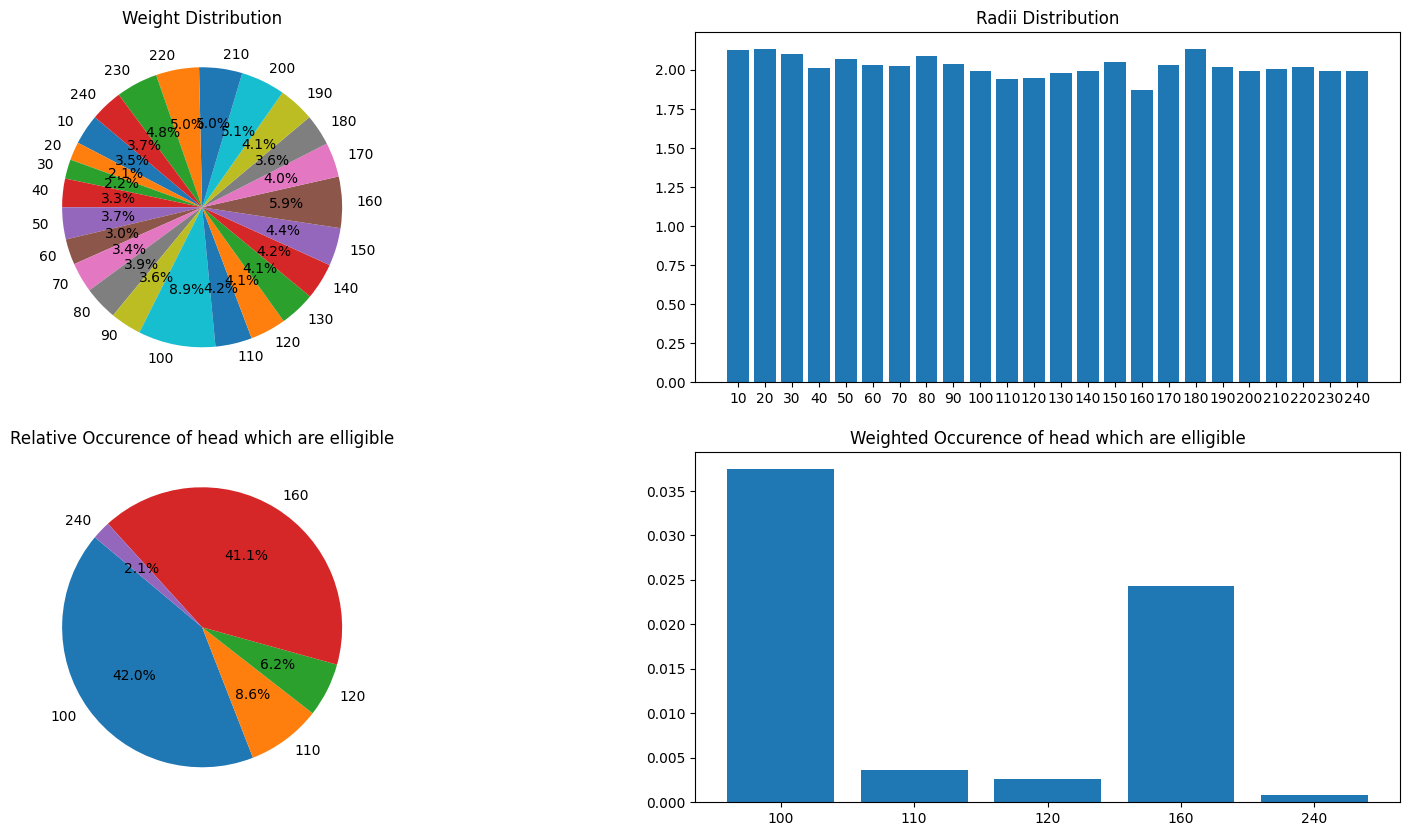

In [211]:
analyse_MACI(stock_data[6], second_MACI().MACI, [*range(10, 250, 10)], [500, 750, 1000], (3*(10**-3), 0.15), 2)

In [219]:
M3 = second_MACI(0.49)

In [220]:
result = M3.MACI(stock_data[5],[*range(10, 250, 10)], k=2)    

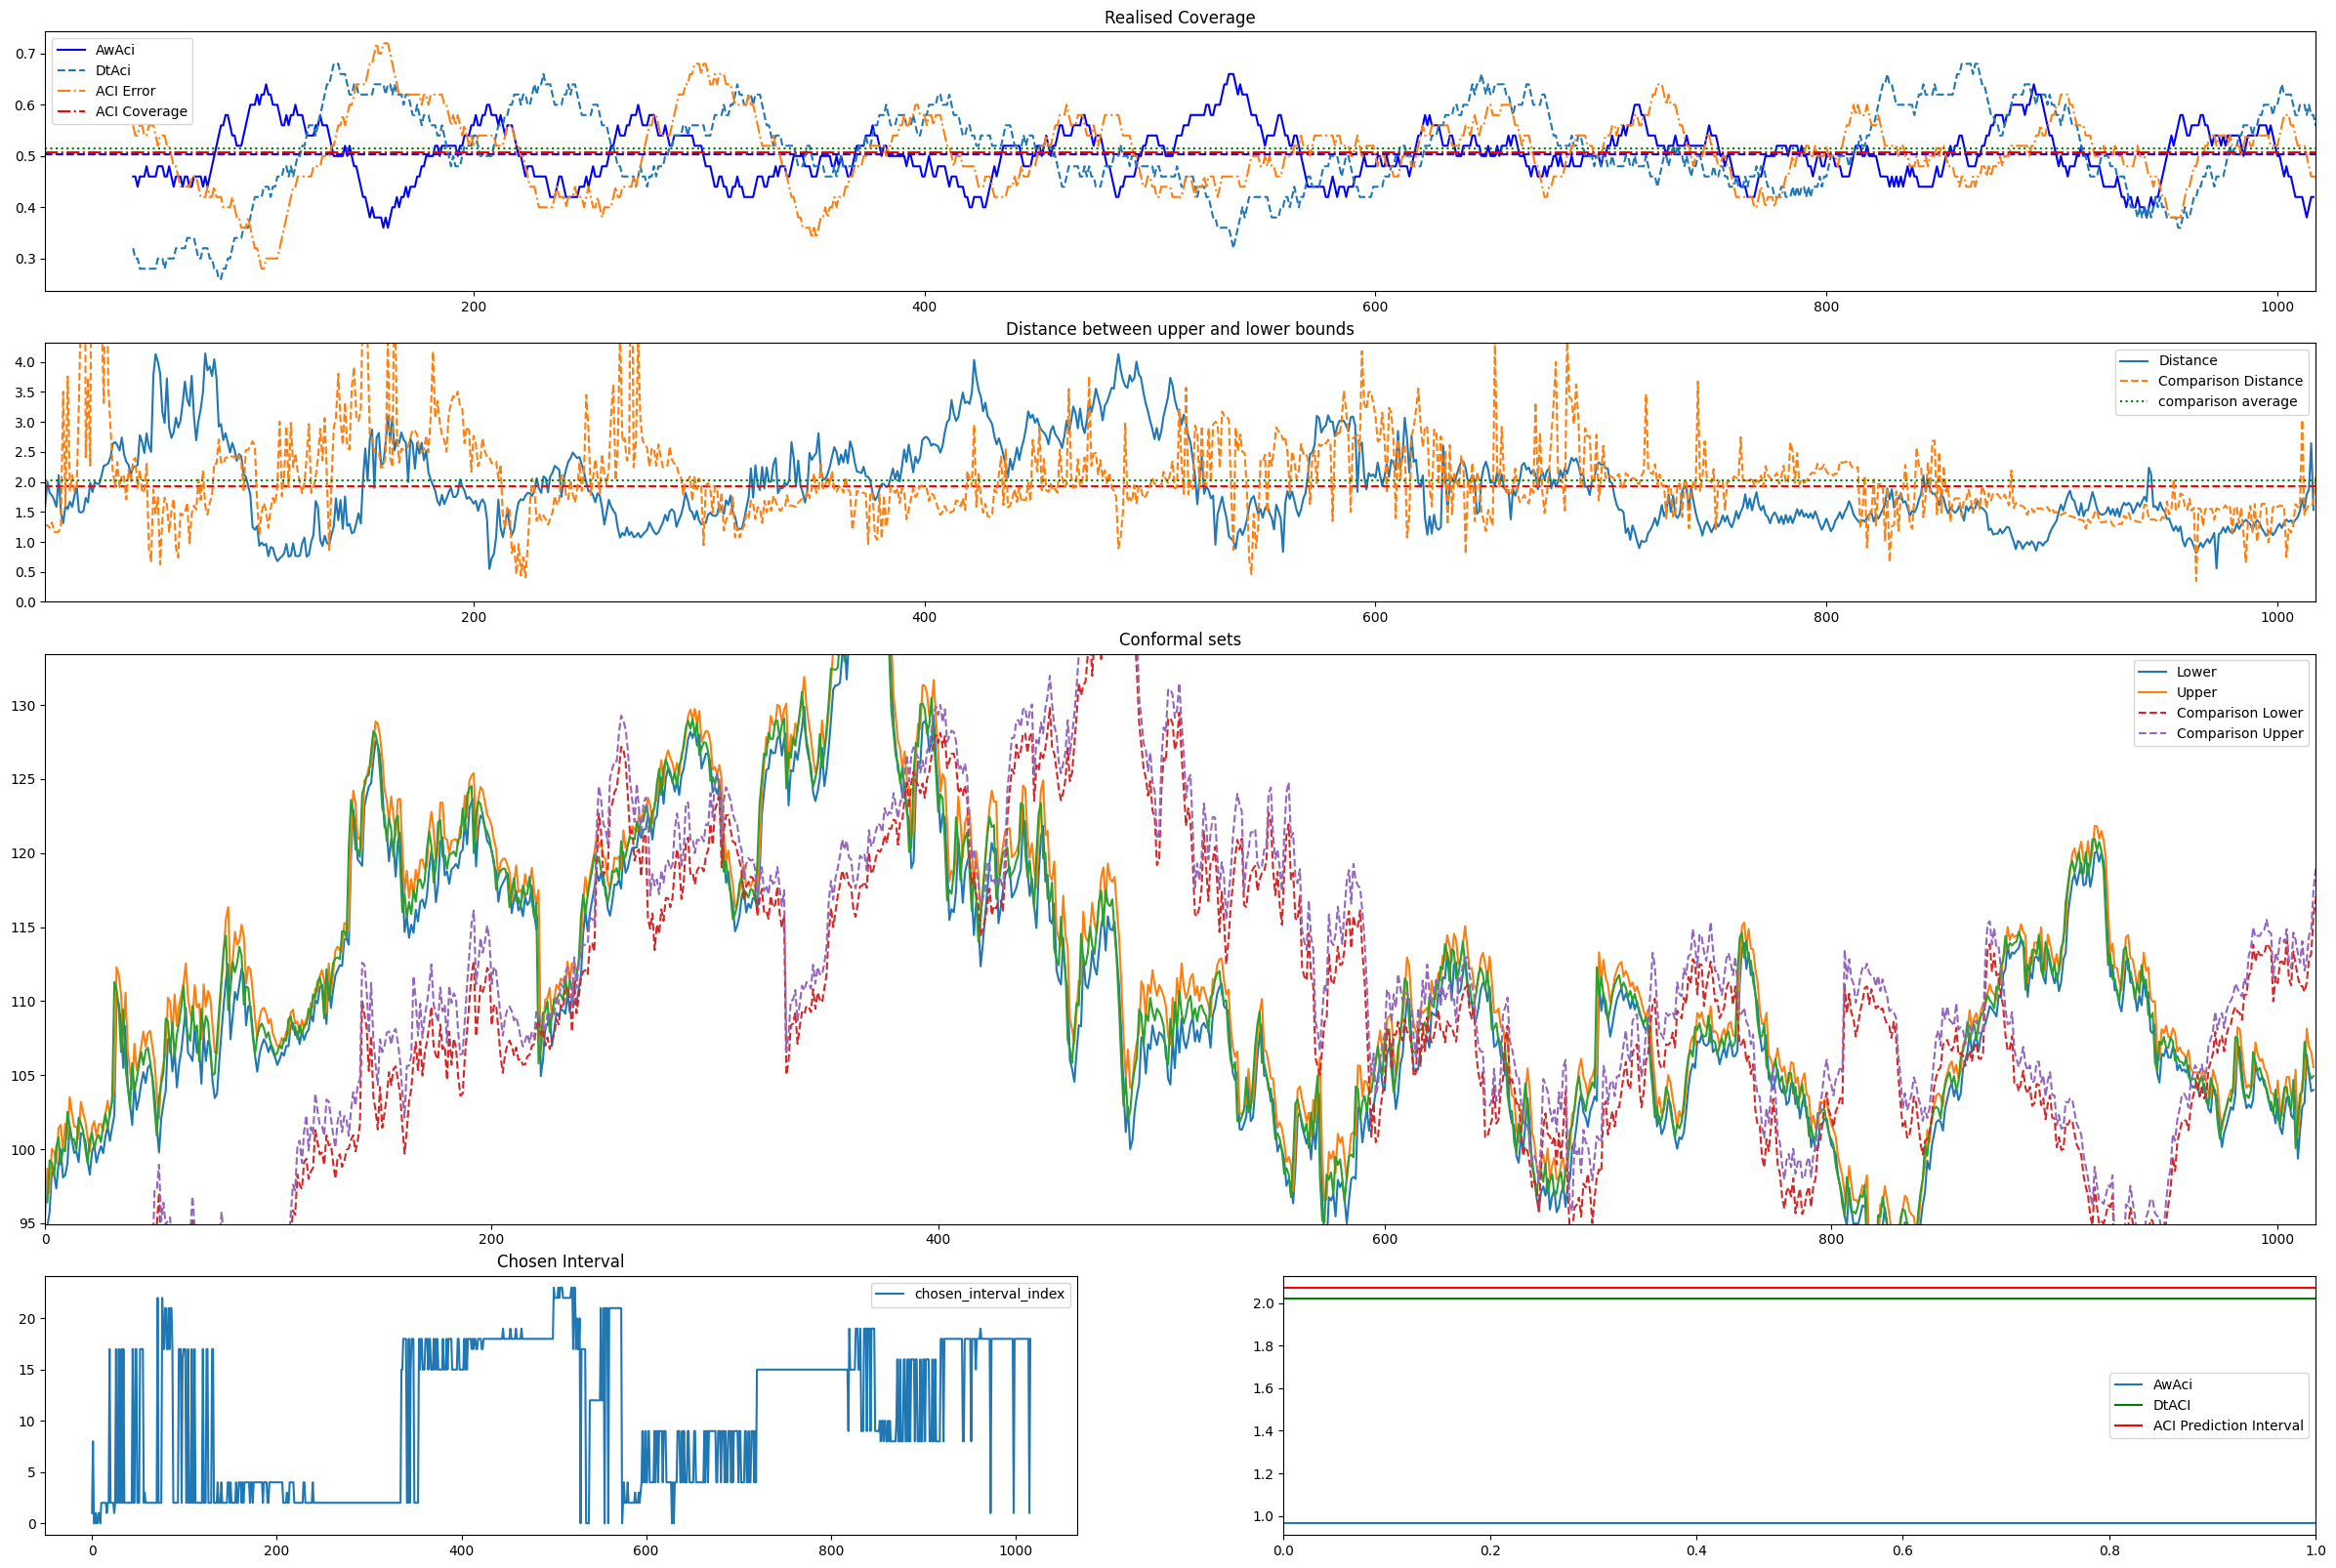

In [221]:
ACP_plots.AwDT_plot(result, stock_data[5], 1)

Okay well this appears to be the shit. It is absolutley destroying the compettion, outperforming pretty much all compettion.

Need to hook it up to the script and run it on multiple,
- If it still performs better than you can rest assure that this is the method
- Then you should perfect the code.
- There is too things which you need to consider one is documenting all of the parameters that you are using the other is explaining why the method works.

In [ ]:
class final_MACI(AdaptiveCP):
    def set_loss(self, optimal_set, given_set):
        # If the optimal set is somehow 0, then we will return the given set.
        if optimal_set == 0:
            return 0
        else:
            val = (optimal_set - given_set) / optimal_set
         
        if val < 0:
            return (self.coverage_target) * (-1* val)
        else:
            return (1 - self.coverage_target) * val
    
    def set_loss_vectorize(self):
         return np.vectorize(self.set_loss)
    
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
        xpred, y = timeseries_data
        alpha_t_list = [self.coverage_target]

        All_scores = self.score_function(xpred, y)

        err_t_list = []
        conformal_sets_list = []
        
        for i in range(start_point, len(All_scores)):
            Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
            conformal_sets_list.append(Coverage_t)

            # We calculate the optimal B_t.

            yield Coverage_t

            error_t = AdaptiveCP.err_t(y[i], Coverage_t)
            err_t_list.append(error_t)

            alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        return False
    
    def MACI(self, timeseries_data: tuple, interval_candidates: np.array = None, k: int = 5, r: float = 1, lookback: int =200, nu_sigma: tuple = (10**-4, 0.1), gamma: float = 0.05, title: str = None):
        ''' 
        k: int - number of heads to consider
        r: float - scales the recent loss
        lookback: int - number of recent losses to consider

        '''
        nu, sigma = nu_sigma
        Set_loss = self.set_loss_vectorize()

        # Base level
        _, y = timeseries_data
        err_t_list = []
        conformal_sets_list = []
        all_interval_weights = []
        chosen_interval_index = []
        radii_list = []
        
        if interval_candidates is None:
            interval_candidates = np.array(range(50, 1000, 100))

        # Set_loss relevant
        optimal_radius_list = []
        chosen_radius_list = []
        all_head_radii = []

        # MACI relevant

        loss_at_step_list = np.array(np.ones(len(interval_candidates)))
        eligible_heads_list = []
        eligible_absolute_weight_list = []
        relative_eligible_final_weight_list = []

        culmative_loss = np.zeros(len(interval_candidates)) # hoping to remove

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.ones(len(interval_candidates))
        active_k = [*range(k)] # On the first step we will simply take the first k heads.
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
                
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here
            
            # Here we choose the set of heads which we will make our choice from.
            eligible_heads = np.take(head_sets, active_k)
            eligible_weights = np.take(interval_weights, active_k)
            normalised_eligible_weights = eligible_weights/sum(eligible_weights)

            # Appending the eligible weights to the list.
            eligible_absolute_weight_list.append(eligible_weights)
            relative_eligible_final_weight_list.append(normalised_eligible_weights)

            # Choosing which head to use.
            try:
                chosen_index = random.choices(active_k, weights=normalised_eligible_weights, k=1)[0] # Choosing the index of the head we wish to use.
                chosen_set = head_sets[chosen_index]
            except ValueError:
                print(all_interval_weights[-5:])
                raise ValueError('Interval probabilities are not normalised correctly.')
            

             # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) 
            
            head_set_radius = np.array(list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)))
            
            # Calculating the loss and updating culmative loss.
            loss_at_step = Set_loss(optimal_set_radius, head_set_radius)
            loss_at_step_list = np.vstack([loss_at_step_list, loss_at_step]) # Adding the loss to the list.

            culmative_loss += Set_loss(optimal_set_radius, head_set_radius)

            # Updating the active k.
            recent_loss_performers = loss_at_step_list[-lookback:].sum(axis=0) # Summing the last 50 losses.
            active_k = np.argsort(recent_loss_performers)[:k] # Getting the argument of the k smallest weights
            eligible_heads_list.append(active_k)
            
            # Updating the weights.
            
            new_weights = interval_weights * np.exp(-1 * nu * (r*recent_loss_performers + culmative_loss)) # We want to consider the recent performance more.
            final_weights = new_weights*(1-sigma) + (new_weights.mean() *sigma)
            
            interval_weights = final_weights/sum(final_weights)


            # Incrementing the i-count
            i_count+=1

            # Appending the results to the lists.
            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(chosen_index)
            err_t_list.append(err_true)
            radii_list.append(head_set_radius)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) 
            optimal_radius_list.append(optimal_set_radius)
            all_head_radii.append(head_set_radius)
            all_interval_weights.append(interval_weights)

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0])/2 for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'MACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'all_head_radii': all_head_radii,
                'all_weights': all_interval_weights,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50,
                'radii_list': radii_list,
                'loss_at_step_list': loss_at_step_list,
                'eligible_heads_list': eligible_heads_list,
                'eligible_absolute_weight_list': eligible_absolute_weight_list,
                'relative_eligible_final_weight_list': relative_eligible_final_weight_list
                
            }
